In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                             | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                   | 1/2604 [00:08<6:23:00,  8.83s/it]

  0%|                                                                                                                   | 2/2604 [00:09<2:42:02,  3.74s/it]

  0%|▏                                                                                                                  | 3/2604 [00:09<1:31:24,  2.11s/it]

  0%|▏                                                                                                                    | 4/2604 [00:09<58:13,  1.34s/it]

  0%|▏                                                                                                                    | 5/2604 [00:09<39:53,  1.09it/s]

  0%|▎                                                                                                                    | 6/2604 [00:09<28:49,  1.50it/s]

  0%|▎                                                                                                                    | 7/2604 [00:09<21:48,  1.98it/s]

  0%|▎                                                                                                                    | 8/2604 [00:10<17:13,  2.51it/s]

  0%|▍                                                                                                                    | 9/2604 [00:10<14:08,  3.06it/s]

  0%|▍                                                                                                                   | 10/2604 [00:10<12:02,  3.59it/s]

  0%|▍                                                                                                                   | 11/2604 [00:10<10:37,  4.07it/s]

  0%|▌                                                                                                                   | 12/2604 [00:10<09:38,  4.48it/s]

  0%|▌                                                                                                                   | 13/2604 [00:10<08:56,  4.83it/s]

  1%|▌                                                                                                                   | 14/2604 [00:11<08:27,  5.10it/s]

  1%|▋                                                                                                                   | 15/2604 [00:11<08:07,  5.31it/s]

  1%|▋                                                                                                                   | 16/2604 [00:11<07:53,  5.46it/s]

  1%|▊                                                                                                                   | 17/2604 [00:11<07:44,  5.57it/s]

  1%|▊                                                                                                                   | 18/2604 [00:11<07:36,  5.66it/s]

  1%|▊                                                                                                                   | 19/2604 [00:11<07:31,  5.73it/s]

  1%|▉                                                                                                                   | 20/2604 [00:12<07:28,  5.77it/s]

  1%|▉                                                                                                                   | 21/2604 [00:12<07:25,  5.79it/s]

  1%|▉                                                                                                                   | 22/2604 [00:12<07:24,  5.81it/s]

  1%|█                                                                                                                   | 23/2604 [00:12<07:22,  5.83it/s]

  1%|█                                                                                                                   | 24/2604 [00:12<07:22,  5.84it/s]

  1%|█                                                                                                                   | 25/2604 [00:12<07:21,  5.84it/s]

  1%|█▏                                                                                                                  | 26/2604 [00:13<07:20,  5.85it/s]

  1%|█▏                                                                                                                  | 27/2604 [00:13<07:20,  5.85it/s]

  1%|█▏                                                                                                                  | 28/2604 [00:13<07:20,  5.85it/s]

  1%|█▎                                                                                                                  | 29/2604 [00:13<07:19,  5.85it/s]

  1%|█▎                                                                                                                  | 30/2604 [00:13<07:20,  5.85it/s]

  1%|█▍                                                                                                                  | 31/2604 [00:13<07:19,  5.85it/s]

  1%|█▍                                                                                                                  | 32/2604 [00:14<07:19,  5.85it/s]

  1%|█▍                                                                                                                  | 33/2604 [00:14<07:18,  5.86it/s]

  1%|█▌                                                                                                                  | 34/2604 [00:14<07:18,  5.86it/s]

  1%|█▌                                                                                                                  | 35/2604 [00:14<07:18,  5.86it/s]

  1%|█▌                                                                                                                  | 36/2604 [00:14<07:18,  5.86it/s]

  1%|█▋                                                                                                                  | 37/2604 [00:14<07:18,  5.86it/s]

  1%|█▋                                                                                                                  | 38/2604 [00:15<07:17,  5.86it/s]

  1%|█▋                                                                                                                  | 39/2604 [00:15<07:18,  5.85it/s]

  2%|█▊                                                                                                                  | 40/2604 [00:15<07:18,  5.85it/s]

  2%|█▊                                                                                                                  | 41/2604 [00:15<07:17,  5.85it/s]

  2%|█▊                                                                                                                  | 42/2604 [00:15<07:17,  5.85it/s]

  2%|█▉                                                                                                                  | 43/2604 [00:16<07:17,  5.85it/s]

  2%|█▉                                                                                                                  | 44/2604 [00:16<07:17,  5.86it/s]

  2%|██                                                                                                                  | 45/2604 [00:16<07:16,  5.86it/s]

  2%|██                                                                                                                  | 46/2604 [00:16<07:17,  5.85it/s]

  2%|██                                                                                                                  | 47/2604 [00:16<07:17,  5.85it/s]

  2%|██▏                                                                                                                 | 48/2604 [00:16<07:16,  5.85it/s]

  2%|██▏                                                                                                                 | 49/2604 [00:17<07:16,  5.85it/s]

  2%|██▏                                                                                                                 | 50/2604 [00:17<07:16,  5.85it/s]

  2%|██▎                                                                                                                 | 51/2604 [00:17<07:16,  5.86it/s]

  2%|██▎                                                                                                                 | 52/2604 [00:17<07:15,  5.86it/s]

  2%|██▎                                                                                                                 | 53/2604 [00:17<07:15,  5.85it/s]

  2%|██▍                                                                                                                 | 54/2604 [00:17<07:14,  5.87it/s]

  2%|██▍                                                                                                                 | 55/2604 [00:18<07:13,  5.88it/s]

  2%|██▍                                                                                                                 | 56/2604 [00:18<07:12,  5.89it/s]

  2%|██▌                                                                                                                 | 57/2604 [00:18<07:12,  5.89it/s]

  2%|██▌                                                                                                                 | 58/2604 [00:18<07:11,  5.90it/s]

  2%|██▋                                                                                                                 | 59/2604 [00:18<07:11,  5.90it/s]

  2%|██▋                                                                                                                 | 60/2604 [00:18<07:11,  5.89it/s]

  2%|██▋                                                                                                                 | 61/2604 [00:19<07:12,  5.88it/s]

  2%|██▊                                                                                                                 | 62/2604 [00:19<07:13,  5.87it/s]

  2%|██▊                                                                                                                 | 63/2604 [00:19<07:12,  5.87it/s]

  2%|██▊                                                                                                                 | 64/2604 [00:19<07:12,  5.87it/s]

  2%|██▉                                                                                                                 | 65/2604 [00:19<07:12,  5.86it/s]

  3%|██▉                                                                                                                 | 66/2604 [00:19<07:12,  5.86it/s]

  3%|██▉                                                                                                                 | 67/2604 [00:20<07:13,  5.85it/s]

  3%|███                                                                                                                 | 68/2604 [00:20<07:13,  5.86it/s]

  3%|███                                                                                                                 | 69/2604 [00:20<07:12,  5.85it/s]

  3%|███                                                                                                                 | 70/2604 [00:20<07:12,  5.86it/s]

  3%|███▏                                                                                                                | 71/2604 [00:20<07:12,  5.85it/s]

  3%|███▏                                                                                                                | 72/2604 [00:20<07:12,  5.86it/s]

  3%|███▎                                                                                                                | 73/2604 [00:21<07:12,  5.86it/s]

  3%|███▎                                                                                                                | 74/2604 [00:21<07:12,  5.85it/s]

  3%|███▎                                                                                                                | 75/2604 [00:21<07:12,  5.85it/s]

  3%|███▍                                                                                                                | 76/2604 [00:21<07:11,  5.85it/s]

  3%|███▍                                                                                                                | 77/2604 [00:21<07:11,  5.85it/s]

  3%|███▍                                                                                                                | 78/2604 [00:21<07:11,  5.86it/s]

  3%|███▌                                                                                                                | 79/2604 [00:22<07:11,  5.85it/s]

  3%|███▌                                                                                                                | 80/2604 [00:22<07:11,  5.86it/s]

  3%|███▌                                                                                                                | 81/2604 [00:22<07:11,  5.85it/s]

  3%|███▋                                                                                                                | 82/2604 [00:22<07:10,  5.85it/s]

  3%|███▋                                                                                                                | 83/2604 [00:22<07:10,  5.85it/s]

  3%|███▋                                                                                                                | 84/2604 [00:22<07:10,  5.85it/s]

  3%|███▊                                                                                                                | 85/2604 [00:23<07:10,  5.85it/s]

  3%|███▊                                                                                                                | 86/2604 [00:23<07:10,  5.85it/s]

  3%|███▉                                                                                                                | 87/2604 [00:23<07:09,  5.86it/s]

  3%|███▉                                                                                                                | 88/2604 [00:23<07:10,  5.85it/s]

  3%|███▉                                                                                                                | 89/2604 [00:23<07:09,  5.85it/s]

  3%|████                                                                                                                | 90/2604 [00:24<07:09,  5.85it/s]

  3%|████                                                                                                                | 91/2604 [00:24<07:09,  5.86it/s]

  4%|████                                                                                                                | 92/2604 [00:24<07:08,  5.86it/s]

  4%|████▏                                                                                                               | 93/2604 [00:24<07:08,  5.86it/s]

  4%|████▏                                                                                                               | 94/2604 [00:24<07:08,  5.86it/s]

  4%|████▏                                                                                                               | 95/2604 [00:24<07:08,  5.85it/s]

  4%|████▎                                                                                                               | 96/2604 [00:25<07:08,  5.85it/s]

  4%|████▎                                                                                                               | 97/2604 [00:25<07:08,  5.86it/s]

  4%|████▎                                                                                                               | 98/2604 [00:25<07:07,  5.86it/s]

  4%|████▍                                                                                                               | 99/2604 [00:25<07:07,  5.86it/s]

  4%|████▍                                                                                                              | 100/2604 [00:25<07:06,  5.87it/s]

  4%|████▍                                                                                                              | 101/2604 [00:25<07:06,  5.87it/s]

  4%|████▌                                                                                                              | 102/2604 [00:26<07:06,  5.87it/s]

  4%|████▌                                                                                                              | 103/2604 [00:26<07:05,  5.87it/s]

  4%|████▌                                                                                                              | 104/2604 [00:26<07:05,  5.87it/s]

  4%|████▋                                                                                                              | 105/2604 [00:26<07:05,  5.88it/s]

  4%|████▋                                                                                                              | 106/2604 [00:26<07:05,  5.88it/s]

  4%|████▋                                                                                                              | 107/2604 [00:26<07:05,  5.87it/s]

  4%|████▊                                                                                                              | 108/2604 [00:27<07:04,  5.87it/s]

  4%|████▊                                                                                                              | 109/2604 [00:27<07:04,  5.87it/s]

  4%|████▊                                                                                                              | 110/2604 [00:27<07:03,  5.89it/s]

  4%|████▉                                                                                                              | 111/2604 [00:27<07:02,  5.90it/s]

  4%|████▉                                                                                                              | 112/2604 [00:27<07:01,  5.91it/s]

  4%|████▉                                                                                                              | 113/2604 [00:27<07:01,  5.92it/s]

  4%|█████                                                                                                              | 114/2604 [00:28<07:00,  5.92it/s]

  4%|█████                                                                                                              | 115/2604 [00:28<07:00,  5.92it/s]

  4%|█████                                                                                                              | 116/2604 [00:28<07:00,  5.91it/s]

  4%|█████▏                                                                                                             | 117/2604 [00:28<07:01,  5.90it/s]

  5%|█████▏                                                                                                             | 118/2604 [00:28<07:01,  5.90it/s]

  5%|█████▎                                                                                                             | 119/2604 [00:28<07:01,  5.89it/s]

  5%|█████▎                                                                                                             | 120/2604 [00:29<07:01,  5.89it/s]

  5%|█████▎                                                                                                             | 121/2604 [00:29<07:01,  5.89it/s]

  5%|█████▍                                                                                                             | 122/2604 [00:29<07:01,  5.88it/s]

  5%|█████▍                                                                                                             | 123/2604 [00:29<07:02,  5.87it/s]

  5%|█████▍                                                                                                             | 124/2604 [00:29<07:02,  5.88it/s]

  5%|█████▌                                                                                                             | 125/2604 [00:29<07:01,  5.88it/s]

  5%|█████▌                                                                                                             | 126/2604 [00:30<07:01,  5.88it/s]

  5%|█████▌                                                                                                             | 127/2604 [00:30<07:01,  5.88it/s]

  5%|█████▋                                                                                                             | 128/2604 [00:30<07:01,  5.88it/s]

  5%|█████▋                                                                                                             | 129/2604 [00:30<07:00,  5.88it/s]

  5%|█████▋                                                                                                             | 130/2604 [00:30<07:01,  5.87it/s]

  5%|█████▊                                                                                                             | 131/2604 [00:30<07:00,  5.88it/s]

  5%|█████▊                                                                                                             | 132/2604 [00:31<07:00,  5.88it/s]

  5%|█████▊                                                                                                             | 133/2604 [00:31<07:00,  5.88it/s]

  5%|█████▉                                                                                                             | 134/2604 [00:31<07:00,  5.88it/s]

  5%|█████▉                                                                                                             | 135/2604 [00:31<06:59,  5.88it/s]

  5%|██████                                                                                                             | 136/2604 [00:31<06:59,  5.88it/s]

  5%|██████                                                                                                             | 137/2604 [00:32<07:00,  5.87it/s]

  5%|██████                                                                                                             | 138/2604 [00:32<06:59,  5.88it/s]

  5%|██████▏                                                                                                            | 139/2604 [00:32<06:59,  5.88it/s]

  5%|██████▏                                                                                                            | 140/2604 [00:32<06:59,  5.88it/s]

  5%|██████▏                                                                                                            | 141/2604 [00:32<06:58,  5.88it/s]

  5%|██████▎                                                                                                            | 142/2604 [00:32<06:58,  5.88it/s]

  5%|██████▎                                                                                                            | 143/2604 [00:33<06:58,  5.88it/s]

  6%|██████▎                                                                                                            | 144/2604 [00:33<06:58,  5.87it/s]

  6%|██████▍                                                                                                            | 145/2604 [00:33<06:58,  5.88it/s]

  6%|██████▍                                                                                                            | 146/2604 [00:33<06:58,  5.88it/s]

  6%|██████▍                                                                                                            | 147/2604 [00:33<06:57,  5.88it/s]

  6%|██████▌                                                                                                            | 148/2604 [00:33<06:57,  5.88it/s]

  6%|██████▌                                                                                                            | 149/2604 [00:34<06:57,  5.88it/s]

  6%|██████▌                                                                                                            | 150/2604 [00:34<06:57,  5.88it/s]

  6%|██████▋                                                                                                            | 151/2604 [00:34<06:57,  5.87it/s]

  6%|██████▋                                                                                                            | 152/2604 [00:34<06:57,  5.88it/s]

  6%|██████▊                                                                                                            | 153/2604 [00:34<06:57,  5.88it/s]

  6%|██████▊                                                                                                            | 154/2604 [00:34<06:56,  5.88it/s]

  6%|██████▊                                                                                                            | 155/2604 [00:35<06:56,  5.88it/s]

  6%|██████▉                                                                                                            | 156/2604 [00:35<06:56,  5.88it/s]

  6%|██████▉                                                                                                            | 157/2604 [00:35<06:55,  5.88it/s]

  6%|██████▉                                                                                                            | 158/2604 [00:35<06:56,  5.88it/s]

  6%|███████                                                                                                            | 159/2604 [00:35<06:56,  5.88it/s]

  6%|███████                                                                                                            | 160/2604 [00:35<06:55,  5.88it/s]

  6%|███████                                                                                                            | 161/2604 [00:36<06:55,  5.88it/s]

  6%|███████▏                                                                                                           | 162/2604 [00:36<06:55,  5.88it/s]

  6%|███████▏                                                                                                           | 163/2604 [00:36<06:55,  5.88it/s]

  6%|███████▏                                                                                                           | 164/2604 [00:36<06:54,  5.88it/s]

  6%|███████▎                                                                                                           | 165/2604 [00:36<06:54,  5.88it/s]

  6%|███████▎                                                                                                           | 166/2604 [00:36<06:53,  5.90it/s]

  6%|███████▍                                                                                                           | 167/2604 [00:37<06:52,  5.90it/s]

  6%|███████▍                                                                                                           | 168/2604 [00:37<06:52,  5.91it/s]

  6%|███████▍                                                                                                           | 169/2604 [00:37<06:51,  5.92it/s]

  7%|███████▌                                                                                                           | 170/2604 [00:37<06:51,  5.92it/s]

  7%|███████▌                                                                                                           | 171/2604 [00:37<06:50,  5.92it/s]

  7%|███████▌                                                                                                           | 172/2604 [00:37<06:51,  5.91it/s]

  7%|███████▋                                                                                                           | 173/2604 [00:38<06:51,  5.90it/s]

  7%|███████▋                                                                                                           | 174/2604 [00:38<06:52,  5.90it/s]

  7%|███████▋                                                                                                           | 175/2604 [00:38<06:52,  5.89it/s]

  7%|███████▊                                                                                                           | 176/2604 [00:38<06:52,  5.89it/s]

  7%|███████▊                                                                                                           | 177/2604 [00:38<06:52,  5.89it/s]

  7%|███████▊                                                                                                           | 178/2604 [00:38<06:52,  5.89it/s]

  7%|███████▉                                                                                                           | 179/2604 [00:39<06:52,  5.88it/s]

  7%|███████▉                                                                                                           | 180/2604 [00:39<06:52,  5.88it/s]

  7%|███████▉                                                                                                           | 181/2604 [00:39<06:52,  5.88it/s]

  7%|████████                                                                                                           | 182/2604 [00:39<06:51,  5.88it/s]

  7%|████████                                                                                                           | 183/2604 [00:39<06:51,  5.88it/s]

  7%|████████▏                                                                                                          | 184/2604 [00:40<06:51,  5.88it/s]

  7%|████████▏                                                                                                          | 185/2604 [00:40<06:51,  5.88it/s]

  7%|████████▏                                                                                                          | 186/2604 [00:40<06:51,  5.87it/s]

  7%|████████▎                                                                                                          | 187/2604 [00:40<06:51,  5.88it/s]

  7%|████████▎                                                                                                          | 188/2604 [00:40<06:51,  5.88it/s]

  7%|████████▎                                                                                                          | 189/2604 [00:40<06:50,  5.88it/s]

  7%|████████▍                                                                                                          | 190/2604 [00:41<06:50,  5.88it/s]

  7%|████████▍                                                                                                          | 191/2604 [00:41<06:50,  5.88it/s]

  7%|████████▍                                                                                                          | 192/2604 [00:41<06:50,  5.88it/s]

  7%|████████▌                                                                                                          | 193/2604 [00:41<06:50,  5.87it/s]

  7%|████████▌                                                                                                          | 194/2604 [00:41<06:50,  5.88it/s]

  7%|████████▌                                                                                                          | 195/2604 [00:41<06:49,  5.88it/s]

  8%|████████▋                                                                                                          | 196/2604 [00:42<06:49,  5.88it/s]

  8%|████████▋                                                                                                          | 197/2604 [00:42<06:49,  5.88it/s]

  8%|████████▋                                                                                                          | 198/2604 [00:42<06:49,  5.88it/s]

  8%|████████▊                                                                                                          | 199/2604 [00:42<06:49,  5.88it/s]

  8%|████████▊                                                                                                          | 200/2604 [00:42<06:49,  5.87it/s]

  8%|████████▉                                                                                                          | 201/2604 [00:42<06:49,  5.87it/s]

  8%|████████▉                                                                                                          | 202/2604 [00:43<06:48,  5.88it/s]

  8%|████████▉                                                                                                          | 203/2604 [00:43<06:49,  5.87it/s]

  8%|█████████                                                                                                          | 204/2604 [00:43<06:49,  5.86it/s]

  8%|█████████                                                                                                          | 205/2604 [00:43<06:49,  5.86it/s]

  8%|█████████                                                                                                          | 206/2604 [00:43<06:49,  5.86it/s]

  8%|█████████▏                                                                                                         | 207/2604 [00:43<06:49,  5.85it/s]

  8%|█████████▏                                                                                                         | 208/2604 [00:44<06:49,  5.85it/s]

  8%|█████████▏                                                                                                         | 209/2604 [00:44<06:49,  5.85it/s]

  8%|█████████▎                                                                                                         | 210/2604 [00:44<06:49,  5.85it/s]

  8%|█████████▎                                                                                                         | 211/2604 [00:44<06:48,  5.85it/s]

  8%|█████████▎                                                                                                         | 212/2604 [00:44<06:48,  5.85it/s]

  8%|█████████▍                                                                                                         | 213/2604 [00:44<06:48,  5.85it/s]

  8%|█████████▍                                                                                                         | 214/2604 [00:45<06:48,  5.84it/s]

  8%|█████████▍                                                                                                         | 215/2604 [00:45<06:52,  5.79it/s]

  8%|█████████▌                                                                                                         | 216/2604 [00:45<06:51,  5.81it/s]

  8%|█████████▌                                                                                                         | 217/2604 [00:45<06:49,  5.82it/s]

  8%|█████████▋                                                                                                         | 218/2604 [00:45<06:49,  5.83it/s]

  8%|█████████▋                                                                                                         | 219/2604 [00:45<06:48,  5.84it/s]

  8%|█████████▋                                                                                                         | 220/2604 [00:46<06:48,  5.84it/s]

  8%|█████████▊                                                                                                         | 221/2604 [00:46<06:47,  5.84it/s]

  9%|█████████▊                                                                                                         | 222/2604 [00:46<06:46,  5.86it/s]

  9%|█████████▊                                                                                                         | 223/2604 [00:46<06:45,  5.87it/s]

  9%|█████████▉                                                                                                         | 224/2604 [00:46<06:44,  5.88it/s]

  9%|█████████▉                                                                                                         | 225/2604 [00:46<06:44,  5.89it/s]

  9%|█████████▉                                                                                                         | 226/2604 [00:47<06:43,  5.89it/s]

  9%|██████████                                                                                                         | 227/2604 [00:47<06:43,  5.90it/s]

  9%|██████████                                                                                                         | 228/2604 [00:47<06:43,  5.89it/s]

  9%|██████████                                                                                                         | 229/2604 [00:47<06:44,  5.88it/s]

  9%|██████████▏                                                                                                        | 230/2604 [00:47<06:44,  5.87it/s]

  9%|██████████▏                                                                                                        | 231/2604 [00:48<06:44,  5.87it/s]

  9%|██████████▏                                                                                                        | 232/2604 [00:48<06:44,  5.86it/s]

  9%|██████████▎                                                                                                        | 233/2604 [00:48<06:44,  5.86it/s]

  9%|██████████▎                                                                                                        | 234/2604 [00:48<06:44,  5.86it/s]

  9%|██████████▍                                                                                                        | 235/2604 [00:48<06:44,  5.85it/s]

  9%|██████████▍                                                                                                        | 236/2604 [00:48<06:44,  5.85it/s]

  9%|██████████▍                                                                                                        | 237/2604 [00:49<06:44,  5.85it/s]

  9%|██████████▌                                                                                                        | 238/2604 [00:49<06:44,  5.85it/s]

  9%|██████████▌                                                                                                        | 239/2604 [00:49<06:44,  5.85it/s]

  9%|██████████▌                                                                                                        | 240/2604 [00:49<06:43,  5.85it/s]

  9%|██████████▋                                                                                                        | 241/2604 [00:49<06:43,  5.85it/s]

  9%|██████████▋                                                                                                        | 242/2604 [00:49<06:43,  5.85it/s]

  9%|██████████▋                                                                                                        | 243/2604 [00:50<06:43,  5.85it/s]

  9%|██████████▊                                                                                                        | 244/2604 [00:50<06:43,  5.85it/s]

  9%|██████████▊                                                                                                        | 245/2604 [00:50<06:43,  5.85it/s]

  9%|██████████▊                                                                                                        | 246/2604 [00:50<06:42,  5.85it/s]

  9%|██████████▉                                                                                                        | 247/2604 [00:50<06:42,  5.85it/s]

 10%|██████████▉                                                                                                        | 248/2604 [00:50<06:42,  5.85it/s]

 10%|██████████▉                                                                                                        | 249/2604 [00:51<06:42,  5.85it/s]

 10%|███████████                                                                                                        | 250/2604 [00:51<06:42,  5.85it/s]

 10%|███████████                                                                                                        | 251/2604 [00:51<06:42,  5.84it/s]

 10%|███████████▏                                                                                                       | 252/2604 [00:51<06:42,  5.85it/s]

 10%|███████████▏                                                                                                       | 253/2604 [00:51<06:41,  5.85it/s]

 10%|███████████▏                                                                                                       | 254/2604 [00:51<06:41,  5.85it/s]

 10%|███████████▎                                                                                                       | 255/2604 [00:52<06:41,  5.85it/s]

 10%|███████████▎                                                                                                       | 256/2604 [00:52<06:41,  5.85it/s]

 10%|███████████▎                                                                                                       | 257/2604 [00:52<06:40,  5.85it/s]

 10%|███████████▍                                                                                                       | 258/2604 [00:52<06:41,  5.85it/s]

 10%|███████████▍                                                                                                       | 259/2604 [00:52<06:40,  5.85it/s]

 10%|███████████▍                                                                                                       | 260/2604 [00:52<06:40,  5.85it/s]

 10%|███████████▌                                                                                                       | 261/2604 [00:53<06:40,  5.85it/s]

 10%|███████████▌                                                                                                       | 262/2604 [00:53<06:40,  5.85it/s]

 10%|███████████▌                                                                                                       | 263/2604 [00:53<06:39,  5.85it/s]

 10%|███████████▋                                                                                                       | 264/2604 [00:53<06:39,  5.85it/s]

 10%|███████████▋                                                                                                       | 265/2604 [00:53<06:40,  5.85it/s]

 10%|███████████▋                                                                                                       | 266/2604 [00:53<06:39,  5.85it/s]

 10%|███████████▊                                                                                                       | 267/2604 [00:54<06:39,  5.85it/s]

 10%|███████████▊                                                                                                       | 268/2604 [00:54<06:39,  5.85it/s]

 10%|███████████▉                                                                                                       | 269/2604 [00:54<06:38,  5.85it/s]

 10%|███████████▉                                                                                                       | 270/2604 [00:54<06:38,  5.85it/s]

 10%|███████████▉                                                                                                       | 271/2604 [00:54<06:38,  5.85it/s]

 10%|████████████                                                                                                       | 272/2604 [00:55<06:38,  5.85it/s]

 10%|████████████                                                                                                       | 273/2604 [00:55<06:37,  5.87it/s]

 11%|████████████                                                                                                       | 274/2604 [00:55<06:36,  5.88it/s]

 11%|████████████▏                                                                                                      | 275/2604 [00:55<06:35,  5.88it/s]

 11%|████████████▏                                                                                                      | 276/2604 [00:55<06:35,  5.89it/s]

 11%|████████████▏                                                                                                      | 277/2604 [00:55<06:34,  5.89it/s]

 11%|████████████▎                                                                                                      | 278/2604 [00:56<06:34,  5.89it/s]

 11%|████████████▎                                                                                                      | 279/2604 [00:56<06:35,  5.88it/s]

 11%|████████████▎                                                                                                      | 280/2604 [00:56<06:35,  5.87it/s]

 11%|████████████▍                                                                                                      | 281/2604 [00:56<06:35,  5.87it/s]

 11%|████████████▍                                                                                                      | 282/2604 [00:56<06:35,  5.86it/s]

 11%|████████████▍                                                                                                      | 283/2604 [00:56<06:35,  5.86it/s]

 11%|████████████▌                                                                                                      | 284/2604 [00:57<06:35,  5.86it/s]

 11%|████████████▌                                                                                                      | 285/2604 [00:57<06:36,  5.85it/s]

 11%|████████████▋                                                                                                      | 286/2604 [00:57<06:36,  5.85it/s]

 11%|████████████▋                                                                                                      | 287/2604 [00:57<06:35,  5.85it/s]

 11%|████████████▋                                                                                                      | 288/2604 [00:57<06:35,  5.85it/s]

 11%|████████████▊                                                                                                      | 289/2604 [00:57<06:35,  5.86it/s]

 11%|████████████▊                                                                                                      | 290/2604 [00:58<06:35,  5.85it/s]

 11%|████████████▊                                                                                                      | 291/2604 [00:58<06:35,  5.86it/s]

 11%|████████████▉                                                                                                      | 292/2604 [00:58<06:35,  5.85it/s]

 11%|████████████▉                                                                                                      | 293/2604 [00:58<06:34,  5.85it/s]

 11%|████████████▉                                                                                                      | 294/2604 [00:58<06:34,  5.85it/s]

 11%|█████████████                                                                                                      | 295/2604 [00:58<06:34,  5.85it/s]

 11%|█████████████                                                                                                      | 296/2604 [00:59<06:34,  5.85it/s]

 11%|█████████████                                                                                                      | 297/2604 [00:59<06:34,  5.85it/s]

 11%|█████████████▏                                                                                                     | 298/2604 [00:59<06:33,  5.86it/s]

 11%|█████████████▏                                                                                                     | 299/2604 [00:59<06:34,  5.85it/s]

 12%|█████████████▏                                                                                                     | 300/2604 [00:59<06:33,  5.85it/s]

 12%|█████████████▎                                                                                                     | 301/2604 [00:59<06:33,  5.85it/s]

 12%|█████████████▎                                                                                                     | 302/2604 [01:00<06:33,  5.85it/s]

 12%|█████████████▍                                                                                                     | 303/2604 [01:00<06:33,  5.85it/s]

 12%|█████████████▍                                                                                                     | 304/2604 [01:00<06:32,  5.85it/s]

 12%|█████████████▍                                                                                                     | 305/2604 [01:00<06:32,  5.85it/s]

 12%|█████████████▌                                                                                                     | 306/2604 [01:00<06:32,  5.85it/s]

 12%|█████████████▌                                                                                                     | 307/2604 [01:00<06:32,  5.85it/s]

 12%|█████████████▌                                                                                                     | 308/2604 [01:01<06:32,  5.85it/s]

 12%|█████████████▋                                                                                                     | 309/2604 [01:01<06:32,  5.85it/s]

 12%|█████████████▋                                                                                                     | 310/2604 [01:01<06:32,  5.85it/s]

 12%|█████████████▋                                                                                                     | 311/2604 [01:01<06:31,  5.85it/s]

 12%|█████████████▊                                                                                                     | 312/2604 [01:01<06:31,  5.85it/s]

 12%|█████████████▊                                                                                                     | 313/2604 [01:02<06:31,  5.85it/s]

 12%|█████████████▊                                                                                                     | 314/2604 [01:02<06:31,  5.85it/s]

 12%|█████████████▉                                                                                                     | 315/2604 [01:02<06:31,  5.85it/s]

 12%|█████████████▉                                                                                                     | 316/2604 [01:02<06:30,  5.85it/s]

 12%|█████████████▉                                                                                                     | 317/2604 [01:02<06:31,  5.85it/s]

 12%|██████████████                                                                                                     | 318/2604 [01:02<06:30,  5.85it/s]

 12%|██████████████                                                                                                     | 319/2604 [01:03<06:30,  5.85it/s]

 12%|██████████████▏                                                                                                    | 320/2604 [01:03<06:30,  5.85it/s]

 12%|██████████████▏                                                                                                    | 321/2604 [01:03<06:29,  5.86it/s]

 12%|██████████████▏                                                                                                    | 322/2604 [01:03<06:29,  5.86it/s]

 12%|██████████████▎                                                                                                    | 323/2604 [01:03<06:29,  5.85it/s]

 12%|██████████████▎                                                                                                    | 324/2604 [01:03<06:29,  5.86it/s]

 12%|██████████████▎                                                                                                    | 325/2604 [01:04<06:29,  5.86it/s]

 13%|██████████████▍                                                                                                    | 326/2604 [01:04<06:29,  5.85it/s]

 13%|██████████████▍                                                                                                    | 327/2604 [01:04<06:28,  5.85it/s]

 13%|██████████████▍                                                                                                    | 328/2604 [01:04<06:28,  5.86it/s]

 13%|██████████████▌                                                                                                    | 329/2604 [01:04<06:28,  5.86it/s]

 13%|██████████████▌                                                                                                    | 330/2604 [01:04<06:28,  5.86it/s]

 13%|██████████████▌                                                                                                    | 331/2604 [01:05<06:28,  5.86it/s]

 13%|██████████████▋                                                                                                    | 332/2604 [01:05<06:27,  5.86it/s]

 13%|██████████████▋                                                                                                    | 333/2604 [01:05<06:27,  5.85it/s]

 13%|██████████████▊                                                                                                    | 334/2604 [01:05<06:27,  5.85it/s]

 13%|██████████████▊                                                                                                    | 335/2604 [01:05<06:27,  5.85it/s]

 13%|██████████████▊                                                                                                    | 336/2604 [01:05<06:27,  5.86it/s]

 13%|██████████████▉                                                                                                    | 337/2604 [01:06<06:27,  5.86it/s]

 13%|██████████████▉                                                                                                    | 338/2604 [01:06<06:26,  5.86it/s]

 13%|██████████████▉                                                                                                    | 339/2604 [01:06<06:26,  5.85it/s]

 13%|███████████████                                                                                                    | 340/2604 [01:06<06:26,  5.85it/s]

 13%|███████████████                                                                                                    | 341/2604 [01:06<06:26,  5.85it/s]

 13%|███████████████                                                                                                    | 342/2604 [01:06<06:26,  5.85it/s]

 13%|███████████████▏                                                                                                   | 343/2604 [01:07<06:26,  5.85it/s]

 13%|███████████████▏                                                                                                   | 344/2604 [01:07<06:26,  5.85it/s]

 13%|███████████████▏                                                                                                   | 345/2604 [01:07<06:25,  5.85it/s]

 13%|███████████████▎                                                                                                   | 346/2604 [01:07<06:25,  5.85it/s]

 13%|███████████████▎                                                                                                   | 347/2604 [01:07<06:25,  5.86it/s]

 13%|███████████████▎                                                                                                   | 348/2604 [01:08<06:25,  5.85it/s]

 13%|███████████████▍                                                                                                   | 349/2604 [01:08<06:25,  5.85it/s]

 13%|███████████████▍                                                                                                   | 350/2604 [01:08<06:25,  5.85it/s]

 13%|███████████████▌                                                                                                   | 351/2604 [01:08<06:24,  5.85it/s]

 14%|███████████████▌                                                                                                   | 352/2604 [01:08<06:24,  5.86it/s]

 14%|███████████████▌                                                                                                   | 353/2604 [01:08<06:24,  5.86it/s]

 14%|███████████████▋                                                                                                   | 354/2604 [01:09<06:24,  5.86it/s]

 14%|███████████████▋                                                                                                   | 355/2604 [01:09<06:24,  5.86it/s]

 14%|███████████████▋                                                                                                   | 356/2604 [01:09<06:23,  5.85it/s]

 14%|███████████████▊                                                                                                   | 357/2604 [01:09<06:24,  5.85it/s]

 14%|███████████████▊                                                                                                   | 358/2604 [01:09<06:23,  5.85it/s]

 14%|███████████████▊                                                                                                   | 359/2604 [01:09<06:23,  5.85it/s]

 14%|███████████████▉                                                                                                   | 360/2604 [01:10<06:23,  5.86it/s]

 14%|███████████████▉                                                                                                   | 361/2604 [01:10<06:23,  5.86it/s]

 14%|███████████████▉                                                                                                   | 362/2604 [01:10<06:22,  5.85it/s]

 14%|████████████████                                                                                                   | 363/2604 [01:10<06:22,  5.85it/s]

 14%|████████████████                                                                                                   | 364/2604 [01:10<06:22,  5.85it/s]

 14%|████████████████                                                                                                   | 365/2604 [01:10<06:22,  5.86it/s]

 14%|████████████████▏                                                                                                  | 366/2604 [01:11<06:22,  5.86it/s]

 14%|████████████████▏                                                                                                  | 367/2604 [01:11<06:22,  5.85it/s]

 14%|████████████████▎                                                                                                  | 368/2604 [01:11<06:21,  5.85it/s]

 14%|████████████████▎                                                                                                  | 369/2604 [01:11<06:21,  5.85it/s]

 14%|████████████████▎                                                                                                  | 370/2604 [01:11<06:21,  5.86it/s]

 14%|████████████████▍                                                                                                  | 371/2604 [01:11<06:21,  5.85it/s]

 14%|████████████████▍                                                                                                  | 372/2604 [01:12<06:21,  5.85it/s]

 14%|████████████████▍                                                                                                  | 373/2604 [01:12<06:21,  5.85it/s]

 14%|████████████████▌                                                                                                  | 374/2604 [01:12<06:20,  5.85it/s]

 14%|████████████████▌                                                                                                  | 375/2604 [01:12<06:20,  5.85it/s]

 14%|████████████████▌                                                                                                  | 376/2604 [01:12<06:20,  5.86it/s]

 14%|████████████████▋                                                                                                  | 377/2604 [01:12<06:20,  5.85it/s]

 15%|████████████████▋                                                                                                  | 378/2604 [01:13<06:20,  5.85it/s]

 15%|████████████████▋                                                                                                  | 379/2604 [01:13<06:20,  5.85it/s]

 15%|████████████████▊                                                                                                  | 380/2604 [01:13<06:20,  5.85it/s]

 15%|████████████████▊                                                                                                  | 381/2604 [01:13<06:19,  5.85it/s]

 15%|████████████████▊                                                                                                  | 382/2604 [01:13<06:19,  5.86it/s]

 15%|████████████████▉                                                                                                  | 383/2604 [01:13<06:19,  5.85it/s]

 15%|████████████████▉                                                                                                  | 384/2604 [01:14<06:19,  5.86it/s]

 15%|█████████████████                                                                                                  | 385/2604 [01:14<06:19,  5.85it/s]

 15%|█████████████████                                                                                                  | 386/2604 [01:14<06:18,  5.85it/s]

 15%|█████████████████                                                                                                  | 387/2604 [01:14<06:18,  5.85it/s]

 15%|█████████████████▏                                                                                                 | 388/2604 [01:14<06:18,  5.85it/s]

 15%|█████████████████▏                                                                                                 | 389/2604 [01:15<06:18,  5.85it/s]

 15%|█████████████████▏                                                                                                 | 390/2604 [01:15<06:18,  5.85it/s]

 15%|█████████████████▎                                                                                                 | 391/2604 [01:15<06:18,  5.85it/s]

 15%|█████████████████▎                                                                                                 | 392/2604 [01:15<06:17,  5.85it/s]

 15%|█████████████████▎                                                                                                 | 393/2604 [01:15<06:17,  5.85it/s]

 15%|█████████████████▍                                                                                                 | 394/2604 [01:15<06:17,  5.85it/s]

 15%|█████████████████▍                                                                                                 | 395/2604 [01:16<06:17,  5.85it/s]

 15%|█████████████████▍                                                                                                 | 396/2604 [01:16<06:17,  5.85it/s]

 15%|█████████████████▌                                                                                                 | 397/2604 [01:16<06:17,  5.85it/s]

 15%|█████████████████▌                                                                                                 | 398/2604 [01:16<06:16,  5.85it/s]

 15%|█████████████████▌                                                                                                 | 399/2604 [01:16<06:16,  5.85it/s]

 15%|█████████████████▋                                                                                                 | 400/2604 [01:16<06:16,  5.85it/s]

 15%|█████████████████▋                                                                                                 | 401/2604 [01:17<06:16,  5.85it/s]

 15%|█████████████████▊                                                                                                 | 402/2604 [01:17<06:17,  5.84it/s]

 15%|█████████████████▊                                                                                                 | 403/2604 [01:17<06:16,  5.84it/s]

 16%|█████████████████▊                                                                                                 | 404/2604 [01:17<06:16,  5.85it/s]

 16%|█████████████████▉                                                                                                 | 405/2604 [01:17<06:16,  5.85it/s]

 16%|█████████████████▉                                                                                                 | 406/2604 [01:17<06:15,  5.85it/s]

 16%|█████████████████▉                                                                                                 | 407/2604 [01:18<06:15,  5.85it/s]

 16%|██████████████████                                                                                                 | 408/2604 [01:18<06:15,  5.85it/s]

 16%|██████████████████                                                                                                 | 409/2604 [01:18<06:15,  5.85it/s]

 16%|██████████████████                                                                                                 | 410/2604 [01:18<06:15,  5.85it/s]

 16%|██████████████████▏                                                                                                | 411/2604 [01:18<06:14,  5.85it/s]

 16%|██████████████████▏                                                                                                | 412/2604 [01:18<06:14,  5.85it/s]

 16%|██████████████████▏                                                                                                | 413/2604 [01:19<06:14,  5.85it/s]

 16%|██████████████████▎                                                                                                | 414/2604 [01:19<06:14,  5.85it/s]

 16%|██████████████████▎                                                                                                | 415/2604 [01:19<06:14,  5.85it/s]

 16%|██████████████████▎                                                                                                | 416/2604 [01:19<06:14,  5.85it/s]

 16%|██████████████████▍                                                                                                | 417/2604 [01:19<06:14,  5.85it/s]

 16%|██████████████████▍                                                                                                | 418/2604 [01:19<06:13,  5.85it/s]

 16%|██████████████████▌                                                                                                | 419/2604 [01:20<06:13,  5.85it/s]

 16%|██████████████████▌                                                                                                | 420/2604 [01:20<06:13,  5.85it/s]

 16%|██████████████████▌                                                                                                | 421/2604 [01:20<06:13,  5.85it/s]

 16%|██████████████████▋                                                                                                | 422/2604 [01:20<06:13,  5.85it/s]

 16%|██████████████████▋                                                                                                | 423/2604 [01:20<06:12,  5.85it/s]

 16%|██████████████████▋                                                                                                | 424/2604 [01:20<06:12,  5.85it/s]

 16%|██████████████████▊                                                                                                | 425/2604 [01:21<06:12,  5.85it/s]

 16%|██████████████████▊                                                                                                | 426/2604 [01:21<06:12,  5.85it/s]

 16%|██████████████████▊                                                                                                | 427/2604 [01:21<06:12,  5.85it/s]

 16%|██████████████████▉                                                                                                | 428/2604 [01:21<06:11,  5.85it/s]

 16%|██████████████████▉                                                                                                | 429/2604 [01:21<06:11,  5.85it/s]

 17%|██████████████████▉                                                                                                | 430/2604 [01:22<06:11,  5.85it/s]

 17%|███████████████████                                                                                                | 431/2604 [01:22<06:11,  5.85it/s]

 17%|███████████████████                                                                                                | 432/2604 [01:22<06:11,  5.85it/s]

 17%|███████████████████                                                                                                | 433/2604 [01:22<06:11,  5.85it/s]

 17%|███████████████████▏                                                                                               | 434/2604 [01:22<06:11,  5.85it/s]

 17%|███████████████████▏                                                                                               | 435/2604 [01:22<06:10,  5.85it/s]

 17%|███████████████████▎                                                                                               | 436/2604 [01:23<06:10,  5.85it/s]

 17%|███████████████████▎                                                                                               | 437/2604 [01:23<06:10,  5.85it/s]

 17%|███████████████████▎                                                                                               | 438/2604 [01:23<06:10,  5.85it/s]

 17%|███████████████████▍                                                                                               | 439/2604 [01:23<06:10,  5.85it/s]

 17%|███████████████████▍                                                                                               | 440/2604 [01:23<06:10,  5.85it/s]

 17%|███████████████████▍                                                                                               | 441/2604 [01:23<06:09,  5.85it/s]

 17%|███████████████████▌                                                                                               | 442/2604 [01:24<06:09,  5.85it/s]

 17%|███████████████████▌                                                                                               | 443/2604 [01:24<06:09,  5.85it/s]

 17%|███████████████████▌                                                                                               | 444/2604 [01:24<06:09,  5.85it/s]

 17%|███████████████████▋                                                                                               | 445/2604 [01:24<06:09,  5.85it/s]

 17%|███████████████████▋                                                                                               | 446/2604 [01:24<06:08,  5.85it/s]

 17%|███████████████████▋                                                                                               | 447/2604 [01:24<06:08,  5.85it/s]

 17%|███████████████████▊                                                                                               | 448/2604 [01:25<06:08,  5.85it/s]

 17%|███████████████████▊                                                                                               | 449/2604 [01:25<06:08,  5.85it/s]

 17%|███████████████████▊                                                                                               | 450/2604 [01:25<06:08,  5.85it/s]

 17%|███████████████████▉                                                                                               | 451/2604 [01:25<06:08,  5.84it/s]

 17%|███████████████████▉                                                                                               | 452/2604 [01:25<06:08,  5.85it/s]

 17%|████████████████████                                                                                               | 453/2604 [01:25<06:08,  5.84it/s]

 17%|████████████████████                                                                                               | 454/2604 [01:26<06:07,  5.84it/s]

 17%|████████████████████                                                                                               | 455/2604 [01:26<06:07,  5.84it/s]

 18%|████████████████████▏                                                                                              | 456/2604 [01:26<06:07,  5.85it/s]

 18%|████████████████████▏                                                                                              | 457/2604 [01:26<06:07,  5.85it/s]

 18%|████████████████████▏                                                                                              | 458/2604 [01:26<06:06,  5.85it/s]

 18%|████████████████████▎                                                                                              | 459/2604 [01:26<06:06,  5.85it/s]

 18%|████████████████████▎                                                                                              | 460/2604 [01:27<06:06,  5.85it/s]

 18%|████████████████████▎                                                                                              | 461/2604 [01:27<06:06,  5.85it/s]

 18%|████████████████████▍                                                                                              | 462/2604 [01:27<06:06,  5.84it/s]

 18%|████████████████████▍                                                                                              | 463/2604 [01:27<06:06,  5.84it/s]

 18%|████████████████████▍                                                                                              | 464/2604 [01:27<06:06,  5.85it/s]

 18%|████████████████████▌                                                                                              | 465/2604 [01:28<06:05,  5.85it/s]

 18%|████████████████████▌                                                                                              | 466/2604 [01:28<06:05,  5.85it/s]

 18%|████████████████████▌                                                                                              | 467/2604 [01:28<06:05,  5.85it/s]

 18%|████████████████████▋                                                                                              | 468/2604 [01:28<06:05,  5.85it/s]

 18%|████████████████████▋                                                                                              | 469/2604 [01:28<06:05,  5.85it/s]

 18%|████████████████████▊                                                                                              | 470/2604 [01:28<06:04,  5.85it/s]

 18%|████████████████████▊                                                                                              | 471/2604 [01:29<06:04,  5.85it/s]

 18%|████████████████████▊                                                                                              | 472/2604 [01:29<06:04,  5.85it/s]

 18%|████████████████████▉                                                                                              | 473/2604 [01:29<06:04,  5.85it/s]

 18%|████████████████████▉                                                                                              | 474/2604 [01:29<06:04,  5.85it/s]

 18%|████████████████████▉                                                                                              | 475/2604 [01:29<06:03,  5.85it/s]

 18%|█████████████████████                                                                                              | 476/2604 [01:29<06:03,  5.85it/s]

 18%|█████████████████████                                                                                              | 477/2604 [01:30<06:03,  5.85it/s]

 18%|█████████████████████                                                                                              | 478/2604 [01:30<06:03,  5.85it/s]

 18%|█████████████████████▏                                                                                             | 479/2604 [01:30<06:03,  5.85it/s]

 18%|█████████████████████▏                                                                                             | 480/2604 [01:30<06:03,  5.85it/s]

 18%|█████████████████████▏                                                                                             | 481/2604 [01:30<06:02,  5.85it/s]

 19%|█████████████████████▎                                                                                             | 482/2604 [01:30<06:02,  5.85it/s]

 19%|█████████████████████▎                                                                                             | 483/2604 [01:31<06:02,  5.85it/s]

 19%|█████████████████████▎                                                                                             | 484/2604 [01:31<06:02,  5.85it/s]

 19%|█████████████████████▍                                                                                             | 485/2604 [01:31<06:02,  5.85it/s]

 19%|█████████████████████▍                                                                                             | 486/2604 [01:31<06:02,  5.85it/s]

 19%|█████████████████████▌                                                                                             | 487/2604 [01:31<06:01,  5.85it/s]

 19%|█████████████████████▌                                                                                             | 488/2604 [01:31<06:01,  5.85it/s]

 19%|█████████████████████▌                                                                                             | 489/2604 [01:32<06:01,  5.85it/s]

 19%|█████████████████████▋                                                                                             | 490/2604 [01:32<06:01,  5.85it/s]

 19%|█████████████████████▋                                                                                             | 491/2604 [01:32<06:01,  5.85it/s]

 19%|█████████████████████▋                                                                                             | 492/2604 [01:32<06:00,  5.85it/s]

 19%|█████████████████████▊                                                                                             | 493/2604 [01:32<06:00,  5.85it/s]

 19%|█████████████████████▊                                                                                             | 494/2604 [01:32<06:00,  5.85it/s]

 19%|█████████████████████▊                                                                                             | 495/2604 [01:33<06:00,  5.85it/s]

 19%|█████████████████████▉                                                                                             | 496/2604 [01:33<06:00,  5.85it/s]

 19%|█████████████████████▉                                                                                             | 497/2604 [01:33<06:00,  5.85it/s]

 19%|█████████████████████▉                                                                                             | 498/2604 [01:33<05:59,  5.85it/s]

 19%|██████████████████████                                                                                             | 499/2604 [01:33<05:59,  5.85it/s]

 19%|██████████████████████                                                                                             | 500/2604 [01:33<05:59,  5.85it/s]

 19%|██████████████████████▏                                                                                            | 501/2604 [01:34<05:59,  5.85it/s]

 19%|██████████████████████▏                                                                                            | 502/2604 [01:34<05:59,  5.85it/s]

 19%|██████████████████████▏                                                                                            | 503/2604 [01:34<05:58,  5.85it/s]

 19%|██████████████████████▎                                                                                            | 504/2604 [01:34<05:58,  5.85it/s]

 19%|██████████████████████▎                                                                                            | 505/2604 [01:34<05:58,  5.85it/s]

 19%|██████████████████████▎                                                                                            | 506/2604 [01:35<05:58,  5.85it/s]

 19%|██████████████████████▍                                                                                            | 507/2604 [01:35<05:58,  5.85it/s]

 20%|██████████████████████▍                                                                                            | 508/2604 [01:35<05:58,  5.85it/s]

 20%|██████████████████████▍                                                                                            | 509/2604 [01:35<05:58,  5.84it/s]

 20%|██████████████████████▌                                                                                            | 510/2604 [01:35<05:58,  5.83it/s]

 20%|██████████████████████▌                                                                                            | 511/2604 [01:35<05:58,  5.84it/s]

 20%|██████████████████████▌                                                                                            | 512/2604 [01:36<05:57,  5.85it/s]

 20%|██████████████████████▋                                                                                            | 513/2604 [01:36<05:57,  5.85it/s]

 20%|██████████████████████▋                                                                                            | 514/2604 [01:36<05:57,  5.85it/s]

 20%|██████████████████████▋                                                                                            | 515/2604 [01:36<05:57,  5.85it/s]

 20%|██████████████████████▊                                                                                            | 516/2604 [01:36<05:56,  5.85it/s]

 20%|██████████████████████▊                                                                                            | 517/2604 [01:36<05:56,  5.85it/s]

 20%|██████████████████████▉                                                                                            | 518/2604 [01:37<06:11,  5.62it/s]

 20%|██████████████████████▉                                                                                            | 519/2604 [01:37<06:06,  5.69it/s]

 20%|██████████████████████▉                                                                                            | 520/2604 [01:37<06:03,  5.74it/s]

 20%|███████████████████████                                                                                            | 521/2604 [01:37<06:00,  5.77it/s]

 20%|███████████████████████                                                                                            | 522/2604 [01:37<05:59,  5.80it/s]

 20%|███████████████████████                                                                                            | 523/2604 [01:37<05:58,  5.81it/s]

 20%|███████████████████████▏                                                                                           | 524/2604 [01:38<05:57,  5.82it/s]

 20%|███████████████████████▏                                                                                           | 525/2604 [01:38<05:56,  5.83it/s]

 20%|███████████████████████▏                                                                                           | 526/2604 [01:38<05:56,  5.84it/s]

 20%|███████████████████████▎                                                                                           | 527/2604 [01:38<05:55,  5.84it/s]

 20%|███████████████████████▎                                                                                           | 528/2604 [01:38<05:55,  5.84it/s]

 20%|███████████████████████▎                                                                                           | 529/2604 [01:38<05:54,  5.85it/s]

 20%|███████████████████████▍                                                                                           | 530/2604 [01:39<05:54,  5.85it/s]

 20%|███████████████████████▍                                                                                           | 531/2604 [01:39<05:54,  5.85it/s]

 20%|███████████████████████▍                                                                                           | 532/2604 [01:39<05:54,  5.85it/s]

 20%|███████████████████████▌                                                                                           | 533/2604 [01:39<06:19,  5.46it/s]

 21%|███████████████████████▌                                                                                           | 534/2604 [01:39<06:12,  5.56it/s]

 21%|███████████████████████▋                                                                                           | 535/2604 [01:40<06:06,  5.65it/s]

 21%|███████████████████████▋                                                                                           | 536/2604 [01:40<06:02,  5.71it/s]

 21%|███████████████████████▋                                                                                           | 537/2604 [01:40<05:59,  5.75it/s]

 21%|███████████████████████▊                                                                                           | 538/2604 [01:40<05:57,  5.78it/s]

 21%|███████████████████████▊                                                                                           | 539/2604 [01:40<05:55,  5.80it/s]

 21%|███████████████████████▊                                                                                           | 540/2604 [01:40<05:54,  5.82it/s]

 21%|███████████████████████▉                                                                                           | 541/2604 [01:41<05:54,  5.83it/s]

 21%|███████████████████████▉                                                                                           | 542/2604 [01:41<05:53,  5.83it/s]

 21%|███████████████████████▉                                                                                           | 543/2604 [01:41<05:53,  5.84it/s]

 21%|████████████████████████                                                                                           | 544/2604 [01:41<05:52,  5.84it/s]

 21%|████████████████████████                                                                                           | 545/2604 [01:41<05:52,  5.84it/s]

 21%|████████████████████████                                                                                           | 546/2604 [01:41<05:52,  5.85it/s]

 21%|████████████████████████▏                                                                                          | 547/2604 [01:42<05:51,  5.85it/s]

 21%|████████████████████████▏                                                                                          | 548/2604 [01:42<05:51,  5.85it/s]

 21%|████████████████████████▏                                                                                          | 549/2604 [01:42<05:51,  5.85it/s]

 21%|████████████████████████▎                                                                                          | 550/2604 [01:42<05:51,  5.85it/s]

 21%|████████████████████████▎                                                                                          | 551/2604 [01:42<05:50,  5.85it/s]

 21%|████████████████████████▍                                                                                          | 552/2604 [01:42<05:50,  5.85it/s]

 21%|████████████████████████▍                                                                                          | 553/2604 [01:43<05:50,  5.85it/s]

 21%|████████████████████████▍                                                                                          | 554/2604 [01:43<05:50,  5.85it/s]

 21%|████████████████████████▌                                                                                          | 555/2604 [01:43<05:50,  5.85it/s]

 21%|████████████████████████▌                                                                                          | 556/2604 [01:43<05:50,  5.85it/s]

 21%|████████████████████████▌                                                                                          | 557/2604 [01:43<05:49,  5.85it/s]

 21%|████████████████████████▋                                                                                          | 558/2604 [01:43<05:49,  5.85it/s]

 21%|████████████████████████▋                                                                                          | 559/2604 [01:44<05:49,  5.85it/s]

 22%|████████████████████████▋                                                                                          | 560/2604 [01:44<05:49,  5.85it/s]

 22%|████████████████████████▊                                                                                          | 561/2604 [01:44<05:49,  5.85it/s]

 22%|████████████████████████▊                                                                                          | 562/2604 [01:44<05:48,  5.85it/s]

 22%|████████████████████████▊                                                                                          | 563/2604 [01:44<05:48,  5.85it/s]

 22%|████████████████████████▉                                                                                          | 564/2604 [01:44<05:48,  5.85it/s]

 22%|████████████████████████▉                                                                                          | 565/2604 [01:45<05:48,  5.85it/s]

 22%|████████████████████████▉                                                                                          | 566/2604 [01:45<05:48,  5.85it/s]

 22%|█████████████████████████                                                                                          | 567/2604 [01:45<05:48,  5.85it/s]

 22%|█████████████████████████                                                                                          | 568/2604 [01:45<05:48,  5.85it/s]

 22%|█████████████████████████▏                                                                                         | 569/2604 [01:45<05:47,  5.85it/s]

 22%|█████████████████████████▏                                                                                         | 570/2604 [01:46<05:47,  5.85it/s]

 22%|█████████████████████████▏                                                                                         | 571/2604 [01:46<05:47,  5.85it/s]

 22%|█████████████████████████▎                                                                                         | 572/2604 [01:46<05:47,  5.85it/s]

 22%|█████████████████████████▎                                                                                         | 573/2604 [01:46<05:47,  5.85it/s]

 22%|█████████████████████████▎                                                                                         | 574/2604 [01:46<05:47,  5.84it/s]

 22%|█████████████████████████▍                                                                                         | 575/2604 [01:46<05:47,  5.84it/s]

 22%|█████████████████████████▍                                                                                         | 576/2604 [01:47<05:46,  5.85it/s]

 22%|█████████████████████████▍                                                                                         | 577/2604 [01:47<05:46,  5.85it/s]

 22%|█████████████████████████▌                                                                                         | 578/2604 [01:47<05:46,  5.85it/s]

 22%|█████████████████████████▌                                                                                         | 579/2604 [01:47<05:45,  5.85it/s]

 22%|█████████████████████████▌                                                                                         | 580/2604 [01:47<05:45,  5.86it/s]

 22%|█████████████████████████▋                                                                                         | 581/2604 [01:47<05:44,  5.87it/s]

 22%|█████████████████████████▋                                                                                         | 582/2604 [01:48<05:44,  5.87it/s]

 22%|█████████████████████████▋                                                                                         | 583/2604 [01:48<05:44,  5.87it/s]

 22%|█████████████████████████▊                                                                                         | 584/2604 [01:48<05:44,  5.87it/s]

 22%|█████████████████████████▊                                                                                         | 585/2604 [01:48<05:43,  5.87it/s]

 23%|█████████████████████████▉                                                                                         | 586/2604 [01:48<05:43,  5.87it/s]

 23%|█████████████████████████▉                                                                                         | 587/2604 [01:48<05:43,  5.88it/s]

 23%|█████████████████████████▉                                                                                         | 588/2604 [01:49<05:43,  5.88it/s]

 23%|██████████████████████████                                                                                         | 589/2604 [01:49<05:42,  5.88it/s]

 23%|██████████████████████████                                                                                         | 590/2604 [01:49<05:42,  5.88it/s]

 23%|██████████████████████████                                                                                         | 591/2604 [01:49<05:42,  5.88it/s]

 23%|██████████████████████████▏                                                                                        | 592/2604 [01:49<05:42,  5.88it/s]

 23%|██████████████████████████▏                                                                                        | 593/2604 [01:49<05:42,  5.88it/s]

 23%|██████████████████████████▏                                                                                        | 594/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▎                                                                                        | 595/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▎                                                                                        | 596/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▎                                                                                        | 597/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▍                                                                                        | 598/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▍                                                                                        | 599/2604 [01:50<05:41,  5.88it/s]

 23%|██████████████████████████▍                                                                                        | 600/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▌                                                                                        | 601/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▌                                                                                        | 602/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▋                                                                                        | 603/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▋                                                                                        | 604/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▋                                                                                        | 605/2604 [01:51<05:40,  5.88it/s]

 23%|██████████████████████████▊                                                                                        | 606/2604 [01:52<05:39,  5.88it/s]

 23%|██████████████████████████▊                                                                                        | 607/2604 [01:52<05:39,  5.88it/s]

 23%|██████████████████████████▊                                                                                        | 608/2604 [01:52<05:39,  5.88it/s]

 23%|██████████████████████████▉                                                                                        | 609/2604 [01:52<05:39,  5.88it/s]

 23%|██████████████████████████▉                                                                                        | 610/2604 [01:52<05:39,  5.88it/s]

 23%|██████████████████████████▉                                                                                        | 611/2604 [01:52<05:38,  5.88it/s]

 24%|███████████████████████████                                                                                        | 612/2604 [01:53<05:38,  5.89it/s]

 24%|███████████████████████████                                                                                        | 613/2604 [01:53<05:38,  5.89it/s]

 24%|███████████████████████████                                                                                        | 614/2604 [01:53<05:37,  5.89it/s]

 24%|███████████████████████████▏                                                                                       | 615/2604 [01:53<05:37,  5.89it/s]

 24%|███████████████████████████▏                                                                                       | 616/2604 [01:53<05:37,  5.89it/s]

 24%|███████████████████████████▏                                                                                       | 617/2604 [01:54<05:37,  5.89it/s]

 24%|███████████████████████████▎                                                                                       | 618/2604 [01:54<05:36,  5.89it/s]

 24%|███████████████████████████▎                                                                                       | 619/2604 [01:54<05:36,  5.89it/s]

 24%|███████████████████████████▍                                                                                       | 620/2604 [01:54<05:36,  5.89it/s]

 24%|███████████████████████████▍                                                                                       | 621/2604 [01:54<05:36,  5.89it/s]

 24%|███████████████████████████▍                                                                                       | 622/2604 [01:54<05:36,  5.90it/s]

 24%|███████████████████████████▌                                                                                       | 623/2604 [01:55<05:36,  5.90it/s]

 24%|███████████████████████████▌                                                                                       | 624/2604 [01:55<05:35,  5.90it/s]

 24%|███████████████████████████▌                                                                                       | 625/2604 [01:55<05:35,  5.90it/s]

 24%|███████████████████████████▋                                                                                       | 626/2604 [01:55<05:35,  5.90it/s]

 24%|███████████████████████████▋                                                                                       | 627/2604 [01:55<05:35,  5.90it/s]

 24%|███████████████████████████▋                                                                                       | 628/2604 [01:55<05:35,  5.89it/s]

 24%|███████████████████████████▊                                                                                       | 629/2604 [01:56<05:35,  5.89it/s]

 24%|███████████████████████████▊                                                                                       | 630/2604 [01:56<05:34,  5.90it/s]

 24%|███████████████████████████▊                                                                                       | 631/2604 [01:56<05:35,  5.88it/s]

 24%|███████████████████████████▉                                                                                       | 632/2604 [01:56<05:34,  5.89it/s]

 24%|███████████████████████████▉                                                                                       | 633/2604 [01:56<05:34,  5.89it/s]

 24%|███████████████████████████▉                                                                                       | 634/2604 [01:56<05:34,  5.89it/s]

 24%|████████████████████████████                                                                                       | 635/2604 [01:57<05:34,  5.89it/s]

 24%|████████████████████████████                                                                                       | 636/2604 [01:57<05:33,  5.89it/s]

 24%|████████████████████████████▏                                                                                      | 637/2604 [01:57<05:33,  5.89it/s]

 25%|████████████████████████████▏                                                                                      | 638/2604 [01:57<05:33,  5.89it/s]

 25%|████████████████████████████▏                                                                                      | 639/2604 [01:57<05:33,  5.90it/s]

 25%|████████████████████████████▎                                                                                      | 640/2604 [01:57<05:33,  5.90it/s]

 25%|████████████████████████████▎                                                                                      | 641/2604 [01:58<05:32,  5.90it/s]

 25%|████████████████████████████▎                                                                                      | 642/2604 [01:58<05:32,  5.90it/s]

 25%|████████████████████████████▍                                                                                      | 643/2604 [01:58<05:32,  5.90it/s]

 25%|████████████████████████████▍                                                                                      | 644/2604 [01:58<05:32,  5.90it/s]

 25%|████████████████████████████▍                                                                                      | 645/2604 [01:58<05:32,  5.90it/s]

 25%|████████████████████████████▌                                                                                      | 646/2604 [01:58<05:33,  5.88it/s]

 25%|████████████████████████████▌                                                                                      | 647/2604 [01:59<05:33,  5.88it/s]

 25%|████████████████████████████▌                                                                                      | 648/2604 [01:59<05:32,  5.88it/s]

 25%|████████████████████████████▋                                                                                      | 649/2604 [01:59<05:32,  5.88it/s]

 25%|████████████████████████████▋                                                                                      | 650/2604 [01:59<05:32,  5.87it/s]

 25%|████████████████████████████▊                                                                                      | 651/2604 [01:59<05:32,  5.87it/s]

 25%|████████████████████████████▊                                                                                      | 652/2604 [01:59<05:32,  5.87it/s]

 25%|████████████████████████████▊                                                                                      | 653/2604 [02:00<05:32,  5.88it/s]

 25%|████████████████████████████▉                                                                                      | 654/2604 [02:00<05:31,  5.87it/s]

 25%|████████████████████████████▉                                                                                      | 655/2604 [02:00<05:31,  5.87it/s]

 25%|████████████████████████████▉                                                                                      | 656/2604 [02:00<05:31,  5.87it/s]

 25%|█████████████████████████████                                                                                      | 657/2604 [02:00<05:31,  5.87it/s]

 25%|█████████████████████████████                                                                                      | 658/2604 [02:00<05:31,  5.87it/s]

 25%|█████████████████████████████                                                                                      | 659/2604 [02:01<05:31,  5.87it/s]

 25%|█████████████████████████████▏                                                                                     | 660/2604 [02:01<05:31,  5.87it/s]

 25%|█████████████████████████████▏                                                                                     | 661/2604 [02:01<05:30,  5.87it/s]

 25%|█████████████████████████████▏                                                                                     | 662/2604 [02:01<05:30,  5.87it/s]

 25%|█████████████████████████████▎                                                                                     | 663/2604 [02:01<05:30,  5.87it/s]

 25%|█████████████████████████████▎                                                                                     | 664/2604 [02:02<05:30,  5.87it/s]

 26%|█████████████████████████████▎                                                                                     | 665/2604 [02:02<05:30,  5.87it/s]

 26%|█████████████████████████████▍                                                                                     | 666/2604 [02:02<05:30,  5.87it/s]

 26%|█████████████████████████████▍                                                                                     | 667/2604 [02:02<05:29,  5.87it/s]

 26%|█████████████████████████████▌                                                                                     | 668/2604 [02:02<05:29,  5.87it/s]

 26%|█████████████████████████████▌                                                                                     | 669/2604 [02:02<05:29,  5.87it/s]

 26%|█████████████████████████████▌                                                                                     | 670/2604 [02:03<05:29,  5.87it/s]

 26%|█████████████████████████████▋                                                                                     | 671/2604 [02:03<05:29,  5.87it/s]

 26%|█████████████████████████████▋                                                                                     | 672/2604 [02:03<05:29,  5.87it/s]

 26%|█████████████████████████████▋                                                                                     | 673/2604 [02:03<05:28,  5.87it/s]

 26%|█████████████████████████████▊                                                                                     | 674/2604 [02:03<05:28,  5.87it/s]

 26%|█████████████████████████████▊                                                                                     | 675/2604 [02:03<05:28,  5.87it/s]

 26%|█████████████████████████████▊                                                                                     | 676/2604 [02:04<05:28,  5.87it/s]

 26%|█████████████████████████████▉                                                                                     | 677/2604 [02:04<05:28,  5.87it/s]

 26%|█████████████████████████████▉                                                                                     | 678/2604 [02:04<05:27,  5.87it/s]

 26%|█████████████████████████████▉                                                                                     | 679/2604 [02:04<05:27,  5.87it/s]

 26%|██████████████████████████████                                                                                     | 680/2604 [02:04<05:27,  5.87it/s]

 26%|██████████████████████████████                                                                                     | 681/2604 [02:04<05:27,  5.87it/s]

 26%|██████████████████████████████                                                                                     | 682/2604 [02:05<05:27,  5.87it/s]

 26%|██████████████████████████████▏                                                                                    | 683/2604 [02:05<05:27,  5.87it/s]

 26%|██████████████████████████████▏                                                                                    | 684/2604 [02:05<05:27,  5.87it/s]

 26%|██████████████████████████████▎                                                                                    | 685/2604 [02:05<05:26,  5.87it/s]

 26%|██████████████████████████████▎                                                                                    | 686/2604 [02:05<05:26,  5.87it/s]

 26%|██████████████████████████████▎                                                                                    | 687/2604 [02:05<05:26,  5.87it/s]

 26%|██████████████████████████████▍                                                                                    | 688/2604 [02:06<05:26,  5.87it/s]

 26%|██████████████████████████████▍                                                                                    | 689/2604 [02:06<05:26,  5.87it/s]

 26%|██████████████████████████████▍                                                                                    | 690/2604 [02:06<05:26,  5.87it/s]

 27%|██████████████████████████████▌                                                                                    | 691/2604 [02:06<05:26,  5.87it/s]

 27%|██████████████████████████████▌                                                                                    | 692/2604 [02:06<05:25,  5.87it/s]

 27%|██████████████████████████████▌                                                                                    | 693/2604 [02:06<05:25,  5.87it/s]

 27%|██████████████████████████████▋                                                                                    | 694/2604 [02:07<05:25,  5.87it/s]

 27%|██████████████████████████████▋                                                                                    | 695/2604 [02:07<05:25,  5.87it/s]

 27%|██████████████████████████████▋                                                                                    | 696/2604 [02:07<05:25,  5.87it/s]

 27%|██████████████████████████████▊                                                                                    | 697/2604 [02:07<05:24,  5.87it/s]

 27%|██████████████████████████████▊                                                                                    | 698/2604 [02:07<05:24,  5.87it/s]

 27%|██████████████████████████████▊                                                                                    | 699/2604 [02:07<05:24,  5.87it/s]

 27%|██████████████████████████████▉                                                                                    | 700/2604 [02:08<05:24,  5.87it/s]

 27%|██████████████████████████████▉                                                                                    | 701/2604 [02:08<05:24,  5.87it/s]

 27%|███████████████████████████████                                                                                    | 702/2604 [02:08<05:23,  5.87it/s]

 27%|███████████████████████████████                                                                                    | 703/2604 [02:08<05:23,  5.87it/s]

 27%|███████████████████████████████                                                                                    | 704/2604 [02:08<05:23,  5.87it/s]

 27%|███████████████████████████████▏                                                                                   | 705/2604 [02:08<05:23,  5.87it/s]

 27%|███████████████████████████████▏                                                                                   | 706/2604 [02:09<05:23,  5.87it/s]

 27%|███████████████████████████████▏                                                                                   | 707/2604 [02:09<05:23,  5.87it/s]

 27%|███████████████████████████████▎                                                                                   | 708/2604 [02:09<05:23,  5.87it/s]

 27%|███████████████████████████████▎                                                                                   | 709/2604 [02:09<05:22,  5.87it/s]

 27%|███████████████████████████████▎                                                                                   | 710/2604 [02:09<05:22,  5.87it/s]

 27%|███████████████████████████████▍                                                                                   | 711/2604 [02:10<05:22,  5.87it/s]

 27%|███████████████████████████████▍                                                                                   | 712/2604 [02:10<05:22,  5.87it/s]

 27%|███████████████████████████████▍                                                                                   | 713/2604 [02:10<05:22,  5.87it/s]

 27%|███████████████████████████████▌                                                                                   | 714/2604 [02:10<05:21,  5.87it/s]

 27%|███████████████████████████████▌                                                                                   | 715/2604 [02:10<05:21,  5.87it/s]

 27%|███████████████████████████████▌                                                                                   | 716/2604 [02:10<05:21,  5.87it/s]

 28%|███████████████████████████████▋                                                                                   | 717/2604 [02:11<05:21,  5.87it/s]

 28%|███████████████████████████████▋                                                                                   | 718/2604 [02:11<05:21,  5.87it/s]

 28%|███████████████████████████████▊                                                                                   | 719/2604 [02:11<05:21,  5.87it/s]

 28%|███████████████████████████████▊                                                                                   | 720/2604 [02:11<05:20,  5.87it/s]

 28%|███████████████████████████████▊                                                                                   | 721/2604 [02:11<05:20,  5.87it/s]

 28%|███████████████████████████████▉                                                                                   | 722/2604 [02:11<05:20,  5.87it/s]

 28%|███████████████████████████████▉                                                                                   | 723/2604 [02:12<05:20,  5.87it/s]

 28%|███████████████████████████████▉                                                                                   | 724/2604 [02:12<05:20,  5.87it/s]

 28%|████████████████████████████████                                                                                   | 725/2604 [02:12<05:19,  5.87it/s]

 28%|████████████████████████████████                                                                                   | 726/2604 [02:12<05:19,  5.87it/s]

 28%|████████████████████████████████                                                                                   | 727/2604 [02:12<05:20,  5.86it/s]

 28%|████████████████████████████████▏                                                                                  | 728/2604 [02:12<05:20,  5.86it/s]

 28%|████████████████████████████████▏                                                                                  | 729/2604 [02:13<05:19,  5.86it/s]

 28%|████████████████████████████████▏                                                                                  | 730/2604 [02:13<05:19,  5.87it/s]

 28%|████████████████████████████████▎                                                                                  | 731/2604 [02:13<05:19,  5.87it/s]

 28%|████████████████████████████████▎                                                                                  | 732/2604 [02:13<05:18,  5.87it/s]

 28%|████████████████████████████████▎                                                                                  | 733/2604 [02:13<05:18,  5.87it/s]

 28%|████████████████████████████████▍                                                                                  | 734/2604 [02:13<05:18,  5.87it/s]

 28%|████████████████████████████████▍                                                                                  | 735/2604 [02:14<05:18,  5.87it/s]

 28%|████████████████████████████████▌                                                                                  | 736/2604 [02:14<05:18,  5.87it/s]

 28%|████████████████████████████████▌                                                                                  | 737/2604 [02:14<05:17,  5.87it/s]

 28%|████████████████████████████████▌                                                                                  | 738/2604 [02:14<05:17,  5.87it/s]

 28%|████████████████████████████████▋                                                                                  | 739/2604 [02:14<05:41,  5.46it/s]

 28%|████████████████████████████████▋                                                                                  | 740/2604 [02:14<05:34,  5.58it/s]

 28%|████████████████████████████████▋                                                                                  | 741/2604 [02:15<05:29,  5.66it/s]

 28%|████████████████████████████████▊                                                                                  | 742/2604 [02:15<05:25,  5.72it/s]

 29%|████████████████████████████████▊                                                                                  | 743/2604 [02:15<05:27,  5.68it/s]

 29%|████████████████████████████████▊                                                                                  | 744/2604 [02:15<06:40,  4.65it/s]

 29%|████████████████████████████████▉                                                                                  | 745/2604 [02:15<06:21,  4.88it/s]

 29%|████████████████████████████████▉                                                                                  | 746/2604 [02:16<09:43,  3.19it/s]

 29%|████████████████████████████████▉                                                                                  | 747/2604 [02:16<09:19,  3.32it/s]

 29%|█████████████████████████████████                                                                                  | 748/2604 [02:17<08:06,  3.81it/s]

 29%|█████████████████████████████████                                                                                  | 749/2604 [02:17<07:15,  4.26it/s]

 29%|█████████████████████████████████                                                                                  | 750/2604 [02:17<06:39,  4.64it/s]

 29%|█████████████████████████████████▏                                                                                 | 751/2604 [02:17<06:13,  4.96it/s]

 29%|█████████████████████████████████▏                                                                                 | 752/2604 [02:17<05:56,  5.20it/s]

 29%|█████████████████████████████████▎                                                                                 | 753/2604 [02:17<05:43,  5.38it/s]

 29%|█████████████████████████████████▎                                                                                 | 754/2604 [02:18<05:35,  5.52it/s]

 29%|█████████████████████████████████▎                                                                                 | 755/2604 [02:18<05:28,  5.62it/s]

 29%|█████████████████████████████████▍                                                                                 | 756/2604 [02:18<05:24,  5.70it/s]

 29%|█████████████████████████████████▍                                                                                 | 757/2604 [02:18<05:21,  5.75it/s]

 29%|█████████████████████████████████▍                                                                                 | 758/2604 [02:18<05:19,  5.79it/s]

 29%|█████████████████████████████████▌                                                                                 | 759/2604 [02:18<05:17,  5.81it/s]

 29%|█████████████████████████████████▌                                                                                 | 760/2604 [02:19<05:16,  5.83it/s]

 29%|█████████████████████████████████▌                                                                                 | 761/2604 [02:19<05:15,  5.85it/s]

 29%|█████████████████████████████████▋                                                                                 | 762/2604 [02:19<05:14,  5.85it/s]

 29%|█████████████████████████████████▋                                                                                 | 763/2604 [02:19<05:13,  5.86it/s]

 29%|█████████████████████████████████▋                                                                                 | 764/2604 [02:19<05:13,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                 | 765/2604 [02:19<05:13,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                 | 766/2604 [02:20<05:13,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                 | 767/2604 [02:20<05:12,  5.87it/s]

 29%|█████████████████████████████████▉                                                                                 | 768/2604 [02:20<05:12,  5.87it/s]

 30%|█████████████████████████████████▉                                                                                 | 769/2604 [02:20<05:12,  5.87it/s]

 30%|██████████████████████████████████                                                                                 | 770/2604 [02:20<05:12,  5.88it/s]

 30%|██████████████████████████████████                                                                                 | 771/2604 [02:20<05:11,  5.88it/s]

 30%|██████████████████████████████████                                                                                 | 772/2604 [02:21<05:11,  5.88it/s]

 30%|██████████████████████████████████▏                                                                                | 773/2604 [02:21<05:11,  5.88it/s]

 30%|██████████████████████████████████▏                                                                                | 774/2604 [02:21<05:11,  5.88it/s]

 30%|██████████████████████████████████▏                                                                                | 775/2604 [02:21<05:11,  5.88it/s]

 30%|██████████████████████████████████▎                                                                                | 776/2604 [02:21<05:10,  5.88it/s]

 30%|██████████████████████████████████▎                                                                                | 777/2604 [02:21<05:10,  5.88it/s]

 30%|██████████████████████████████████▎                                                                                | 778/2604 [02:22<05:10,  5.88it/s]

 30%|██████████████████████████████████▍                                                                                | 779/2604 [02:22<05:10,  5.88it/s]

 30%|██████████████████████████████████▍                                                                                | 780/2604 [02:22<05:10,  5.88it/s]

 30%|██████████████████████████████████▍                                                                                | 781/2604 [02:22<05:10,  5.88it/s]

 30%|██████████████████████████████████▌                                                                                | 782/2604 [02:22<05:09,  5.88it/s]

 30%|██████████████████████████████████▌                                                                                | 783/2604 [02:22<05:09,  5.88it/s]

 30%|██████████████████████████████████▌                                                                                | 784/2604 [02:23<05:09,  5.88it/s]

 30%|██████████████████████████████████▋                                                                                | 785/2604 [02:23<05:09,  5.88it/s]

 30%|██████████████████████████████████▋                                                                                | 786/2604 [02:23<05:09,  5.88it/s]

 30%|██████████████████████████████████▊                                                                                | 787/2604 [02:23<05:09,  5.88it/s]

 30%|██████████████████████████████████▊                                                                                | 788/2604 [02:23<05:08,  5.88it/s]

 30%|██████████████████████████████████▊                                                                                | 789/2604 [02:23<05:08,  5.88it/s]

 30%|██████████████████████████████████▉                                                                                | 790/2604 [02:24<05:08,  5.88it/s]

 30%|██████████████████████████████████▉                                                                                | 791/2604 [02:24<05:08,  5.88it/s]

 30%|██████████████████████████████████▉                                                                                | 792/2604 [02:24<05:08,  5.88it/s]

 30%|███████████████████████████████████                                                                                | 793/2604 [02:24<05:08,  5.87it/s]

 30%|███████████████████████████████████                                                                                | 794/2604 [02:24<05:08,  5.87it/s]

 31%|███████████████████████████████████                                                                                | 795/2604 [02:25<05:07,  5.87it/s]

 31%|███████████████████████████████████▏                                                                               | 796/2604 [02:25<05:07,  5.87it/s]

 31%|███████████████████████████████████▏                                                                               | 797/2604 [02:25<05:08,  5.87it/s]

 31%|███████████████████████████████████▏                                                                               | 798/2604 [02:25<05:08,  5.86it/s]

 31%|███████████████████████████████████▎                                                                               | 799/2604 [02:25<05:08,  5.86it/s]

 31%|███████████████████████████████████▎                                                                               | 800/2604 [02:25<05:08,  5.86it/s]

 31%|███████████████████████████████████▎                                                                               | 801/2604 [02:26<05:07,  5.85it/s]

 31%|███████████████████████████████████▍                                                                               | 802/2604 [02:26<05:07,  5.86it/s]

 31%|███████████████████████████████████▍                                                                               | 803/2604 [02:26<05:07,  5.86it/s]

 31%|███████████████████████████████████▌                                                                               | 804/2604 [02:26<05:06,  5.86it/s]

 31%|███████████████████████████████████▌                                                                               | 805/2604 [02:26<05:06,  5.87it/s]

 31%|███████████████████████████████████▌                                                                               | 806/2604 [02:26<05:06,  5.87it/s]

 31%|███████████████████████████████████▋                                                                               | 807/2604 [02:27<05:06,  5.87it/s]

 31%|███████████████████████████████████▋                                                                               | 808/2604 [02:27<05:06,  5.87it/s]

 31%|███████████████████████████████████▋                                                                               | 809/2604 [02:27<05:05,  5.87it/s]

 31%|███████████████████████████████████▊                                                                               | 810/2604 [02:27<05:05,  5.87it/s]

 31%|███████████████████████████████████▊                                                                               | 811/2604 [02:27<05:05,  5.87it/s]

 31%|███████████████████████████████████▊                                                                               | 812/2604 [02:27<05:05,  5.87it/s]

 31%|███████████████████████████████████▉                                                                               | 813/2604 [02:28<05:05,  5.87it/s]

 31%|███████████████████████████████████▉                                                                               | 814/2604 [02:28<05:04,  5.87it/s]

 31%|███████████████████████████████████▉                                                                               | 815/2604 [02:28<05:04,  5.87it/s]

 31%|████████████████████████████████████                                                                               | 816/2604 [02:28<05:04,  5.87it/s]

 31%|████████████████████████████████████                                                                               | 817/2604 [02:28<05:04,  5.87it/s]

 31%|████████████████████████████████████▏                                                                              | 818/2604 [02:28<05:05,  5.86it/s]

 31%|████████████████████████████████████▏                                                                              | 819/2604 [02:29<05:04,  5.86it/s]

 31%|████████████████████████████████████▏                                                                              | 820/2604 [02:29<05:04,  5.87it/s]

 32%|████████████████████████████████████▎                                                                              | 821/2604 [02:29<05:03,  5.87it/s]

 32%|████████████████████████████████████▎                                                                              | 822/2604 [02:29<05:03,  5.87it/s]

 32%|████████████████████████████████████▎                                                                              | 823/2604 [02:29<05:03,  5.88it/s]

 32%|████████████████████████████████████▍                                                                              | 824/2604 [02:29<05:02,  5.88it/s]

 32%|████████████████████████████████████▍                                                                              | 825/2604 [02:30<05:02,  5.88it/s]

 32%|████████████████████████████████████▍                                                                              | 826/2604 [02:30<05:02,  5.88it/s]

 32%|████████████████████████████████████▌                                                                              | 827/2604 [02:30<05:02,  5.88it/s]

 32%|████████████████████████████████████▌                                                                              | 828/2604 [02:30<05:02,  5.87it/s]

 32%|████████████████████████████████████▌                                                                              | 829/2604 [02:30<05:02,  5.87it/s]

 32%|████████████████████████████████████▋                                                                              | 830/2604 [02:30<05:02,  5.87it/s]

 32%|████████████████████████████████████▋                                                                              | 831/2604 [02:31<05:02,  5.87it/s]

 32%|████████████████████████████████████▋                                                                              | 832/2604 [02:31<05:02,  5.87it/s]

 32%|████████████████████████████████████▊                                                                              | 833/2604 [02:31<05:01,  5.87it/s]

 32%|████████████████████████████████████▊                                                                              | 834/2604 [02:31<05:01,  5.87it/s]

 32%|████████████████████████████████████▉                                                                              | 835/2604 [02:31<05:01,  5.87it/s]

 32%|████████████████████████████████████▉                                                                              | 836/2604 [02:31<05:01,  5.86it/s]

 32%|████████████████████████████████████▉                                                                              | 837/2604 [02:32<05:01,  5.86it/s]

 32%|█████████████████████████████████████                                                                              | 838/2604 [02:32<05:01,  5.86it/s]

 32%|█████████████████████████████████████                                                                              | 839/2604 [02:32<05:00,  5.86it/s]

 32%|█████████████████████████████████████                                                                              | 840/2604 [02:32<05:00,  5.87it/s]

 32%|█████████████████████████████████████▏                                                                             | 841/2604 [02:32<05:00,  5.87it/s]

 32%|█████████████████████████████████████▏                                                                             | 842/2604 [02:33<05:00,  5.87it/s]

 32%|█████████████████████████████████████▏                                                                             | 843/2604 [02:33<05:00,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                             | 844/2604 [02:33<04:59,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                             | 845/2604 [02:33<04:59,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                             | 846/2604 [02:33<04:59,  5.87it/s]

 33%|█████████████████████████████████████▍                                                                             | 847/2604 [02:33<04:59,  5.87it/s]

 33%|█████████████████████████████████████▍                                                                             | 848/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▍                                                                             | 849/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▌                                                                             | 850/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▌                                                                             | 851/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▋                                                                             | 852/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▋                                                                             | 853/2604 [02:34<04:58,  5.87it/s]

 33%|█████████████████████████████████████▋                                                                             | 854/2604 [02:35<04:58,  5.87it/s]

 33%|█████████████████████████████████████▊                                                                             | 855/2604 [02:35<04:57,  5.87it/s]

 33%|█████████████████████████████████████▊                                                                             | 856/2604 [02:35<04:57,  5.87it/s]

 33%|█████████████████████████████████████▊                                                                             | 857/2604 [02:35<04:57,  5.87it/s]

 33%|█████████████████████████████████████▉                                                                             | 858/2604 [02:35<04:57,  5.87it/s]

 33%|█████████████████████████████████████▉                                                                             | 859/2604 [02:35<04:57,  5.87it/s]

 33%|█████████████████████████████████████▉                                                                             | 860/2604 [02:36<04:56,  5.87it/s]

 33%|██████████████████████████████████████                                                                             | 861/2604 [02:36<04:56,  5.88it/s]

 33%|██████████████████████████████████████                                                                             | 862/2604 [02:36<04:56,  5.87it/s]

 33%|██████████████████████████████████████                                                                             | 863/2604 [02:36<04:56,  5.87it/s]

 33%|██████████████████████████████████████▏                                                                            | 864/2604 [02:36<04:56,  5.87it/s]

 33%|██████████████████████████████████████▏                                                                            | 865/2604 [02:36<04:56,  5.87it/s]

 33%|██████████████████████████████████████▏                                                                            | 866/2604 [02:37<04:55,  5.87it/s]

 33%|██████████████████████████████████████▎                                                                            | 867/2604 [02:37<04:56,  5.87it/s]

 33%|██████████████████████████████████████▎                                                                            | 868/2604 [02:37<04:55,  5.87it/s]

 33%|██████████████████████████████████████▍                                                                            | 869/2604 [02:37<04:55,  5.87it/s]

 33%|██████████████████████████████████████▍                                                                            | 870/2604 [02:37<04:55,  5.87it/s]

 33%|██████████████████████████████████████▍                                                                            | 871/2604 [02:37<04:55,  5.87it/s]

 33%|██████████████████████████████████████▌                                                                            | 872/2604 [02:38<04:55,  5.86it/s]

 34%|██████████████████████████████████████▌                                                                            | 873/2604 [02:38<04:55,  5.86it/s]

 34%|██████████████████████████████████████▌                                                                            | 874/2604 [02:38<04:55,  5.86it/s]

 34%|██████████████████████████████████████▋                                                                            | 875/2604 [02:38<04:54,  5.87it/s]

 34%|██████████████████████████████████████▋                                                                            | 876/2604 [02:38<04:54,  5.87it/s]

 34%|██████████████████████████████████████▋                                                                            | 877/2604 [02:38<04:54,  5.87it/s]

 34%|██████████████████████████████████████▊                                                                            | 878/2604 [02:39<04:53,  5.87it/s]

 34%|██████████████████████████████████████▊                                                                            | 879/2604 [02:39<04:53,  5.87it/s]

 34%|██████████████████████████████████████▊                                                                            | 880/2604 [02:39<04:53,  5.88it/s]

 34%|██████████████████████████████████████▉                                                                            | 881/2604 [02:39<04:53,  5.87it/s]

 34%|██████████████████████████████████████▉                                                                            | 882/2604 [02:39<04:53,  5.87it/s]

 34%|██████████████████████████████████████▉                                                                            | 883/2604 [02:40<04:53,  5.87it/s]

 34%|███████████████████████████████████████                                                                            | 884/2604 [02:40<04:52,  5.87it/s]

 34%|███████████████████████████████████████                                                                            | 885/2604 [02:40<04:52,  5.87it/s]

 34%|███████████████████████████████████████▏                                                                           | 886/2604 [02:40<04:52,  5.87it/s]

 34%|███████████████████████████████████████▏                                                                           | 887/2604 [02:40<04:52,  5.87it/s]

 34%|███████████████████████████████████████▏                                                                           | 888/2604 [02:40<04:52,  5.87it/s]

 34%|███████████████████████████████████████▎                                                                           | 889/2604 [02:41<04:52,  5.87it/s]

 34%|███████████████████████████████████████▎                                                                           | 890/2604 [02:41<04:51,  5.87it/s]

 34%|███████████████████████████████████████▎                                                                           | 891/2604 [02:41<04:51,  5.87it/s]

 34%|███████████████████████████████████████▍                                                                           | 892/2604 [02:41<04:51,  5.87it/s]

 34%|███████████████████████████████████████▍                                                                           | 893/2604 [02:41<04:51,  5.87it/s]

 34%|███████████████████████████████████████▍                                                                           | 894/2604 [02:41<04:51,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 895/2604 [02:42<04:51,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 896/2604 [02:42<04:50,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                           | 897/2604 [02:42<04:50,  5.87it/s]

 34%|███████████████████████████████████████▋                                                                           | 898/2604 [02:42<04:50,  5.87it/s]

 35%|███████████████████████████████████████▋                                                                           | 899/2604 [02:42<04:50,  5.87it/s]

 35%|███████████████████████████████████████▋                                                                           | 900/2604 [02:42<04:50,  5.87it/s]

 35%|███████████████████████████████████████▊                                                                           | 901/2604 [02:43<04:50,  5.87it/s]

 35%|███████████████████████████████████████▊                                                                           | 902/2604 [02:43<04:50,  5.87it/s]

 35%|███████████████████████████████████████▉                                                                           | 903/2604 [02:43<04:50,  5.86it/s]

 35%|███████████████████████████████████████▉                                                                           | 904/2604 [02:43<04:49,  5.87it/s]

 35%|███████████████████████████████████████▉                                                                           | 905/2604 [02:43<04:49,  5.87it/s]

 35%|████████████████████████████████████████                                                                           | 906/2604 [02:43<04:49,  5.87it/s]

 35%|████████████████████████████████████████                                                                           | 907/2604 [02:44<04:49,  5.86it/s]

 35%|████████████████████████████████████████                                                                           | 908/2604 [02:44<04:49,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 909/2604 [02:44<04:48,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 910/2604 [02:44<04:48,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                          | 911/2604 [02:44<04:48,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 912/2604 [02:44<04:48,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 913/2604 [02:45<04:48,  5.87it/s]

 35%|████████████████████████████████████████▎                                                                          | 914/2604 [02:45<04:47,  5.87it/s]

 35%|████████████████████████████████████████▍                                                                          | 915/2604 [02:45<04:47,  5.87it/s]

 35%|████████████████████████████████████████▍                                                                          | 916/2604 [02:45<04:47,  5.87it/s]

 35%|████████████████████████████████████████▍                                                                          | 917/2604 [02:45<04:47,  5.87it/s]

 35%|████████████████████████████████████████▌                                                                          | 918/2604 [02:45<04:47,  5.87it/s]

 35%|████████████████████████████████████████▌                                                                          | 919/2604 [02:46<04:47,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                          | 920/2604 [02:46<04:46,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                          | 921/2604 [02:46<04:48,  5.84it/s]

 35%|████████████████████████████████████████▋                                                                          | 922/2604 [02:46<04:47,  5.86it/s]

 35%|████████████████████████████████████████▊                                                                          | 923/2604 [02:46<04:46,  5.87it/s]

 35%|████████████████████████████████████████▊                                                                          | 924/2604 [02:46<04:45,  5.88it/s]

 36%|████████████████████████████████████████▊                                                                          | 925/2604 [02:47<04:45,  5.88it/s]

 36%|████████████████████████████████████████▉                                                                          | 926/2604 [02:47<04:45,  5.88it/s]

 36%|████████████████████████████████████████▉                                                                          | 927/2604 [02:47<04:45,  5.88it/s]

 36%|████████████████████████████████████████▉                                                                          | 928/2604 [02:47<04:44,  5.88it/s]

 36%|█████████████████████████████████████████                                                                          | 929/2604 [02:47<04:44,  5.89it/s]

 36%|█████████████████████████████████████████                                                                          | 930/2604 [02:48<04:44,  5.88it/s]

 36%|█████████████████████████████████████████                                                                          | 931/2604 [02:48<04:44,  5.88it/s]

 36%|█████████████████████████████████████████▏                                                                         | 932/2604 [02:48<04:44,  5.88it/s]

 36%|█████████████████████████████████████████▏                                                                         | 933/2604 [02:48<04:44,  5.88it/s]

 36%|█████████████████████████████████████████▏                                                                         | 934/2604 [02:48<04:43,  5.88it/s]

 36%|█████████████████████████████████████████▎                                                                         | 935/2604 [02:48<04:43,  5.88it/s]

 36%|█████████████████████████████████████████▎                                                                         | 936/2604 [02:49<04:43,  5.88it/s]

 36%|█████████████████████████████████████████▍                                                                         | 937/2604 [02:49<04:43,  5.88it/s]

 36%|█████████████████████████████████████████▍                                                                         | 938/2604 [02:49<04:43,  5.89it/s]

 36%|█████████████████████████████████████████▍                                                                         | 939/2604 [02:49<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▌                                                                         | 940/2604 [02:49<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▌                                                                         | 941/2604 [02:49<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▌                                                                         | 942/2604 [02:50<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▋                                                                         | 943/2604 [02:50<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▋                                                                         | 944/2604 [02:50<04:42,  5.89it/s]

 36%|█████████████████████████████████████████▋                                                                         | 945/2604 [02:50<04:41,  5.89it/s]

 36%|█████████████████████████████████████████▊                                                                         | 946/2604 [02:50<04:41,  5.89it/s]

 36%|█████████████████████████████████████████▊                                                                         | 947/2604 [02:50<04:41,  5.89it/s]

 36%|█████████████████████████████████████████▊                                                                         | 948/2604 [02:51<04:41,  5.89it/s]

 36%|█████████████████████████████████████████▉                                                                         | 949/2604 [02:51<04:41,  5.88it/s]

 36%|█████████████████████████████████████████▉                                                                         | 950/2604 [02:51<04:41,  5.88it/s]

 37%|█████████████████████████████████████████▉                                                                         | 951/2604 [02:51<04:41,  5.88it/s]

 37%|██████████████████████████████████████████                                                                         | 952/2604 [02:51<04:40,  5.88it/s]

 37%|██████████████████████████████████████████                                                                         | 953/2604 [02:51<04:40,  5.89it/s]

 37%|██████████████████████████████████████████▏                                                                        | 954/2604 [02:52<04:40,  5.89it/s]

 37%|██████████████████████████████████████████▏                                                                        | 955/2604 [02:52<04:40,  5.88it/s]

 37%|██████████████████████████████████████████▏                                                                        | 956/2604 [02:52<04:40,  5.88it/s]

 37%|██████████████████████████████████████████▎                                                                        | 957/2604 [02:52<04:40,  5.88it/s]

 37%|██████████████████████████████████████████▎                                                                        | 958/2604 [02:52<04:39,  5.88it/s]

 37%|██████████████████████████████████████████▎                                                                        | 959/2604 [02:52<04:39,  5.88it/s]

 37%|██████████████████████████████████████████▍                                                                        | 960/2604 [02:53<04:39,  5.88it/s]

 37%|██████████████████████████████████████████▍                                                                        | 961/2604 [02:53<04:39,  5.88it/s]

 37%|██████████████████████████████████████████▍                                                                        | 962/2604 [02:53<04:39,  5.88it/s]

 37%|██████████████████████████████████████████▌                                                                        | 963/2604 [02:53<04:38,  5.89it/s]

 37%|██████████████████████████████████████████▌                                                                        | 964/2604 [02:53<04:38,  5.89it/s]

 37%|██████████████████████████████████████████▌                                                                        | 965/2604 [02:53<04:38,  5.89it/s]

 37%|██████████████████████████████████████████▋                                                                        | 966/2604 [02:54<04:38,  5.89it/s]

 37%|██████████████████████████████████████████▋                                                                        | 967/2604 [02:54<04:38,  5.88it/s]

 37%|██████████████████████████████████████████▋                                                                        | 968/2604 [02:54<04:37,  5.89it/s]

 37%|██████████████████████████████████████████▊                                                                        | 969/2604 [02:54<04:37,  5.88it/s]

 37%|██████████████████████████████████████████▊                                                                        | 970/2604 [02:54<04:37,  5.88it/s]

 37%|██████████████████████████████████████████▉                                                                        | 971/2604 [02:54<04:37,  5.88it/s]

 37%|██████████████████████████████████████████▉                                                                        | 972/2604 [02:55<04:37,  5.88it/s]

 37%|██████████████████████████████████████████▉                                                                        | 973/2604 [02:55<04:37,  5.88it/s]

 37%|███████████████████████████████████████████                                                                        | 974/2604 [02:55<04:37,  5.88it/s]

 37%|███████████████████████████████████████████                                                                        | 975/2604 [02:55<04:37,  5.88it/s]

 37%|███████████████████████████████████████████                                                                        | 976/2604 [02:55<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▏                                                                       | 977/2604 [02:55<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▏                                                                       | 978/2604 [02:56<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▏                                                                       | 979/2604 [02:56<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▎                                                                       | 980/2604 [02:56<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▎                                                                       | 981/2604 [02:56<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▎                                                                       | 982/2604 [02:56<04:36,  5.88it/s]

 38%|███████████████████████████████████████████▍                                                                       | 983/2604 [02:57<04:36,  5.87it/s]

 38%|███████████████████████████████████████████▍                                                                       | 984/2604 [02:57<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 985/2604 [02:57<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 986/2604 [02:57<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▌                                                                       | 987/2604 [02:57<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▋                                                                       | 988/2604 [02:57<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▋                                                                       | 989/2604 [02:58<04:35,  5.87it/s]

 38%|███████████████████████████████████████████▋                                                                       | 990/2604 [02:58<04:35,  5.86it/s]

 38%|███████████████████████████████████████████▊                                                                       | 991/2604 [02:58<04:35,  5.86it/s]

 38%|███████████████████████████████████████████▊                                                                       | 992/2604 [02:58<04:34,  5.87it/s]

 38%|███████████████████████████████████████████▊                                                                       | 993/2604 [02:58<04:34,  5.87it/s]

 38%|███████████████████████████████████████████▉                                                                       | 994/2604 [02:58<04:34,  5.87it/s]

 38%|███████████████████████████████████████████▉                                                                       | 995/2604 [02:59<04:34,  5.87it/s]

 38%|███████████████████████████████████████████▉                                                                       | 996/2604 [02:59<04:33,  5.87it/s]

 38%|████████████████████████████████████████████                                                                       | 997/2604 [02:59<04:33,  5.88it/s]

 38%|████████████████████████████████████████████                                                                       | 998/2604 [02:59<04:33,  5.88it/s]

 38%|████████████████████████████████████████████                                                                       | 999/2604 [02:59<04:33,  5.88it/s]

 38%|███████████████████████████████████████████▊                                                                      | 1000/2604 [02:59<04:32,  5.88it/s]

 38%|███████████████████████████████████████████▊                                                                      | 1001/2604 [03:00<04:32,  5.88it/s]

 38%|███████████████████████████████████████████▊                                                                      | 1002/2604 [03:00<04:32,  5.88it/s]

 39%|███████████████████████████████████████████▉                                                                      | 1003/2604 [03:00<04:32,  5.88it/s]

 39%|███████████████████████████████████████████▉                                                                      | 1004/2604 [03:00<04:31,  5.88it/s]

 39%|███████████████████████████████████████████▉                                                                      | 1005/2604 [03:00<04:31,  5.89it/s]

 39%|████████████████████████████████████████████                                                                      | 1006/2604 [03:00<04:31,  5.89it/s]

 39%|████████████████████████████████████████████                                                                      | 1007/2604 [03:01<04:31,  5.89it/s]

 39%|████████████████████████████████████████████▏                                                                     | 1008/2604 [03:01<04:31,  5.89it/s]

 39%|████████████████████████████████████████████▏                                                                     | 1009/2604 [03:01<04:30,  5.89it/s]

 39%|████████████████████████████████████████████▏                                                                     | 1010/2604 [03:01<04:30,  5.89it/s]

 39%|████████████████████████████████████████████▎                                                                     | 1011/2604 [03:01<04:30,  5.90it/s]

 39%|████████████████████████████████████████████▎                                                                     | 1012/2604 [03:01<04:29,  5.90it/s]

 39%|████████████████████████████████████████████▎                                                                     | 1013/2604 [03:02<04:29,  5.90it/s]

 39%|████████████████████████████████████████████▍                                                                     | 1014/2604 [03:02<04:29,  5.90it/s]

 39%|████████████████████████████████████████████▍                                                                     | 1015/2604 [03:02<04:29,  5.90it/s]

 39%|████████████████████████████████████████████▍                                                                     | 1016/2604 [03:02<04:29,  5.90it/s]

 39%|████████████████████████████████████████████▌                                                                     | 1017/2604 [03:02<04:28,  5.90it/s]

 39%|████████████████████████████████████████████▌                                                                     | 1018/2604 [03:02<04:28,  5.90it/s]

 39%|████████████████████████████████████████████▌                                                                     | 1019/2604 [03:03<04:28,  5.90it/s]

 39%|████████████████████████████████████████████▋                                                                     | 1020/2604 [03:03<04:28,  5.90it/s]

 39%|████████████████████████████████████████████▋                                                                     | 1021/2604 [03:03<04:28,  5.90it/s]

 39%|████████████████████████████████████████████▋                                                                     | 1022/2604 [03:03<04:27,  5.90it/s]

 39%|████████████████████████████████████████████▊                                                                     | 1023/2604 [03:03<04:27,  5.90it/s]

 39%|████████████████████████████████████████████▊                                                                     | 1024/2604 [03:03<04:27,  5.90it/s]

 39%|████████████████████████████████████████████▊                                                                     | 1025/2604 [03:04<04:27,  5.90it/s]

 39%|████████████████████████████████████████████▉                                                                     | 1026/2604 [03:04<04:27,  5.90it/s]

 39%|████████████████████████████████████████████▉                                                                     | 1027/2604 [03:04<04:27,  5.90it/s]

 39%|█████████████████████████████████████████████                                                                     | 1028/2604 [03:04<04:27,  5.90it/s]

 40%|█████████████████████████████████████████████                                                                     | 1029/2604 [03:04<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████                                                                     | 1030/2604 [03:04<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████▏                                                                    | 1031/2604 [03:05<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████▏                                                                    | 1032/2604 [03:05<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████▏                                                                    | 1033/2604 [03:05<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████▎                                                                    | 1034/2604 [03:05<04:26,  5.90it/s]

 40%|█████████████████████████████████████████████▎                                                                    | 1035/2604 [03:05<04:25,  5.90it/s]

 40%|█████████████████████████████████████████████▎                                                                    | 1036/2604 [03:06<04:25,  5.90it/s]

 40%|█████████████████████████████████████████████▍                                                                    | 1037/2604 [03:06<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████▍                                                                    | 1038/2604 [03:06<04:26,  5.89it/s]

 40%|█████████████████████████████████████████████▍                                                                    | 1039/2604 [03:06<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 1040/2604 [03:06<04:25,  5.90it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 1041/2604 [03:06<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 1042/2604 [03:07<04:25,  5.88it/s]

 40%|█████████████████████████████████████████████▋                                                                    | 1043/2604 [03:07<04:25,  5.87it/s]

 40%|█████████████████████████████████████████████▋                                                                    | 1044/2604 [03:07<04:25,  5.87it/s]

 40%|█████████████████████████████████████████████▋                                                                    | 1045/2604 [03:07<04:25,  5.87it/s]

 40%|█████████████████████████████████████████████▊                                                                    | 1046/2604 [03:07<04:25,  5.87it/s]

 40%|█████████████████████████████████████████████▊                                                                    | 1047/2604 [03:07<04:25,  5.86it/s]

 40%|█████████████████████████████████████████████▉                                                                    | 1048/2604 [03:08<04:25,  5.87it/s]

 40%|█████████████████████████████████████████████▉                                                                    | 1049/2604 [03:08<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████▉                                                                    | 1050/2604 [03:08<04:23,  5.89it/s]

 40%|██████████████████████████████████████████████                                                                    | 1051/2604 [03:08<04:23,  5.89it/s]

 40%|██████████████████████████████████████████████                                                                    | 1052/2604 [03:08<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████                                                                    | 1053/2604 [03:08<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████▏                                                                   | 1054/2604 [03:09<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████▏                                                                   | 1055/2604 [03:09<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████▏                                                                   | 1056/2604 [03:09<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████▎                                                                   | 1057/2604 [03:09<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████▎                                                                   | 1058/2604 [03:09<04:23,  5.87it/s]

 41%|██████████████████████████████████████████████▎                                                                   | 1059/2604 [03:09<04:23,  5.87it/s]

 41%|██████████████████████████████████████████████▍                                                                   | 1060/2604 [03:10<04:22,  5.87it/s]

 41%|██████████████████████████████████████████████▍                                                                   | 1061/2604 [03:10<04:22,  5.87it/s]

 41%|██████████████████████████████████████████████▍                                                                   | 1062/2604 [03:10<04:22,  5.87it/s]

 41%|██████████████████████████████████████████████▌                                                                   | 1063/2604 [03:10<04:22,  5.86it/s]

 41%|██████████████████████████████████████████████▌                                                                   | 1064/2604 [03:10<04:22,  5.86it/s]

 41%|██████████████████████████████████████████████▌                                                                   | 1065/2604 [03:10<04:22,  5.86it/s]

 41%|██████████████████████████████████████████████▋                                                                   | 1066/2604 [03:11<04:22,  5.86it/s]

 41%|██████████████████████████████████████████████▋                                                                   | 1067/2604 [03:11<04:22,  5.86it/s]

 41%|██████████████████████████████████████████████▊                                                                   | 1068/2604 [03:11<04:21,  5.87it/s]

 41%|██████████████████████████████████████████████▊                                                                   | 1069/2604 [03:11<04:21,  5.87it/s]

 41%|██████████████████████████████████████████████▊                                                                   | 1070/2604 [03:11<04:21,  5.86it/s]

 41%|██████████████████████████████████████████████▉                                                                   | 1071/2604 [03:11<04:21,  5.85it/s]

 41%|██████████████████████████████████████████████▉                                                                   | 1072/2604 [03:12<04:21,  5.85it/s]

 41%|██████████████████████████████████████████████▉                                                                   | 1073/2604 [03:12<04:21,  5.85it/s]

 41%|███████████████████████████████████████████████                                                                   | 1074/2604 [03:12<04:21,  5.84it/s]

 41%|███████████████████████████████████████████████                                                                   | 1075/2604 [03:12<04:21,  5.84it/s]

 41%|███████████████████████████████████████████████                                                                   | 1076/2604 [03:12<04:21,  5.84it/s]

 41%|███████████████████████████████████████████████▏                                                                  | 1077/2604 [03:13<04:21,  5.84it/s]

 41%|███████████████████████████████████████████████▏                                                                  | 1078/2604 [03:13<04:21,  5.83it/s]

 41%|███████████████████████████████████████████████▏                                                                  | 1079/2604 [03:13<04:21,  5.83it/s]

 41%|███████████████████████████████████████████████▎                                                                  | 1080/2604 [03:13<04:21,  5.82it/s]

 42%|███████████████████████████████████████████████▎                                                                  | 1081/2604 [03:13<04:21,  5.82it/s]

 42%|███████████████████████████████████████████████▎                                                                  | 1082/2604 [03:13<04:21,  5.83it/s]

 42%|███████████████████████████████████████████████▍                                                                  | 1083/2604 [03:14<04:20,  5.83it/s]

 42%|███████████████████████████████████████████████▍                                                                  | 1084/2604 [03:14<04:20,  5.83it/s]

 42%|███████████████████████████████████████████████▌                                                                  | 1085/2604 [03:14<04:20,  5.83it/s]

 42%|███████████████████████████████████████████████▌                                                                  | 1086/2604 [03:14<04:20,  5.83it/s]

 42%|███████████████████████████████████████████████▌                                                                  | 1087/2604 [03:14<04:20,  5.83it/s]

 42%|███████████████████████████████████████████████▋                                                                  | 1088/2604 [03:14<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▋                                                                  | 1089/2604 [03:15<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▋                                                                  | 1090/2604 [03:15<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▊                                                                  | 1091/2604 [03:15<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▊                                                                  | 1092/2604 [03:15<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▊                                                                  | 1093/2604 [03:15<04:19,  5.83it/s]

 42%|███████████████████████████████████████████████▉                                                                  | 1094/2604 [03:15<04:18,  5.83it/s]

 42%|███████████████████████████████████████████████▉                                                                  | 1095/2604 [03:16<04:18,  5.83it/s]

 42%|███████████████████████████████████████████████▉                                                                  | 1096/2604 [03:16<04:18,  5.83it/s]

 42%|████████████████████████████████████████████████                                                                  | 1097/2604 [03:16<04:18,  5.84it/s]

 42%|████████████████████████████████████████████████                                                                  | 1098/2604 [03:16<04:17,  5.84it/s]

 42%|████████████████████████████████████████████████                                                                  | 1099/2604 [03:16<04:17,  5.84it/s]

 42%|████████████████████████████████████████████████▏                                                                 | 1100/2604 [03:16<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▏                                                                 | 1101/2604 [03:17<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▏                                                                 | 1102/2604 [03:17<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▎                                                                 | 1103/2604 [03:17<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▎                                                                 | 1104/2604 [03:17<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▍                                                                 | 1105/2604 [03:17<04:17,  5.83it/s]

 42%|████████████████████████████████████████████████▍                                                                 | 1106/2604 [03:17<04:16,  5.83it/s]

 43%|████████████████████████████████████████████████▍                                                                 | 1107/2604 [03:18<04:16,  5.83it/s]

 43%|████████████████████████████████████████████████▌                                                                 | 1108/2604 [03:18<04:16,  5.83it/s]

 43%|████████████████████████████████████████████████▌                                                                 | 1109/2604 [03:18<04:16,  5.83it/s]

 43%|████████████████████████████████████████████████▌                                                                 | 1110/2604 [03:18<04:16,  5.83it/s]

 43%|████████████████████████████████████████████████▋                                                                 | 1111/2604 [03:18<04:15,  5.84it/s]

 43%|████████████████████████████████████████████████▋                                                                 | 1112/2604 [03:19<04:15,  5.84it/s]

 43%|████████████████████████████████████████████████▋                                                                 | 1113/2604 [03:19<04:15,  5.85it/s]

 43%|████████████████████████████████████████████████▊                                                                 | 1114/2604 [03:19<04:14,  5.85it/s]

 43%|████████████████████████████████████████████████▊                                                                 | 1115/2604 [03:19<04:19,  5.74it/s]

 43%|████████████████████████████████████████████████▊                                                                 | 1116/2604 [03:19<04:17,  5.78it/s]

 43%|████████████████████████████████████████████████▉                                                                 | 1117/2604 [03:19<04:16,  5.80it/s]

 43%|████████████████████████████████████████████████▉                                                                 | 1118/2604 [03:20<04:15,  5.82it/s]

 43%|████████████████████████████████████████████████▉                                                                 | 1119/2604 [03:20<04:14,  5.84it/s]

 43%|█████████████████████████████████████████████████                                                                 | 1120/2604 [03:20<04:13,  5.85it/s]

 43%|█████████████████████████████████████████████████                                                                 | 1121/2604 [03:20<04:13,  5.86it/s]

 43%|█████████████████████████████████████████████████                                                                 | 1122/2604 [03:20<04:12,  5.86it/s]

 43%|█████████████████████████████████████████████████▏                                                                | 1123/2604 [03:20<04:12,  5.86it/s]

 43%|█████████████████████████████████████████████████▏                                                                | 1124/2604 [03:21<04:12,  5.87it/s]

 43%|█████████████████████████████████████████████████▎                                                                | 1125/2604 [03:21<04:12,  5.87it/s]

 43%|█████████████████████████████████████████████████▎                                                                | 1126/2604 [03:21<04:11,  5.87it/s]

 43%|█████████████████████████████████████████████████▎                                                                | 1127/2604 [03:21<04:11,  5.87it/s]

 43%|█████████████████████████████████████████████████▍                                                                | 1128/2604 [03:21<04:11,  5.87it/s]

 43%|█████████████████████████████████████████████████▍                                                                | 1129/2604 [03:21<04:11,  5.87it/s]

 43%|█████████████████████████████████████████████████▍                                                                | 1130/2604 [03:22<04:11,  5.87it/s]

 43%|█████████████████████████████████████████████████▌                                                                | 1131/2604 [03:22<04:10,  5.87it/s]

 43%|█████████████████████████████████████████████████▌                                                                | 1132/2604 [03:22<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▌                                                                | 1133/2604 [03:22<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▋                                                                | 1134/2604 [03:22<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▋                                                                | 1135/2604 [03:22<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▋                                                                | 1136/2604 [03:23<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▊                                                                | 1137/2604 [03:23<04:10,  5.87it/s]

 44%|█████████████████████████████████████████████████▊                                                                | 1138/2604 [03:23<04:09,  5.87it/s]

 44%|█████████████████████████████████████████████████▊                                                                | 1139/2604 [03:23<04:09,  5.87it/s]

 44%|█████████████████████████████████████████████████▉                                                                | 1140/2604 [03:23<04:09,  5.86it/s]

 44%|█████████████████████████████████████████████████▉                                                                | 1141/2604 [03:23<04:09,  5.87it/s]

 44%|█████████████████████████████████████████████████▉                                                                | 1142/2604 [03:24<04:09,  5.87it/s]

 44%|██████████████████████████████████████████████████                                                                | 1143/2604 [03:24<04:08,  5.87it/s]

 44%|██████████████████████████████████████████████████                                                                | 1144/2604 [03:24<04:08,  5.87it/s]

 44%|██████████████████████████████████████████████████▏                                                               | 1145/2604 [03:24<04:08,  5.87it/s]

 44%|██████████████████████████████████████████████████▏                                                               | 1146/2604 [03:24<04:08,  5.86it/s]

 44%|██████████████████████████████████████████████████▏                                                               | 1147/2604 [03:24<04:08,  5.87it/s]

 44%|██████████████████████████████████████████████████▎                                                               | 1148/2604 [03:25<04:08,  5.87it/s]

 44%|██████████████████████████████████████████████████▎                                                               | 1149/2604 [03:25<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▎                                                               | 1150/2604 [03:25<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▍                                                               | 1151/2604 [03:25<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▍                                                               | 1152/2604 [03:25<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▍                                                               | 1153/2604 [03:26<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▌                                                               | 1154/2604 [03:26<04:07,  5.87it/s]

 44%|██████████████████████████████████████████████████▌                                                               | 1155/2604 [03:26<04:06,  5.87it/s]

 44%|██████████████████████████████████████████████████▌                                                               | 1156/2604 [03:26<04:06,  5.87it/s]

 44%|██████████████████████████████████████████████████▋                                                               | 1157/2604 [03:26<04:06,  5.87it/s]

 44%|██████████████████████████████████████████████████▋                                                               | 1158/2604 [03:26<04:06,  5.87it/s]

 45%|██████████████████████████████████████████████████▋                                                               | 1159/2604 [03:27<04:06,  5.87it/s]

 45%|██████████████████████████████████████████████████▊                                                               | 1160/2604 [03:27<04:05,  5.87it/s]

 45%|██████████████████████████████████████████████████▊                                                               | 1161/2604 [03:27<04:05,  5.87it/s]

 45%|██████████████████████████████████████████████████▊                                                               | 1162/2604 [03:27<04:05,  5.87it/s]

 45%|██████████████████████████████████████████████████▉                                                               | 1163/2604 [03:27<04:05,  5.86it/s]

 45%|██████████████████████████████████████████████████▉                                                               | 1164/2604 [03:27<04:05,  5.86it/s]

 45%|███████████████████████████████████████████████████                                                               | 1165/2604 [03:28<04:05,  5.87it/s]

 45%|███████████████████████████████████████████████████                                                               | 1166/2604 [03:28<04:05,  5.87it/s]

 45%|███████████████████████████████████████████████████                                                               | 1167/2604 [03:28<04:05,  5.86it/s]

 45%|███████████████████████████████████████████████████▏                                                              | 1168/2604 [03:28<04:04,  5.86it/s]

 45%|███████████████████████████████████████████████████▏                                                              | 1169/2604 [03:28<04:04,  5.87it/s]

 45%|███████████████████████████████████████████████████▏                                                              | 1170/2604 [03:28<04:04,  5.87it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 1171/2604 [03:29<04:04,  5.87it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 1172/2604 [03:29<04:03,  5.87it/s]

 45%|███████████████████████████████████████████████████▎                                                              | 1173/2604 [03:29<04:03,  5.87it/s]

 45%|███████████████████████████████████████████████████▍                                                              | 1174/2604 [03:29<04:03,  5.88it/s]

 45%|███████████████████████████████████████████████████▍                                                              | 1175/2604 [03:29<04:03,  5.88it/s]

 45%|███████████████████████████████████████████████████▍                                                              | 1176/2604 [03:29<04:03,  5.88it/s]

 45%|███████████████████████████████████████████████████▌                                                              | 1177/2604 [03:30<04:02,  5.87it/s]

 45%|███████████████████████████████████████████████████▌                                                              | 1178/2604 [03:30<04:02,  5.87it/s]

 45%|███████████████████████████████████████████████████▌                                                              | 1179/2604 [03:30<04:02,  5.88it/s]

 45%|███████████████████████████████████████████████████▋                                                              | 1180/2604 [03:30<04:02,  5.88it/s]

 45%|███████████████████████████████████████████████████▋                                                              | 1181/2604 [03:30<04:02,  5.88it/s]

 45%|███████████████████████████████████████████████████▋                                                              | 1182/2604 [03:30<04:01,  5.88it/s]

 45%|███████████████████████████████████████████████████▊                                                              | 1183/2604 [03:31<04:01,  5.87it/s]

 45%|███████████████████████████████████████████████████▊                                                              | 1184/2604 [03:31<04:01,  5.87it/s]

 46%|███████████████████████████████████████████████████▉                                                              | 1185/2604 [03:31<04:01,  5.87it/s]

 46%|███████████████████████████████████████████████████▉                                                              | 1186/2604 [03:31<04:01,  5.87it/s]

 46%|███████████████████████████████████████████████████▉                                                              | 1187/2604 [03:31<04:01,  5.87it/s]

 46%|████████████████████████████████████████████████████                                                              | 1188/2604 [03:31<04:01,  5.87it/s]

 46%|████████████████████████████████████████████████████                                                              | 1189/2604 [03:32<04:00,  5.88it/s]

 46%|████████████████████████████████████████████████████                                                              | 1190/2604 [03:32<04:00,  5.88it/s]

 46%|████████████████████████████████████████████████████▏                                                             | 1191/2604 [03:32<04:00,  5.87it/s]

 46%|████████████████████████████████████████████████████▏                                                             | 1192/2604 [03:32<04:00,  5.87it/s]

 46%|████████████████████████████████████████████████████▏                                                             | 1193/2604 [03:32<04:00,  5.87it/s]

 46%|████████████████████████████████████████████████████▎                                                             | 1194/2604 [03:32<04:00,  5.87it/s]

 46%|████████████████████████████████████████████████████▎                                                             | 1195/2604 [03:33<04:00,  5.87it/s]

 46%|████████████████████████████████████████████████████▎                                                             | 1196/2604 [03:33<03:59,  5.87it/s]

 46%|████████████████████████████████████████████████████▍                                                             | 1197/2604 [03:33<03:59,  5.87it/s]

 46%|████████████████████████████████████████████████████▍                                                             | 1198/2604 [03:33<03:59,  5.87it/s]

 46%|████████████████████████████████████████████████████▍                                                             | 1199/2604 [03:33<03:59,  5.86it/s]

 46%|████████████████████████████████████████████████████▌                                                             | 1200/2604 [03:34<03:59,  5.86it/s]

 46%|████████████████████████████████████████████████████▌                                                             | 1201/2604 [03:34<03:59,  5.86it/s]

 46%|████████████████████████████████████████████████████▌                                                             | 1202/2604 [03:34<03:59,  5.86it/s]

 46%|████████████████████████████████████████████████████▋                                                             | 1203/2604 [03:34<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▋                                                             | 1204/2604 [03:34<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▊                                                             | 1205/2604 [03:34<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▊                                                             | 1206/2604 [03:35<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▊                                                             | 1207/2604 [03:35<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▉                                                             | 1208/2604 [03:35<03:58,  5.86it/s]

 46%|████████████████████████████████████████████████████▉                                                             | 1209/2604 [03:35<03:57,  5.86it/s]

 46%|████████████████████████████████████████████████████▉                                                             | 1210/2604 [03:35<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████                                                             | 1211/2604 [03:35<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████                                                             | 1212/2604 [03:36<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████                                                             | 1213/2604 [03:36<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████▏                                                            | 1214/2604 [03:36<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████▏                                                            | 1215/2604 [03:36<03:57,  5.86it/s]

 47%|█████████████████████████████████████████████████████▏                                                            | 1216/2604 [03:36<03:56,  5.86it/s]

 47%|█████████████████████████████████████████████████████▎                                                            | 1217/2604 [03:36<03:56,  5.86it/s]

 47%|█████████████████████████████████████████████████████▎                                                            | 1218/2604 [03:37<03:56,  5.86it/s]

 47%|█████████████████████████████████████████████████████▎                                                            | 1219/2604 [03:37<03:56,  5.86it/s]

 47%|█████████████████████████████████████████████████████▍                                                            | 1220/2604 [03:37<03:56,  5.86it/s]

 47%|█████████████████████████████████████████████████████▍                                                            | 1221/2604 [03:37<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▍                                                            | 1222/2604 [03:37<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▌                                                            | 1223/2604 [03:37<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▌                                                            | 1224/2604 [03:38<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▋                                                            | 1225/2604 [03:38<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▋                                                            | 1226/2604 [03:38<03:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████▋                                                            | 1227/2604 [03:38<03:54,  5.86it/s]

 47%|█████████████████████████████████████████████████████▊                                                            | 1228/2604 [03:38<03:54,  5.86it/s]

 47%|█████████████████████████████████████████████████████▊                                                            | 1229/2604 [03:38<03:54,  5.86it/s]

 47%|█████████████████████████████████████████████████████▊                                                            | 1230/2604 [03:39<03:54,  5.86it/s]

 47%|█████████████████████████████████████████████████████▉                                                            | 1231/2604 [03:39<03:54,  5.86it/s]

 47%|█████████████████████████████████████████████████████▉                                                            | 1232/2604 [03:39<03:53,  5.86it/s]

 47%|█████████████████████████████████████████████████████▉                                                            | 1233/2604 [03:39<03:53,  5.87it/s]

 47%|██████████████████████████████████████████████████████                                                            | 1234/2604 [03:39<03:53,  5.86it/s]

 47%|██████████████████████████████████████████████████████                                                            | 1235/2604 [03:39<03:54,  5.84it/s]

 47%|██████████████████████████████████████████████████████                                                            | 1236/2604 [03:40<03:54,  5.83it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 1237/2604 [03:40<03:54,  5.82it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 1238/2604 [03:40<03:54,  5.82it/s]

 48%|██████████████████████████████████████████████████████▏                                                           | 1239/2604 [03:40<03:54,  5.83it/s]

 48%|██████████████████████████████████████████████████████▎                                                           | 1240/2604 [03:40<03:54,  5.83it/s]

 48%|██████████████████████████████████████████████████████▎                                                           | 1241/2604 [03:41<03:53,  5.83it/s]

 48%|██████████████████████████████████████████████████████▎                                                           | 1242/2604 [03:41<03:53,  5.83it/s]

 48%|██████████████████████████████████████████████████████▍                                                           | 1243/2604 [03:41<03:53,  5.84it/s]

 48%|██████████████████████████████████████████████████████▍                                                           | 1244/2604 [03:41<03:52,  5.84it/s]

 48%|██████████████████████████████████████████████████████▌                                                           | 1245/2604 [03:41<03:52,  5.85it/s]

 48%|██████████████████████████████████████████████████████▌                                                           | 1246/2604 [03:41<03:52,  5.85it/s]

 48%|██████████████████████████████████████████████████████▌                                                           | 1247/2604 [03:42<03:51,  5.85it/s]

 48%|██████████████████████████████████████████████████████▋                                                           | 1248/2604 [03:42<03:51,  5.86it/s]

 48%|██████████████████████████████████████████████████████▋                                                           | 1249/2604 [03:42<03:51,  5.86it/s]

 48%|██████████████████████████████████████████████████████▋                                                           | 1250/2604 [03:42<03:51,  5.86it/s]

 48%|██████████████████████████████████████████████████████▊                                                           | 1251/2604 [03:42<03:51,  5.85it/s]

 48%|██████████████████████████████████████████████████████▊                                                           | 1252/2604 [03:42<03:51,  5.85it/s]

 48%|██████████████████████████████████████████████████████▊                                                           | 1253/2604 [03:43<03:51,  5.84it/s]

 48%|██████████████████████████████████████████████████████▉                                                           | 1254/2604 [03:43<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████▉                                                           | 1255/2604 [03:43<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████▉                                                           | 1256/2604 [03:43<03:51,  5.83it/s]

 48%|███████████████████████████████████████████████████████                                                           | 1257/2604 [03:43<03:50,  5.84it/s]

 48%|███████████████████████████████████████████████████████                                                           | 1258/2604 [03:43<03:50,  5.84it/s]

 48%|███████████████████████████████████████████████████████                                                           | 1259/2604 [03:44<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████▏                                                          | 1260/2604 [03:44<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████▏                                                          | 1261/2604 [03:44<03:50,  5.84it/s]

 48%|███████████████████████████████████████████████████████▏                                                          | 1262/2604 [03:44<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▎                                                          | 1263/2604 [03:44<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▎                                                          | 1264/2604 [03:44<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▍                                                          | 1265/2604 [03:45<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▍                                                          | 1266/2604 [03:45<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▍                                                          | 1267/2604 [03:45<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████▌                                                          | 1268/2604 [03:45<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████▌                                                          | 1269/2604 [03:45<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████▌                                                          | 1270/2604 [03:45<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████▋                                                          | 1271/2604 [03:46<03:48,  5.83it/s]

 49%|███████████████████████████████████████████████████████▋                                                          | 1272/2604 [03:46<03:48,  5.83it/s]

 49%|███████████████████████████████████████████████████████▋                                                          | 1273/2604 [03:46<03:48,  5.83it/s]

 49%|███████████████████████████████████████████████████████▊                                                          | 1274/2604 [03:46<03:47,  5.83it/s]

 49%|███████████████████████████████████████████████████████▊                                                          | 1275/2604 [03:46<03:47,  5.83it/s]

 49%|███████████████████████████████████████████████████████▊                                                          | 1276/2604 [03:47<03:47,  5.83it/s]

 49%|███████████████████████████████████████████████████████▉                                                          | 1277/2604 [03:47<03:47,  5.84it/s]

 49%|███████████████████████████████████████████████████████▉                                                          | 1278/2604 [03:47<03:47,  5.84it/s]

 49%|███████████████████████████████████████████████████████▉                                                          | 1279/2604 [03:47<03:47,  5.83it/s]

 49%|████████████████████████████████████████████████████████                                                          | 1280/2604 [03:47<03:46,  5.84it/s]

 49%|████████████████████████████████████████████████████████                                                          | 1281/2604 [03:47<03:46,  5.84it/s]

 49%|████████████████████████████████████████████████████████                                                          | 1282/2604 [03:48<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████▏                                                         | 1283/2604 [03:48<03:46,  5.84it/s]

 49%|████████████████████████████████████████████████████████▏                                                         | 1284/2604 [03:48<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████▎                                                         | 1285/2604 [03:48<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████▎                                                         | 1286/2604 [03:48<03:45,  5.83it/s]

 49%|████████████████████████████████████████████████████████▎                                                         | 1287/2604 [03:48<03:45,  5.83it/s]

 49%|████████████████████████████████████████████████████████▍                                                         | 1288/2604 [03:49<03:45,  5.84it/s]

 50%|████████████████████████████████████████████████████████▍                                                         | 1289/2604 [03:49<03:45,  5.83it/s]

 50%|████████████████████████████████████████████████████████▍                                                         | 1290/2604 [03:49<03:45,  5.84it/s]

 50%|████████████████████████████████████████████████████████▌                                                         | 1291/2604 [03:49<03:44,  5.85it/s]

 50%|████████████████████████████████████████████████████████▌                                                         | 1292/2604 [03:49<03:44,  5.85it/s]

 50%|████████████████████████████████████████████████████████▌                                                         | 1293/2604 [03:49<03:44,  5.85it/s]

 50%|████████████████████████████████████████████████████████▋                                                         | 1294/2604 [03:50<03:44,  5.84it/s]

 50%|████████████████████████████████████████████████████████▋                                                         | 1295/2604 [03:50<03:43,  5.85it/s]

 50%|████████████████████████████████████████████████████████▋                                                         | 1296/2604 [03:50<03:43,  5.85it/s]

 50%|████████████████████████████████████████████████████████▊                                                         | 1297/2604 [03:50<03:43,  5.86it/s]

 50%|████████████████████████████████████████████████████████▊                                                         | 1298/2604 [03:50<03:43,  5.86it/s]

 50%|████████████████████████████████████████████████████████▊                                                         | 1299/2604 [03:50<03:42,  5.86it/s]

 50%|████████████████████████████████████████████████████████▉                                                         | 1300/2604 [03:51<03:42,  5.86it/s]

 50%|████████████████████████████████████████████████████████▉                                                         | 1301/2604 [03:51<03:42,  5.87it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 1302/2604 [03:51<03:42,  5.86it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 1303/2604 [03:51<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 1304/2604 [03:51<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▏                                                        | 1305/2604 [03:51<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▏                                                        | 1306/2604 [03:52<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▏                                                        | 1307/2604 [03:52<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▎                                                        | 1308/2604 [03:52<03:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▎                                                        | 1309/2604 [03:52<03:40,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▎                                                        | 1310/2604 [03:52<03:40,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▍                                                        | 1311/2604 [03:52<03:40,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▍                                                        | 1312/2604 [03:53<03:40,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▍                                                        | 1313/2604 [03:53<03:41,  5.84it/s]

 50%|█████████████████████████████████████████████████████████▌                                                        | 1314/2604 [03:53<03:40,  5.85it/s]

 50%|█████████████████████████████████████████████████████████▌                                                        | 1315/2604 [03:53<03:40,  5.85it/s]

 51%|█████████████████████████████████████████████████████████▌                                                        | 1316/2604 [03:53<03:39,  5.86it/s]

 51%|█████████████████████████████████████████████████████████▋                                                        | 1317/2604 [03:54<03:39,  5.86it/s]

 51%|█████████████████████████████████████████████████████████▋                                                        | 1318/2604 [03:54<03:39,  5.86it/s]

 51%|█████████████████████████████████████████████████████████▋                                                        | 1319/2604 [03:54<03:39,  5.86it/s]

 51%|█████████████████████████████████████████████████████████▊                                                        | 1320/2604 [03:54<03:38,  5.87it/s]

 51%|█████████████████████████████████████████████████████████▊                                                        | 1321/2604 [03:54<03:38,  5.87it/s]

 51%|█████████████████████████████████████████████████████████▉                                                        | 1322/2604 [03:54<03:38,  5.87it/s]

 51%|█████████████████████████████████████████████████████████▉                                                        | 1323/2604 [03:55<03:38,  5.87it/s]

 51%|█████████████████████████████████████████████████████████▉                                                        | 1324/2604 [03:55<03:38,  5.87it/s]

 51%|██████████████████████████████████████████████████████████                                                        | 1325/2604 [03:55<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████                                                        | 1326/2604 [03:55<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████                                                        | 1327/2604 [03:55<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▏                                                       | 1328/2604 [03:55<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▏                                                       | 1329/2604 [03:56<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▏                                                       | 1330/2604 [03:56<03:37,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▎                                                       | 1331/2604 [03:56<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▎                                                       | 1332/2604 [03:56<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▎                                                       | 1333/2604 [03:56<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▍                                                       | 1334/2604 [03:56<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▍                                                       | 1335/2604 [03:57<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▍                                                       | 1336/2604 [03:57<03:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▌                                                       | 1337/2604 [03:57<03:35,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▌                                                       | 1338/2604 [03:57<03:35,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▌                                                       | 1339/2604 [03:57<03:35,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▋                                                       | 1340/2604 [03:57<03:35,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▋                                                       | 1341/2604 [03:58<03:35,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▊                                                       | 1342/2604 [03:58<03:35,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▊                                                       | 1343/2604 [03:58<03:34,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▊                                                       | 1344/2604 [03:58<03:34,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▉                                                       | 1345/2604 [03:58<03:34,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▉                                                       | 1346/2604 [03:58<03:34,  5.87it/s]

 52%|██████████████████████████████████████████████████████████▉                                                       | 1347/2604 [03:59<03:34,  5.87it/s]

 52%|███████████████████████████████████████████████████████████                                                       | 1348/2604 [03:59<03:34,  5.87it/s]

 52%|███████████████████████████████████████████████████████████                                                       | 1349/2604 [03:59<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████                                                       | 1350/2604 [03:59<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▏                                                      | 1351/2604 [03:59<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▏                                                      | 1352/2604 [03:59<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▏                                                      | 1353/2604 [04:00<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▎                                                      | 1354/2604 [04:00<03:33,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▎                                                      | 1355/2604 [04:00<03:32,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▎                                                      | 1356/2604 [04:00<03:32,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▍                                                      | 1357/2604 [04:00<03:32,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▍                                                      | 1358/2604 [04:00<03:32,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▍                                                      | 1359/2604 [04:01<03:32,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▌                                                      | 1360/2604 [04:01<03:31,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▌                                                      | 1361/2604 [04:01<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▋                                                      | 1362/2604 [04:01<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▋                                                      | 1363/2604 [04:01<03:31,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▋                                                      | 1364/2604 [04:02<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 1365/2604 [04:02<03:30,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 1366/2604 [04:02<03:30,  5.88it/s]

 52%|███████████████████████████████████████████████████████████▊                                                      | 1367/2604 [04:02<03:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████▉                                                      | 1368/2604 [04:02<03:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████▉                                                      | 1369/2604 [04:02<03:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████▉                                                      | 1370/2604 [04:03<03:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████                                                      | 1371/2604 [04:03<03:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████                                                      | 1372/2604 [04:03<03:29,  5.87it/s]

 53%|████████████████████████████████████████████████████████████                                                      | 1373/2604 [04:03<03:29,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▏                                                     | 1374/2604 [04:03<03:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▏                                                     | 1375/2604 [04:03<03:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▏                                                     | 1376/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▎                                                     | 1377/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▎                                                     | 1378/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▎                                                     | 1379/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▍                                                     | 1380/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▍                                                     | 1381/2604 [04:04<03:28,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▌                                                     | 1382/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▌                                                     | 1383/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▌                                                     | 1384/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▋                                                     | 1385/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▋                                                     | 1386/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▋                                                     | 1387/2604 [04:05<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▊                                                     | 1388/2604 [04:06<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▊                                                     | 1389/2604 [04:06<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▊                                                     | 1390/2604 [04:06<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▉                                                     | 1391/2604 [04:06<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▉                                                     | 1392/2604 [04:06<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████▉                                                     | 1393/2604 [04:06<03:25,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████                                                     | 1394/2604 [04:07<03:25,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████                                                     | 1395/2604 [04:07<03:25,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████                                                     | 1396/2604 [04:07<03:25,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                    | 1397/2604 [04:07<03:25,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                    | 1398/2604 [04:07<03:25,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                    | 1399/2604 [04:07<03:25,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                    | 1400/2604 [04:08<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                    | 1401/2604 [04:08<03:24,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                    | 1402/2604 [04:08<03:24,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                    | 1403/2604 [04:08<03:24,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                    | 1404/2604 [04:08<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                    | 1405/2604 [04:08<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                    | 1406/2604 [04:09<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                    | 1407/2604 [04:09<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                    | 1408/2604 [04:09<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                    | 1409/2604 [04:09<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                    | 1410/2604 [04:09<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                    | 1411/2604 [04:10<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                    | 1412/2604 [04:10<03:23,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                    | 1413/2604 [04:10<03:22,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                    | 1414/2604 [04:10<03:22,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                    | 1415/2604 [04:10<03:22,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                    | 1416/2604 [04:10<03:22,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████                                                    | 1417/2604 [04:11<03:22,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████                                                    | 1418/2604 [04:11<03:21,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████                                                    | 1419/2604 [04:11<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                   | 1420/2604 [04:11<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                   | 1421/2604 [04:11<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                   | 1422/2604 [04:11<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                   | 1423/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                   | 1424/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                   | 1425/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                   | 1426/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                   | 1427/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                   | 1428/2604 [04:12<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                   | 1429/2604 [04:13<03:19,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                   | 1430/2604 [04:13<03:19,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 1431/2604 [04:13<03:19,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 1432/2604 [04:13<03:19,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                   | 1433/2604 [04:13<03:19,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                   | 1434/2604 [04:13<03:19,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                   | 1435/2604 [04:14<03:19,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                   | 1436/2604 [04:14<03:18,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                   | 1437/2604 [04:14<03:18,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                   | 1438/2604 [04:14<03:18,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                   | 1439/2604 [04:14<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████                                                   | 1440/2604 [04:14<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████                                                   | 1441/2604 [04:15<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                  | 1442/2604 [04:15<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                  | 1443/2604 [04:15<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                  | 1444/2604 [04:15<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                  | 1445/2604 [04:15<03:17,  5.88it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                  | 1446/2604 [04:15<03:16,  5.88it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                  | 1447/2604 [04:16<03:17,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                  | 1448/2604 [04:16<03:17,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                  | 1449/2604 [04:16<03:16,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                  | 1450/2604 [04:16<03:16,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                  | 1451/2604 [04:16<03:16,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                  | 1452/2604 [04:16<03:16,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                  | 1453/2604 [04:17<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                  | 1454/2604 [04:17<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                  | 1455/2604 [04:17<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                  | 1456/2604 [04:17<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                  | 1457/2604 [04:17<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                  | 1458/2604 [04:18<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                  | 1459/2604 [04:18<03:15,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                  | 1460/2604 [04:18<03:14,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                  | 1461/2604 [04:18<03:14,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████                                                  | 1462/2604 [04:18<03:14,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████                                                  | 1463/2604 [04:18<03:14,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████                                                  | 1464/2604 [04:19<03:14,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                 | 1465/2604 [04:19<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                 | 1466/2604 [04:19<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                 | 1467/2604 [04:19<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                 | 1468/2604 [04:19<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                 | 1469/2604 [04:19<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                 | 1470/2604 [04:20<03:13,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                 | 1471/2604 [04:20<03:13,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                 | 1472/2604 [04:20<03:12,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                 | 1473/2604 [04:20<03:12,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                 | 1474/2604 [04:20<03:12,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                 | 1475/2604 [04:20<03:12,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                 | 1476/2604 [04:21<03:12,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                 | 1477/2604 [04:21<03:11,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                 | 1478/2604 [04:21<03:12,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                 | 1479/2604 [04:21<03:12,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                 | 1480/2604 [04:21<03:11,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                 | 1481/2604 [04:21<03:11,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                 | 1482/2604 [04:22<03:11,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                 | 1483/2604 [04:22<03:11,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                 | 1484/2604 [04:22<03:10,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████                                                 | 1485/2604 [04:22<03:10,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████                                                 | 1486/2604 [04:22<03:10,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████                                                 | 1487/2604 [04:22<03:10,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                | 1488/2604 [04:23<03:10,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                | 1489/2604 [04:23<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                | 1490/2604 [04:23<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                | 1491/2604 [04:23<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                | 1492/2604 [04:23<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                | 1493/2604 [04:23<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                | 1494/2604 [04:24<03:09,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                | 1495/2604 [04:24<03:08,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                | 1496/2604 [04:24<03:08,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                | 1497/2604 [04:24<03:08,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                                | 1498/2604 [04:24<03:08,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                                | 1499/2604 [04:25<03:08,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                                | 1500/2604 [04:25<03:08,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                                | 1501/2604 [04:25<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                                | 1502/2604 [04:25<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                                | 1503/2604 [04:25<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                                | 1504/2604 [04:25<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                                | 1505/2604 [04:26<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                                | 1506/2604 [04:26<03:07,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                                | 1507/2604 [04:26<03:06,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████                                                | 1508/2604 [04:26<03:06,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████                                                | 1509/2604 [04:26<03:06,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████                                                | 1510/2604 [04:26<03:06,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                               | 1511/2604 [04:27<03:06,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                               | 1512/2604 [04:27<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                               | 1513/2604 [04:27<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                               | 1514/2604 [04:27<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                               | 1515/2604 [04:27<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                               | 1516/2604 [04:27<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                               | 1517/2604 [04:28<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                               | 1518/2604 [04:28<03:05,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                               | 1519/2604 [04:28<03:05,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                               | 1520/2604 [04:28<03:04,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                               | 1521/2604 [04:28<03:04,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                               | 1522/2604 [04:28<03:04,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                               | 1523/2604 [04:29<03:04,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                               | 1524/2604 [04:29<03:04,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                               | 1525/2604 [04:29<03:03,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                               | 1526/2604 [04:29<03:03,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                               | 1527/2604 [04:29<03:03,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                               | 1528/2604 [04:29<03:03,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                               | 1529/2604 [04:30<03:03,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                               | 1530/2604 [04:30<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████                                               | 1531/2604 [04:30<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████                                               | 1532/2604 [04:30<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████                                               | 1533/2604 [04:30<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                              | 1534/2604 [04:30<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                              | 1535/2604 [04:31<03:02,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                              | 1536/2604 [04:31<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                              | 1537/2604 [04:31<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                              | 1538/2604 [04:31<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                              | 1539/2604 [04:31<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                              | 1540/2604 [04:31<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                              | 1541/2604 [04:32<03:01,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                              | 1542/2604 [04:32<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                              | 1543/2604 [04:32<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                              | 1544/2604 [04:32<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                              | 1545/2604 [04:32<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                              | 1546/2604 [04:33<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                              | 1547/2604 [04:33<03:00,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                              | 1548/2604 [04:33<02:59,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                              | 1549/2604 [04:33<02:59,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                              | 1550/2604 [04:33<02:59,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                              | 1551/2604 [04:33<02:59,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                              | 1552/2604 [04:34<02:59,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                              | 1553/2604 [04:34<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████                                              | 1554/2604 [04:34<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████                                              | 1555/2604 [04:34<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████                                              | 1556/2604 [04:34<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                             | 1557/2604 [04:34<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                             | 1558/2604 [04:35<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                             | 1559/2604 [04:35<02:58,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                             | 1560/2604 [04:35<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                             | 1561/2604 [04:35<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 1562/2604 [04:35<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 1563/2604 [04:35<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 1564/2604 [04:36<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                             | 1565/2604 [04:36<02:57,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                             | 1566/2604 [04:36<02:56,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                             | 1567/2604 [04:36<02:56,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                             | 1568/2604 [04:36<02:56,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                             | 1569/2604 [04:36<02:56,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                             | 1570/2604 [04:37<02:56,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                             | 1571/2604 [04:37<02:56,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                             | 1572/2604 [04:37<02:55,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                             | 1573/2604 [04:37<02:55,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                             | 1574/2604 [04:37<02:55,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                             | 1575/2604 [04:37<02:55,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                             | 1576/2604 [04:38<02:55,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████                                             | 1577/2604 [04:38<02:55,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████                                             | 1578/2604 [04:38<02:55,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                            | 1579/2604 [04:38<02:55,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                            | 1580/2604 [04:38<02:55,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                            | 1581/2604 [04:38<02:55,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                            | 1582/2604 [04:39<02:54,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                            | 1583/2604 [04:39<02:54,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                            | 1584/2604 [04:39<02:54,  5.85it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                            | 1585/2604 [04:39<02:53,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                            | 1586/2604 [04:39<02:53,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                            | 1587/2604 [04:40<02:53,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                            | 1588/2604 [04:40<02:53,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                            | 1589/2604 [04:40<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                            | 1590/2604 [04:40<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                            | 1591/2604 [04:40<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                            | 1592/2604 [04:40<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                            | 1593/2604 [04:41<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                            | 1594/2604 [04:41<02:52,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                            | 1595/2604 [04:41<02:51,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                            | 1596/2604 [04:41<02:51,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                            | 1597/2604 [04:41<02:51,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                            | 1598/2604 [04:41<02:51,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████                                            | 1599/2604 [04:42<02:51,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████                                            | 1600/2604 [04:42<02:51,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████                                            | 1601/2604 [04:42<02:51,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                           | 1602/2604 [04:42<02:51,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                           | 1603/2604 [04:42<02:51,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                           | 1604/2604 [04:42<02:51,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                           | 1605/2604 [04:43<02:50,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                           | 1606/2604 [04:43<02:50,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                           | 1607/2604 [04:43<02:50,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                           | 1608/2604 [04:43<02:50,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                           | 1609/2604 [04:43<02:50,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                           | 1610/2604 [04:43<02:50,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 1611/2604 [04:44<02:49,  5.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 1612/2604 [04:44<02:49,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 1613/2604 [04:44<02:49,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▋                                           | 1614/2604 [04:44<02:49,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▋                                           | 1615/2604 [04:44<02:49,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▋                                           | 1616/2604 [04:44<02:49,  5.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                           | 1617/2604 [04:45<02:49,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                           | 1618/2604 [04:45<02:49,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                           | 1619/2604 [04:45<02:49,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                           | 1620/2604 [04:45<02:49,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                           | 1621/2604 [04:45<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████                                           | 1622/2604 [04:45<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████                                           | 1623/2604 [04:46<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████                                           | 1624/2604 [04:46<02:48,  5.81it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                          | 1625/2604 [04:46<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                          | 1626/2604 [04:46<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                          | 1627/2604 [04:46<02:47,  5.82it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                          | 1628/2604 [04:47<02:47,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                          | 1629/2604 [04:47<02:47,  5.84it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                          | 1630/2604 [04:47<02:47,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                          | 1631/2604 [04:47<02:47,  5.82it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                          | 1632/2604 [04:47<02:46,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                          | 1633/2604 [04:47<02:46,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                          | 1634/2604 [04:48<02:46,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                          | 1635/2604 [04:48<02:46,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                          | 1636/2604 [04:48<02:46,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                          | 1637/2604 [04:48<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                          | 1638/2604 [04:48<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▊                                          | 1639/2604 [04:48<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▊                                          | 1640/2604 [04:49<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▊                                          | 1641/2604 [04:49<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                          | 1642/2604 [04:49<02:45,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                          | 1643/2604 [04:49<02:44,  5.82it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                          | 1644/2604 [04:49<02:44,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████                                          | 1645/2604 [04:49<02:44,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████                                          | 1646/2604 [04:50<02:44,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████                                          | 1647/2604 [04:50<02:44,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                         | 1648/2604 [04:50<02:44,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                         | 1649/2604 [04:50<02:43,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                         | 1650/2604 [04:50<02:43,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                         | 1651/2604 [04:50<02:43,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                         | 1652/2604 [04:51<02:43,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                         | 1653/2604 [04:51<02:43,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                         | 1654/2604 [04:51<02:43,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                         | 1655/2604 [04:51<02:43,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                         | 1656/2604 [04:51<02:42,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                         | 1657/2604 [04:52<02:42,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                         | 1658/2604 [04:52<02:42,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                         | 1659/2604 [04:52<02:42,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                         | 1660/2604 [04:52<02:42,  5.83it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                         | 1661/2604 [04:52<02:41,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                         | 1662/2604 [04:52<02:41,  5.83it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                         | 1663/2604 [04:53<02:42,  5.79it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                         | 1664/2604 [04:53<02:41,  5.81it/s]

 64%|████████████████████████████████████████████████████████████████████████▉                                         | 1665/2604 [04:53<02:41,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▉                                         | 1666/2604 [04:53<02:41,  5.82it/s]

 64%|████████████████████████████████████████████████████████████████████████▉                                         | 1667/2604 [04:53<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                         | 1668/2604 [04:53<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                         | 1669/2604 [04:54<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                         | 1670/2604 [04:54<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                        | 1671/2604 [04:54<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                        | 1672/2604 [04:54<02:40,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                        | 1673/2604 [04:54<02:39,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                        | 1674/2604 [04:54<02:39,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                        | 1675/2604 [04:55<02:39,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                        | 1676/2604 [04:55<02:39,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                        | 1677/2604 [04:55<02:39,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                        | 1678/2604 [04:55<02:38,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                        | 1679/2604 [04:55<02:38,  5.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                        | 1680/2604 [04:55<02:38,  5.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                        | 1681/2604 [04:56<02:38,  5.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                        | 1682/2604 [04:56<02:38,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                        | 1683/2604 [04:56<02:38,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                        | 1684/2604 [04:56<02:37,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                        | 1685/2604 [04:56<02:37,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                        | 1686/2604 [04:56<02:37,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                        | 1687/2604 [04:57<02:37,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                        | 1688/2604 [04:57<02:36,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                        | 1689/2604 [04:57<02:36,  5.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                        | 1690/2604 [04:57<02:36,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 1691/2604 [04:57<02:36,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 1692/2604 [04:58<02:35,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████                                        | 1693/2604 [04:58<02:35,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                       | 1694/2604 [04:58<02:35,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                       | 1695/2604 [04:58<02:35,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                       | 1696/2604 [04:58<02:35,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                       | 1697/2604 [04:58<02:34,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                       | 1698/2604 [04:59<02:34,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                       | 1699/2604 [04:59<02:34,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                       | 1700/2604 [04:59<02:34,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                       | 1701/2604 [04:59<02:34,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                       | 1702/2604 [04:59<02:34,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                       | 1703/2604 [04:59<02:33,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                       | 1704/2604 [05:00<02:33,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                       | 1705/2604 [05:00<02:33,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                       | 1706/2604 [05:00<02:33,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                       | 1707/2604 [05:00<02:33,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 1708/2604 [05:00<02:33,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 1709/2604 [05:00<02:32,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 1710/2604 [05:01<02:32,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                       | 1711/2604 [05:01<02:32,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                       | 1712/2604 [05:01<02:32,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                       | 1713/2604 [05:01<02:32,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                       | 1714/2604 [05:01<02:31,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                       | 1715/2604 [05:01<02:31,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                       | 1716/2604 [05:02<02:31,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▏                                      | 1717/2604 [05:02<02:31,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▏                                      | 1718/2604 [05:02<02:31,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                      | 1719/2604 [05:02<02:31,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                      | 1720/2604 [05:02<02:30,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                      | 1721/2604 [05:02<02:30,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                      | 1722/2604 [05:03<02:30,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                      | 1723/2604 [05:03<02:30,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                      | 1724/2604 [05:03<02:30,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 1725/2604 [05:03<02:30,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 1726/2604 [05:03<02:29,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 1727/2604 [05:03<02:29,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                      | 1728/2604 [05:04<02:29,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                      | 1729/2604 [05:04<02:29,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                      | 1730/2604 [05:04<02:29,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                      | 1731/2604 [05:04<02:29,  5.85it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                      | 1732/2604 [05:04<02:28,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                      | 1733/2604 [05:05<02:28,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                      | 1734/2604 [05:05<02:28,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                      | 1735/2604 [05:05<02:28,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                      | 1736/2604 [05:05<02:28,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                      | 1737/2604 [05:05<02:28,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                      | 1738/2604 [05:05<02:27,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 1739/2604 [05:06<02:27,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 1740/2604 [05:06<02:27,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 1741/2604 [05:06<02:27,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 1742/2604 [05:06<02:27,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 1743/2604 [05:06<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 1744/2604 [05:06<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 1745/2604 [05:07<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 1746/2604 [05:07<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 1747/2604 [05:07<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 1748/2604 [05:07<02:26,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 1749/2604 [05:07<02:25,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 1750/2604 [05:07<02:25,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                     | 1751/2604 [05:08<02:25,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                     | 1752/2604 [05:08<02:25,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                     | 1753/2604 [05:08<02:25,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                     | 1754/2604 [05:08<02:25,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                     | 1755/2604 [05:08<02:24,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                     | 1756/2604 [05:08<02:24,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                     | 1757/2604 [05:09<02:24,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 1758/2604 [05:09<02:24,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1759/2604 [05:09<02:24,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1760/2604 [05:09<02:24,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1761/2604 [05:09<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 1762/2604 [05:09<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 1763/2604 [05:10<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 1764/2604 [05:10<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 1765/2604 [05:10<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 1766/2604 [05:10<02:23,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 1767/2604 [05:10<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                    | 1768/2604 [05:10<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                    | 1769/2604 [05:11<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                    | 1770/2604 [05:11<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 1771/2604 [05:11<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 1772/2604 [05:11<02:22,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 1773/2604 [05:11<02:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 1774/2604 [05:12<02:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 1775/2604 [05:12<02:21,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 1776/2604 [05:12<02:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 1777/2604 [05:12<02:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 1778/2604 [05:12<02:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 1779/2604 [05:12<02:20,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 1780/2604 [05:13<02:20,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 1781/2604 [05:13<02:20,  5.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                    | 1782/2604 [05:13<02:20,  5.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                    | 1783/2604 [05:13<02:20,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                    | 1784/2604 [05:13<02:20,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 1785/2604 [05:13<02:19,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 1786/2604 [05:14<02:19,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 1787/2604 [05:14<02:19,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                   | 1788/2604 [05:14<02:19,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                   | 1789/2604 [05:14<02:19,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                   | 1790/2604 [05:14<02:19,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 1791/2604 [05:14<02:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 1792/2604 [05:15<02:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 1793/2604 [05:15<02:18,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                   | 1794/2604 [05:15<02:18,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                   | 1795/2604 [05:15<02:18,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 1796/2604 [05:15<02:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 1797/2604 [05:15<02:17,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 1798/2604 [05:16<02:17,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 1799/2604 [05:16<02:17,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 1800/2604 [05:16<02:17,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 1801/2604 [05:16<02:17,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                   | 1802/2604 [05:16<02:16,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                   | 1803/2604 [05:16<02:16,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                   | 1804/2604 [05:17<02:16,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                   | 1805/2604 [05:17<02:16,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                   | 1806/2604 [05:17<02:16,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                   | 1807/2604 [05:17<02:16,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                  | 1808/2604 [05:17<02:15,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                  | 1809/2604 [05:17<02:15,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                  | 1810/2604 [05:18<02:15,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 1811/2604 [05:18<02:15,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 1812/2604 [05:18<02:15,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 1813/2604 [05:18<02:15,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 1814/2604 [05:18<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 1815/2604 [05:19<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                  | 1816/2604 [05:19<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                  | 1817/2604 [05:19<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                  | 1818/2604 [05:19<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                  | 1819/2604 [05:19<02:14,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                  | 1820/2604 [05:19<02:13,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                  | 1821/2604 [05:20<02:13,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 1822/2604 [05:20<02:13,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 1823/2604 [05:20<02:13,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 1824/2604 [05:20<02:13,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                  | 1825/2604 [05:20<02:13,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                  | 1826/2604 [05:20<02:12,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                  | 1827/2604 [05:21<02:12,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                  | 1828/2604 [05:21<02:12,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                  | 1829/2604 [05:21<02:12,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                  | 1830/2604 [05:21<02:12,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 1831/2604 [05:21<02:11,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 1832/2604 [05:21<02:11,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 1833/2604 [05:22<02:11,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                 | 1834/2604 [05:22<02:11,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                 | 1835/2604 [05:22<02:11,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                 | 1836/2604 [05:22<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                 | 1837/2604 [05:22<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                 | 1838/2604 [05:22<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 1839/2604 [05:23<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 1840/2604 [05:23<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 1841/2604 [05:23<02:10,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 1842/2604 [05:23<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 1843/2604 [05:23<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 1844/2604 [05:23<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 1845/2604 [05:24<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 1846/2604 [05:24<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 1847/2604 [05:24<02:09,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 1848/2604 [05:24<02:08,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 1849/2604 [05:24<02:08,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 1850/2604 [05:24<02:08,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                 | 1851/2604 [05:25<02:08,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                 | 1852/2604 [05:25<02:08,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                 | 1853/2604 [05:25<02:08,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 1854/2604 [05:25<02:07,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 1855/2604 [05:25<02:07,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 1856/2604 [05:26<02:07,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 1857/2604 [05:26<02:07,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 1858/2604 [05:26<02:07,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 1859/2604 [05:26<02:06,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 1860/2604 [05:26<02:06,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 1861/2604 [05:26<02:06,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 1862/2604 [05:27<02:06,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 1863/2604 [05:27<02:06,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 1864/2604 [05:27<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 1865/2604 [05:27<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 1866/2604 [05:27<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 1867/2604 [05:27<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                                | 1868/2604 [05:28<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                                | 1869/2604 [05:28<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                                | 1870/2604 [05:28<02:05,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 1871/2604 [05:28<02:05,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 1872/2604 [05:28<02:05,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 1873/2604 [05:28<02:04,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████                                | 1874/2604 [05:29<02:04,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████                                | 1875/2604 [05:29<02:04,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▏                               | 1876/2604 [05:29<02:04,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▏                               | 1877/2604 [05:29<02:04,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▏                               | 1878/2604 [05:29<02:03,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 1879/2604 [05:29<02:03,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 1880/2604 [05:30<02:03,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 1881/2604 [05:30<02:03,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                               | 1882/2604 [05:30<02:03,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                               | 1883/2604 [05:30<02:02,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                               | 1884/2604 [05:30<02:02,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 1885/2604 [05:30<02:02,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 1886/2604 [05:31<02:02,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 1887/2604 [05:31<02:02,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 1888/2604 [05:31<02:02,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 1889/2604 [05:31<02:01,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 1890/2604 [05:31<02:01,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                               | 1891/2604 [05:31<02:01,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                               | 1892/2604 [05:32<02:01,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                               | 1893/2604 [05:32<02:01,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                               | 1894/2604 [05:32<02:01,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                               | 1895/2604 [05:32<02:00,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████                               | 1896/2604 [05:32<02:00,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████                               | 1897/2604 [05:32<02:00,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████                               | 1898/2604 [05:33<02:00,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 1899/2604 [05:33<02:00,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 1900/2604 [05:33<02:00,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 1901/2604 [05:33<02:00,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 1902/2604 [05:33<01:59,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 1903/2604 [05:34<01:59,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 1904/2604 [05:34<01:59,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 1905/2604 [05:34<01:59,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 1906/2604 [05:34<01:59,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 1907/2604 [05:34<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 1908/2604 [05:34<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 1909/2604 [05:35<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 1910/2604 [05:35<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 1911/2604 [05:35<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 1912/2604 [05:35<01:58,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 1913/2604 [05:35<01:57,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                              | 1914/2604 [05:35<01:57,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                              | 1915/2604 [05:36<01:57,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 1916/2604 [05:36<01:57,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 1917/2604 [05:36<01:57,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 1918/2604 [05:36<01:56,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 1919/2604 [05:36<01:56,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 1920/2604 [05:36<01:56,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 1921/2604 [05:37<01:56,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 1922/2604 [05:37<01:55,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 1923/2604 [05:37<01:55,  5.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 1924/2604 [05:37<01:55,  5.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 1925/2604 [05:37<01:55,  5.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 1926/2604 [05:37<01:55,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 1927/2604 [05:38<01:55,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 1928/2604 [05:38<01:55,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 1929/2604 [05:38<01:55,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 1930/2604 [05:38<01:54,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                             | 1931/2604 [05:38<01:54,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                             | 1932/2604 [05:38<01:54,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                             | 1933/2604 [05:39<01:54,  5.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                             | 1934/2604 [05:39<01:54,  5.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                             | 1935/2604 [05:39<01:54,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 1936/2604 [05:39<01:53,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 1937/2604 [05:39<01:53,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 1938/2604 [05:39<01:53,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                             | 1939/2604 [05:40<01:53,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                             | 1940/2604 [05:40<01:53,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                             | 1941/2604 [05:40<01:53,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                             | 1942/2604 [05:40<01:52,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                             | 1943/2604 [05:40<01:52,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                             | 1944/2604 [05:41<01:52,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 1945/2604 [05:41<01:52,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 1946/2604 [05:41<01:52,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 1947/2604 [05:41<01:52,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 1948/2604 [05:41<01:51,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 1949/2604 [05:41<01:51,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 1950/2604 [05:42<01:51,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▍                            | 1951/2604 [05:42<01:51,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▍                            | 1952/2604 [05:42<01:51,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 1953/2604 [05:42<01:50,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 1954/2604 [05:42<01:50,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 1955/2604 [05:42<01:50,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 1956/2604 [05:43<01:50,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 1957/2604 [05:43<01:50,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 1958/2604 [05:43<01:50,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 1959/2604 [05:43<01:49,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 1960/2604 [05:43<01:49,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 1961/2604 [05:43<01:49,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 1962/2604 [05:44<01:49,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 1963/2604 [05:44<01:49,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 1964/2604 [05:44<01:49,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                            | 1965/2604 [05:44<01:49,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                            | 1966/2604 [05:44<01:49,  5.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                            | 1967/2604 [05:44<01:49,  5.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 1968/2604 [05:45<01:49,  5.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 1969/2604 [05:45<01:48,  5.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 1970/2604 [05:45<01:48,  5.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                           | 1971/2604 [05:45<01:48,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                           | 1972/2604 [05:45<01:47,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 1973/2604 [05:45<01:47,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 1974/2604 [05:46<01:47,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 1975/2604 [05:46<01:47,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 1976/2604 [05:46<01:46,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 1977/2604 [05:46<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 1978/2604 [05:46<01:46,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 1979/2604 [05:46<01:45,  5.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 1980/2604 [05:47<01:45,  5.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 1981/2604 [05:47<01:45,  5.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 1982/2604 [05:47<01:45,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 1983/2604 [05:47<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 1984/2604 [05:47<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 1985/2604 [05:47<01:45,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 1986/2604 [05:48<01:45,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 1987/2604 [05:48<01:45,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 1988/2604 [05:48<01:44,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 1989/2604 [05:48<01:44,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 1990/2604 [05:48<01:44,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 1991/2604 [05:49<01:44,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 1992/2604 [05:49<01:44,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                          | 1993/2604 [05:49<01:44,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                          | 1994/2604 [05:49<01:44,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                          | 1995/2604 [05:49<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 1996/2604 [05:49<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 1997/2604 [05:50<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 1998/2604 [05:50<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 1999/2604 [05:50<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 2000/2604 [05:50<01:43,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 2001/2604 [05:50<01:42,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 2002/2604 [05:50<01:42,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 2003/2604 [05:51<01:42,  5.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 2004/2604 [05:51<01:42,  5.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 2005/2604 [05:51<01:42,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 2006/2604 [05:51<01:42,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 2007/2604 [05:51<01:41,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                          | 2008/2604 [05:51<01:41,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                          | 2009/2604 [05:52<01:41,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                          | 2010/2604 [05:52<01:41,  5.85it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                          | 2011/2604 [05:52<01:41,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                          | 2012/2604 [05:52<01:41,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 2013/2604 [05:52<01:40,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 2014/2604 [05:52<01:40,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 2015/2604 [05:53<01:40,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 2016/2604 [05:53<01:40,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 2017/2604 [05:53<01:40,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 2018/2604 [05:53<01:40,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 2019/2604 [05:53<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 2020/2604 [05:53<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 2021/2604 [05:54<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 2022/2604 [05:54<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 2023/2604 [05:54<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 2024/2604 [05:54<01:39,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                         | 2025/2604 [05:54<01:38,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                         | 2026/2604 [05:54<01:38,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                         | 2027/2604 [05:55<01:38,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 2028/2604 [05:55<01:38,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 2029/2604 [05:55<01:38,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 2030/2604 [05:55<01:38,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 2031/2604 [05:55<01:38,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 2032/2604 [05:56<01:37,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 2033/2604 [05:56<01:37,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 2034/2604 [05:56<01:37,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 2035/2604 [05:56<01:37,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 2036/2604 [05:56<01:37,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 2037/2604 [05:56<01:36,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 2038/2604 [05:57<01:36,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                        | 2039/2604 [05:57<01:36,  5.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                        | 2040/2604 [05:57<01:36,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                        | 2041/2604 [05:57<01:36,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 2042/2604 [05:57<01:36,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 2043/2604 [05:57<01:35,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 2044/2604 [05:58<01:35,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 2045/2604 [05:58<01:35,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 2046/2604 [05:58<01:35,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 2047/2604 [05:58<01:35,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                        | 2048/2604 [05:58<01:35,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                        | 2049/2604 [05:58<01:34,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                        | 2050/2604 [05:59<01:34,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 2051/2604 [05:59<01:34,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 2052/2604 [05:59<01:34,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▉                        | 2053/2604 [05:59<01:34,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▉                        | 2054/2604 [05:59<01:34,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▉                        | 2055/2604 [05:59<01:33,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 2056/2604 [06:00<01:33,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 2057/2604 [06:00<01:33,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 2058/2604 [06:00<01:33,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 2059/2604 [06:00<01:33,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 2060/2604 [06:00<01:33,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 2061/2604 [06:00<01:32,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 2062/2604 [06:01<01:32,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 2063/2604 [06:01<01:32,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 2064/2604 [06:01<01:32,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 2065/2604 [06:01<01:32,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 2066/2604 [06:01<01:32,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 2067/2604 [06:02<01:31,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                       | 2068/2604 [06:02<01:31,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                       | 2069/2604 [06:02<01:31,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                       | 2070/2604 [06:02<01:31,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 2071/2604 [06:02<01:31,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 2072/2604 [06:02<01:30,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 2073/2604 [06:03<01:30,  5.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 2074/2604 [06:03<01:30,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 2075/2604 [06:03<01:30,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 2076/2604 [06:03<01:30,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 2077/2604 [06:03<01:30,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 2078/2604 [06:03<01:29,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 2079/2604 [06:04<01:29,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 2080/2604 [06:04<01:29,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 2081/2604 [06:04<01:29,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 2082/2604 [06:04<01:29,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 2083/2604 [06:04<01:29,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 2084/2604 [06:04<01:28,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 2085/2604 [06:05<01:28,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 2086/2604 [06:05<01:28,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 2087/2604 [06:05<01:28,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 2088/2604 [06:05<01:28,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 2089/2604 [06:05<01:28,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 2090/2604 [06:05<01:28,  5.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                      | 2091/2604 [06:06<01:27,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                      | 2092/2604 [06:06<01:27,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 2093/2604 [06:06<01:27,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 2094/2604 [06:06<01:27,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 2095/2604 [06:06<01:27,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                      | 2096/2604 [06:06<01:27,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                      | 2097/2604 [06:07<01:26,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                      | 2098/2604 [06:07<01:26,  5.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 2099/2604 [06:07<01:26,  5.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 2100/2604 [06:07<01:26,  5.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 2101/2604 [06:07<01:26,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 2102/2604 [06:07<01:25,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 2103/2604 [06:08<01:25,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 2104/2604 [06:08<01:25,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2105/2604 [06:08<01:26,  5.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2106/2604 [06:08<01:25,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2107/2604 [06:08<01:25,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2108/2604 [06:09<01:25,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2109/2604 [06:09<01:24,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2110/2604 [06:09<01:24,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2111/2604 [06:09<01:24,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2112/2604 [06:09<01:24,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2113/2604 [06:09<01:23,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2114/2604 [06:10<01:23,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2115/2604 [06:10<01:23,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2116/2604 [06:10<01:23,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2117/2604 [06:10<01:23,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2118/2604 [06:10<01:23,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2119/2604 [06:10<01:22,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2120/2604 [06:11<01:22,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2121/2604 [06:11<01:22,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2122/2604 [06:11<01:22,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2123/2604 [06:11<01:21,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2124/2604 [06:11<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 2125/2604 [06:11<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 2126/2604 [06:12<01:21,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 2127/2604 [06:12<01:20,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2128/2604 [06:12<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2129/2604 [06:12<01:20,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2130/2604 [06:12<01:20,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2131/2604 [06:12<01:20,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2132/2604 [06:13<01:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2133/2604 [06:13<01:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2134/2604 [06:13<01:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2135/2604 [06:13<01:20,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2136/2604 [06:13<01:20,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2137/2604 [06:13<01:19,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2138/2604 [06:14<01:19,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2139/2604 [06:14<01:19,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2140/2604 [06:14<01:19,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2141/2604 [06:14<01:19,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2142/2604 [06:14<01:19,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2143/2604 [06:15<01:18,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2144/2604 [06:15<01:18,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2145/2604 [06:15<01:18,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2146/2604 [06:15<01:18,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2147/2604 [06:15<01:18,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 2148/2604 [06:15<01:17,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 2149/2604 [06:16<01:17,  5.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 2150/2604 [06:16<01:17,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2151/2604 [06:16<01:17,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2152/2604 [06:16<01:17,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2153/2604 [06:16<01:17,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2154/2604 [06:16<01:16,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2155/2604 [06:17<01:16,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2156/2604 [06:17<01:16,  5.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2157/2604 [06:17<01:16,  5.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2158/2604 [06:17<01:16,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2159/2604 [06:17<01:16,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2160/2604 [06:17<01:15,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2161/2604 [06:18<01:15,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2162/2604 [06:18<01:15,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2163/2604 [06:18<01:15,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2164/2604 [06:18<01:15,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2165/2604 [06:18<01:14,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2166/2604 [06:18<01:14,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2167/2604 [06:19<01:14,  5.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2168/2604 [06:19<01:14,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2169/2604 [06:19<01:14,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 2170/2604 [06:19<01:14,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 2171/2604 [06:19<01:14,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 2172/2604 [06:19<01:13,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2173/2604 [06:20<01:13,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2174/2604 [06:20<01:13,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2175/2604 [06:20<01:13,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2176/2604 [06:20<01:13,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2177/2604 [06:20<01:13,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2178/2604 [06:20<01:12,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2179/2604 [06:21<01:12,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2180/2604 [06:21<01:12,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2181/2604 [06:21<01:12,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2182/2604 [06:21<01:12,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2183/2604 [06:21<01:11,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2184/2604 [06:22<01:11,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2185/2604 [06:22<01:11,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2186/2604 [06:22<01:11,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2187/2604 [06:22<01:11,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2188/2604 [06:22<01:10,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2189/2604 [06:22<01:10,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2190/2604 [06:23<01:10,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2191/2604 [06:23<01:10,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2192/2604 [06:23<01:10,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                  | 2193/2604 [06:23<01:10,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                  | 2194/2604 [06:23<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                  | 2195/2604 [06:23<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2196/2604 [06:24<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2197/2604 [06:24<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2198/2604 [06:24<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2199/2604 [06:24<01:09,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2200/2604 [06:24<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2201/2604 [06:24<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2202/2604 [06:25<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2203/2604 [06:25<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2204/2604 [06:25<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2205/2604 [06:25<01:08,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2206/2604 [06:25<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2207/2604 [06:25<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2208/2604 [06:26<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2209/2604 [06:26<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2210/2604 [06:26<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2211/2604 [06:26<01:07,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2212/2604 [06:26<01:06,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2213/2604 [06:26<01:06,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2214/2604 [06:27<01:06,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2215/2604 [06:27<01:06,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████                 | 2216/2604 [06:27<01:06,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████                 | 2217/2604 [06:27<01:05,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████                 | 2218/2604 [06:27<01:05,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2219/2604 [06:27<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2220/2604 [06:28<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2221/2604 [06:28<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2222/2604 [06:28<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2223/2604 [06:28<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2224/2604 [06:28<01:04,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2225/2604 [06:29<01:04,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2226/2604 [06:29<01:04,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2227/2604 [06:29<01:04,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2228/2604 [06:29<01:04,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2229/2604 [06:29<01:04,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2230/2604 [06:29<01:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2231/2604 [06:30<01:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2232/2604 [06:30<01:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2233/2604 [06:30<01:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2234/2604 [06:30<01:03,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2235/2604 [06:30<01:02,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2236/2604 [06:30<01:02,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2237/2604 [06:31<01:02,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2238/2604 [06:31<01:02,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 2239/2604 [06:31<01:02,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 2240/2604 [06:31<01:02,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 2241/2604 [06:31<01:01,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2242/2604 [06:31<01:01,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2243/2604 [06:32<01:01,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2244/2604 [06:32<01:01,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2245/2604 [06:32<01:01,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2246/2604 [06:32<01:01,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2247/2604 [06:32<01:00,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2248/2604 [06:32<01:00,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2249/2604 [06:33<01:00,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2250/2604 [06:33<01:00,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2251/2604 [06:33<01:00,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2252/2604 [06:33<01:00,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2253/2604 [06:33<00:59,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2254/2604 [06:33<00:59,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2604 [06:34<00:59,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2256/2604 [06:34<00:59,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2257/2604 [06:34<00:59,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2258/2604 [06:34<00:58,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2259/2604 [06:34<00:58,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2260/2604 [06:34<00:58,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2261/2604 [06:35<00:58,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 2262/2604 [06:35<00:58,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 2263/2604 [06:35<00:58,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 2264/2604 [06:35<00:58,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2265/2604 [06:35<00:58,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2266/2604 [06:36<00:57,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2267/2604 [06:36<00:57,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2268/2604 [06:36<00:57,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2269/2604 [06:36<00:57,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2270/2604 [06:36<00:57,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2271/2604 [06:36<00:56,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2272/2604 [06:37<00:56,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2273/2604 [06:37<00:56,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2274/2604 [06:37<00:56,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2604 [06:37<00:56,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2276/2604 [06:37<00:56,  5.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2277/2604 [06:37<00:57,  5.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2278/2604 [06:38<00:57,  5.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2279/2604 [06:38<00:57,  5.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2604 [06:38<00:57,  5.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2281/2604 [06:38<00:57,  5.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2282/2604 [06:38<00:56,  5.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2283/2604 [06:38<00:56,  5.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2284/2604 [06:39<00:56,  5.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 2285/2604 [06:39<00:56,  5.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 2286/2604 [06:39<00:56,  5.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 2287/2604 [06:39<00:56,  5.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2288/2604 [06:39<00:55,  5.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2289/2604 [06:40<00:55,  5.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2290/2604 [06:40<00:55,  5.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2291/2604 [06:40<00:55,  5.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2292/2604 [06:40<00:54,  5.72it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2293/2604 [06:40<00:53,  5.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2294/2604 [06:40<00:53,  5.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2295/2604 [06:41<00:53,  5.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2296/2604 [06:41<00:52,  5.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2297/2604 [06:41<00:52,  5.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2298/2604 [06:41<00:52,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2299/2604 [06:41<00:52,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2300/2604 [06:41<00:52,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2301/2604 [06:42<00:51,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2302/2604 [06:42<00:51,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2303/2604 [06:42<00:51,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2304/2604 [06:42<00:51,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2305/2604 [06:42<00:51,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2306/2604 [06:42<00:50,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2307/2604 [06:43<00:50,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 2308/2604 [06:43<00:50,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 2309/2604 [06:43<00:50,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2310/2604 [06:43<00:50,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2311/2604 [06:43<00:50,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2312/2604 [06:43<00:49,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2313/2604 [06:44<00:49,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2314/2604 [06:44<00:49,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2315/2604 [06:44<00:49,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2316/2604 [06:44<00:49,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2317/2604 [06:44<00:49,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2318/2604 [06:44<00:48,  5.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2319/2604 [06:45<00:48,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2320/2604 [06:45<00:48,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2321/2604 [06:45<00:48,  5.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2322/2604 [06:45<00:48,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2323/2604 [06:45<00:48,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2324/2604 [06:46<00:47,  5.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2325/2604 [06:46<00:47,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2326/2604 [06:46<00:47,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2327/2604 [06:46<00:47,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2328/2604 [06:46<00:47,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2329/2604 [06:46<00:46,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 2330/2604 [06:47<00:46,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 2331/2604 [06:47<00:46,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 2332/2604 [06:47<00:46,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2333/2604 [06:47<00:46,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2334/2604 [06:47<00:46,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2335/2604 [06:47<00:46,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2336/2604 [06:48<00:46,  5.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2337/2604 [06:48<00:46,  5.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2338/2604 [06:48<00:46,  5.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2339/2604 [06:48<00:45,  5.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2340/2604 [06:48<00:45,  5.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2341/2604 [06:48<00:45,  5.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2342/2604 [06:49<00:45,  5.73it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2343/2604 [06:49<00:45,  5.73it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2344/2604 [06:49<00:45,  5.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2345/2604 [06:49<00:45,  5.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2346/2604 [06:49<00:45,  5.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2347/2604 [06:49<00:44,  5.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2348/2604 [06:50<00:44,  5.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2349/2604 [06:50<00:43,  5.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2350/2604 [06:50<00:43,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2351/2604 [06:50<00:43,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2352/2604 [06:50<00:43,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 2353/2604 [06:51<00:42,  5.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 2354/2604 [06:51<00:42,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 2355/2604 [06:51<00:42,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2356/2604 [06:51<00:42,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2357/2604 [06:51<00:42,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2358/2604 [06:51<00:42,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2359/2604 [06:52<00:42,  5.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2360/2604 [06:52<00:41,  5.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2361/2604 [06:52<00:41,  5.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2362/2604 [06:52<00:41,  5.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2363/2604 [06:52<00:41,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2364/2604 [06:52<00:41,  5.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2365/2604 [06:53<00:41,  5.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2366/2604 [06:53<00:41,  5.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2367/2604 [06:53<00:41,  5.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2368/2604 [06:53<00:41,  5.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2369/2604 [06:53<00:41,  5.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2370/2604 [06:53<00:40,  5.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2371/2604 [06:54<00:40,  5.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2372/2604 [06:54<00:40,  5.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2373/2604 [06:54<00:40,  5.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2374/2604 [06:54<00:39,  5.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2375/2604 [06:54<00:39,  5.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2376/2604 [06:54<00:39,  5.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2377/2604 [06:55<00:39,  5.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2378/2604 [06:55<00:39,  5.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2379/2604 [06:55<00:38,  5.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2380/2604 [06:55<00:38,  5.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2381/2604 [06:55<00:38,  5.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2382/2604 [06:56<00:38,  5.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2383/2604 [06:56<00:38,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2384/2604 [06:56<00:38,  5.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2385/2604 [06:56<00:37,  5.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2386/2604 [06:56<00:37,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2387/2604 [06:56<00:37,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2388/2604 [06:57<00:37,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2389/2604 [06:57<00:37,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2390/2604 [06:57<00:36,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2391/2604 [06:57<00:36,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2392/2604 [06:57<00:36,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2393/2604 [06:57<00:36,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2394/2604 [06:58<00:36,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2395/2604 [06:58<00:36,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2396/2604 [06:58<00:35,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2397/2604 [06:58<00:35,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2398/2604 [06:58<00:35,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2399/2604 [06:58<00:35,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2400/2604 [06:59<00:35,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2401/2604 [06:59<00:34,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2402/2604 [06:59<00:34,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2403/2604 [06:59<00:34,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2404/2604 [06:59<00:34,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2405/2604 [07:00<00:34,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2406/2604 [07:00<00:34,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2407/2604 [07:00<00:33,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2408/2604 [07:00<00:33,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2409/2604 [07:00<00:33,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2410/2604 [07:00<00:33,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2411/2604 [07:01<00:33,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2412/2604 [07:01<00:33,  5.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2413/2604 [07:01<00:32,  5.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2414/2604 [07:01<00:32,  5.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2415/2604 [07:01<00:32,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2416/2604 [07:01<00:32,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2417/2604 [07:02<00:32,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2418/2604 [07:02<00:32,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2419/2604 [07:02<00:31,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2420/2604 [07:02<00:31,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2421/2604 [07:02<00:31,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2422/2604 [07:02<00:31,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2423/2604 [07:03<00:31,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2424/2604 [07:03<00:30,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2425/2604 [07:03<00:30,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2426/2604 [07:03<00:30,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2427/2604 [07:03<00:30,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2428/2604 [07:03<00:30,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2429/2604 [07:04<00:30,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2430/2604 [07:04<00:29,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2431/2604 [07:04<00:29,  5.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2432/2604 [07:04<00:29,  5.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2433/2604 [07:04<00:29,  5.74it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2434/2604 [07:05<00:29,  5.74it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2435/2604 [07:05<00:29,  5.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2436/2604 [07:05<00:29,  5.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2437/2604 [07:05<00:29,  5.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2438/2604 [07:05<00:28,  5.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2439/2604 [07:05<00:28,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2440/2604 [07:06<00:28,  5.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2441/2604 [07:06<00:28,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2442/2604 [07:06<00:28,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2443/2604 [07:06<00:27,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2444/2604 [07:06<00:27,  5.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2445/2604 [07:06<00:27,  5.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2446/2604 [07:07<00:27,  5.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2447/2604 [07:07<00:27,  5.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2448/2604 [07:07<00:27,  5.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2449/2604 [07:07<00:26,  5.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2450/2604 [07:07<00:26,  5.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2451/2604 [07:07<00:26,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2452/2604 [07:08<00:26,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2453/2604 [07:08<00:26,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2454/2604 [07:08<00:25,  5.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2455/2604 [07:08<00:25,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2456/2604 [07:08<00:25,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2457/2604 [07:08<00:25,  5.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2458/2604 [07:09<00:25,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2459/2604 [07:09<00:25,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2460/2604 [07:09<00:24,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2461/2604 [07:09<00:24,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2462/2604 [07:09<00:24,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2463/2604 [07:10<00:24,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2464/2604 [07:10<00:24,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2465/2604 [07:10<00:23,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2466/2604 [07:10<00:23,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2467/2604 [07:10<00:23,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2468/2604 [07:10<00:23,  5.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2469/2604 [07:11<00:23,  5.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2470/2604 [07:11<00:23,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2471/2604 [07:11<00:22,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2472/2604 [07:11<00:22,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2473/2604 [07:11<00:22,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2474/2604 [07:11<00:22,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2475/2604 [07:12<00:22,  5.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2476/2604 [07:12<00:22,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2477/2604 [07:12<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2478/2604 [07:12<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2479/2604 [07:12<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2480/2604 [07:12<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2481/2604 [07:13<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2482/2604 [07:13<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2483/2604 [07:13<00:20,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2484/2604 [07:13<00:20,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2485/2604 [07:13<00:20,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2486/2604 [07:13<00:20,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2487/2604 [07:14<00:20,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2488/2604 [07:14<00:19,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2489/2604 [07:14<00:19,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2490/2604 [07:14<00:19,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2491/2604 [07:14<00:19,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2492/2604 [07:15<00:19,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2493/2604 [07:15<00:19,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2494/2604 [07:15<00:18,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2495/2604 [07:15<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2496/2604 [07:15<00:18,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2497/2604 [07:15<00:18,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2498/2604 [07:16<00:18,  5.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2499/2604 [07:16<00:18,  5.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2500/2604 [07:16<00:18,  5.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2501/2604 [07:16<00:17,  5.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2502/2604 [07:16<00:17,  5.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2503/2604 [07:16<00:17,  5.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2504/2604 [07:17<00:17,  5.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2505/2604 [07:17<00:17,  5.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2506/2604 [07:17<00:17,  5.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2507/2604 [07:17<00:16,  5.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2508/2604 [07:17<00:16,  5.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2509/2604 [07:17<00:16,  5.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2510/2604 [07:18<00:16,  5.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2511/2604 [07:18<00:16,  5.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2512/2604 [07:18<00:15,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2513/2604 [07:18<00:15,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2514/2604 [07:18<00:15,  5.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2515/2604 [07:18<00:15,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2516/2604 [07:19<00:15,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2517/2604 [07:19<00:15,  5.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2518/2604 [07:19<00:14,  5.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2519/2604 [07:19<00:14,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2520/2604 [07:19<00:14,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2521/2604 [07:20<00:14,  5.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2522/2604 [07:20<00:14,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2523/2604 [07:20<00:13,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2524/2604 [07:20<00:13,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2525/2604 [07:20<00:13,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2526/2604 [07:20<00:13,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2527/2604 [07:21<00:13,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2528/2604 [07:21<00:13,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2529/2604 [07:21<00:12,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2530/2604 [07:21<00:12,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2531/2604 [07:21<00:12,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2532/2604 [07:21<00:12,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2533/2604 [07:22<00:12,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2534/2604 [07:22<00:12,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2535/2604 [07:22<00:11,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2536/2604 [07:22<00:11,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2537/2604 [07:22<00:11,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2538/2604 [07:22<00:11,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2539/2604 [07:23<00:11,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2540/2604 [07:23<00:11,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2541/2604 [07:23<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2542/2604 [07:23<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2543/2604 [07:23<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2544/2604 [07:23<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2545/2604 [07:24<00:10,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2546/2604 [07:24<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2547/2604 [07:24<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2548/2604 [07:24<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2549/2604 [07:24<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2550/2604 [07:25<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2551/2604 [07:25<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2552/2604 [07:25<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2553/2604 [07:25<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2554/2604 [07:25<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2555/2604 [07:25<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2556/2604 [07:26<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2557/2604 [07:26<00:08,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2558/2604 [07:26<00:07,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2559/2604 [07:26<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2560/2604 [07:26<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2561/2604 [07:26<00:07,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2562/2604 [07:27<00:07,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2563/2604 [07:27<00:07,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2564/2604 [07:27<00:06,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2565/2604 [07:27<00:06,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2566/2604 [07:27<00:06,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2567/2604 [07:27<00:06,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2568/2604 [07:28<00:06,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2569/2604 [07:28<00:05,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2570/2604 [07:28<00:05,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2571/2604 [07:28<00:05,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2572/2604 [07:28<00:05,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2573/2604 [07:28<00:05,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2574/2604 [07:29<00:05,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2575/2604 [07:29<00:04,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2576/2604 [07:29<00:04,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2577/2604 [07:29<00:04,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2578/2604 [07:29<00:04,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2579/2604 [07:29<00:04,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2580/2604 [07:30<00:04,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2581/2604 [07:30<00:03,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2582/2604 [07:30<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2583/2604 [07:30<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2584/2604 [07:30<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2585/2604 [07:31<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2586/2604 [07:31<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2587/2604 [07:31<00:02,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2588/2604 [07:31<00:02,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2589/2604 [07:31<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2590/2604 [07:31<00:02,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2591/2604 [07:32<00:02,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2592/2604 [07:32<00:02,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2593/2604 [07:32<00:01,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2594/2604 [07:32<00:01,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2595/2604 [07:32<00:01,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2596/2604 [07:32<00:01,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2597/2604 [07:33<00:01,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2598/2604 [07:33<00:01,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2599/2604 [07:33<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [07:33<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [07:33<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [07:33<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [07:34<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:34<00:00,  5.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:34<00:00,  5.73it/s]

train - OK


  0%|                                                                                                                              | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                                                     | 1/339 [00:00<03:51,  1.46it/s]

  1%|▋                                                                                                                     | 2/339 [00:00<02:09,  2.61it/s]

  1%|█                                                                                                                     | 3/339 [00:01<01:36,  3.49it/s]

  1%|█▍                                                                                                                    | 4/339 [00:01<01:20,  4.15it/s]

  1%|█▋                                                                                                                    | 5/339 [00:01<01:12,  4.64it/s]

  2%|██                                                                                                                    | 6/339 [00:01<01:06,  4.99it/s]

  2%|██▍                                                                                                                   | 7/339 [00:01<01:03,  5.25it/s]

  2%|██▊                                                                                                                   | 8/339 [00:01<01:00,  5.43it/s]

  3%|███▏                                                                                                                  | 9/339 [00:02<00:59,  5.56it/s]

  3%|███▍                                                                                                                 | 10/339 [00:02<00:58,  5.65it/s]

  3%|███▊                                                                                                                 | 11/339 [00:02<00:57,  5.71it/s]

  4%|████▏                                                                                                                | 12/339 [00:02<00:56,  5.74it/s]

  4%|████▍                                                                                                                | 13/339 [00:02<00:56,  5.78it/s]

  4%|████▊                                                                                                                | 14/339 [00:02<00:55,  5.81it/s]

  4%|█████▏                                                                                                               | 15/339 [00:03<00:55,  5.83it/s]

  5%|█████▌                                                                                                               | 16/339 [00:03<00:55,  5.85it/s]

  5%|█████▊                                                                                                               | 17/339 [00:03<00:54,  5.86it/s]

  5%|██████▏                                                                                                              | 18/339 [00:03<00:54,  5.86it/s]

  6%|██████▌                                                                                                              | 19/339 [00:03<00:54,  5.86it/s]

  6%|██████▉                                                                                                              | 20/339 [00:03<00:54,  5.87it/s]

  6%|███████▏                                                                                                             | 21/339 [00:04<00:54,  5.87it/s]

  6%|███████▌                                                                                                             | 22/339 [00:04<00:53,  5.88it/s]

  7%|███████▉                                                                                                             | 23/339 [00:04<00:53,  5.88it/s]

  7%|████████▎                                                                                                            | 24/339 [00:04<00:53,  5.88it/s]

  7%|████████▋                                                                                                            | 25/339 [00:04<00:53,  5.89it/s]

  8%|████████▉                                                                                                            | 26/339 [00:04<00:53,  5.87it/s]

  8%|█████████▎                                                                                                           | 27/339 [00:05<00:53,  5.85it/s]

  8%|█████████▋                                                                                                           | 28/339 [00:05<00:53,  5.85it/s]

  9%|██████████                                                                                                           | 29/339 [00:05<00:53,  5.84it/s]

  9%|██████████▎                                                                                                          | 30/339 [00:05<00:52,  5.84it/s]

  9%|██████████▋                                                                                                          | 31/339 [00:05<00:52,  5.84it/s]

  9%|███████████                                                                                                          | 32/339 [00:05<00:52,  5.84it/s]

 10%|███████████▍                                                                                                         | 33/339 [00:06<00:52,  5.81it/s]

 10%|███████████▋                                                                                                         | 34/339 [00:06<00:52,  5.82it/s]

 10%|████████████                                                                                                         | 35/339 [00:06<00:52,  5.82it/s]

 11%|████████████▍                                                                                                        | 36/339 [00:06<00:51,  5.83it/s]

 11%|████████████▊                                                                                                        | 37/339 [00:06<00:51,  5.83it/s]

 11%|█████████████                                                                                                        | 38/339 [00:07<00:51,  5.83it/s]

 12%|█████████████▍                                                                                                       | 39/339 [00:07<00:51,  5.83it/s]

 12%|█████████████▊                                                                                                       | 40/339 [00:07<00:51,  5.81it/s]

 12%|██████████████▏                                                                                                      | 41/339 [00:07<00:51,  5.82it/s]

 12%|██████████████▍                                                                                                      | 42/339 [00:07<00:50,  5.83it/s]

 13%|██████████████▊                                                                                                      | 43/339 [00:07<00:50,  5.83it/s]

 13%|███████████████▏                                                                                                     | 44/339 [00:08<00:50,  5.82it/s]

 13%|███████████████▌                                                                                                     | 45/339 [00:08<00:50,  5.83it/s]

 14%|███████████████▉                                                                                                     | 46/339 [00:08<00:50,  5.83it/s]

 14%|████████████████▏                                                                                                    | 47/339 [00:08<00:50,  5.81it/s]

 14%|████████████████▌                                                                                                    | 48/339 [00:08<00:50,  5.82it/s]

 14%|████████████████▉                                                                                                    | 49/339 [00:08<00:49,  5.82it/s]

 15%|█████████████████▎                                                                                                   | 50/339 [00:09<00:49,  5.83it/s]

 15%|█████████████████▌                                                                                                   | 51/339 [00:09<00:49,  5.83it/s]

 15%|█████████████████▉                                                                                                   | 52/339 [00:09<00:49,  5.83it/s]

 16%|██████████████████▎                                                                                                  | 53/339 [00:09<00:49,  5.83it/s]

 16%|██████████████████▋                                                                                                  | 54/339 [00:09<00:48,  5.82it/s]

 16%|██████████████████▉                                                                                                  | 55/339 [00:09<00:48,  5.80it/s]

 17%|███████████████████▎                                                                                                 | 56/339 [00:10<00:48,  5.81it/s]

 17%|███████████████████▋                                                                                                 | 57/339 [00:10<00:48,  5.82it/s]

 17%|████████████████████                                                                                                 | 58/339 [00:10<00:48,  5.83it/s]

 17%|████████████████████▎                                                                                                | 59/339 [00:10<00:48,  5.83it/s]

 18%|████████████████████▋                                                                                                | 60/339 [00:10<00:47,  5.84it/s]

 18%|█████████████████████                                                                                                | 61/339 [00:10<00:47,  5.83it/s]

 18%|█████████████████████▍                                                                                               | 62/339 [00:11<00:47,  5.82it/s]

 19%|█████████████████████▋                                                                                               | 63/339 [00:11<00:47,  5.83it/s]

 19%|██████████████████████                                                                                               | 64/339 [00:11<00:47,  5.83it/s]

 19%|██████████████████████▍                                                                                              | 65/339 [00:11<00:46,  5.84it/s]

 19%|██████████████████████▊                                                                                              | 66/339 [00:11<00:46,  5.84it/s]

 20%|███████████████████████                                                                                              | 67/339 [00:11<00:46,  5.85it/s]

 20%|███████████████████████▍                                                                                             | 68/339 [00:12<00:46,  5.84it/s]

 20%|███████████████████████▊                                                                                             | 69/339 [00:12<00:46,  5.83it/s]

 21%|████████████████████████▏                                                                                            | 70/339 [00:12<00:46,  5.83it/s]

 21%|████████████████████████▌                                                                                            | 71/339 [00:12<00:45,  5.84it/s]

 21%|████████████████████████▊                                                                                            | 72/339 [00:12<00:45,  5.84it/s]

 22%|█████████████████████████▏                                                                                           | 73/339 [00:13<00:45,  5.84it/s]

 22%|█████████████████████████▌                                                                                           | 74/339 [00:13<00:45,  5.84it/s]

 22%|█████████████████████████▉                                                                                           | 75/339 [00:13<00:45,  5.83it/s]

 22%|██████████████████████████▏                                                                                          | 76/339 [00:13<00:45,  5.82it/s]

 23%|██████████████████████████▌                                                                                          | 77/339 [00:13<00:44,  5.83it/s]

 23%|██████████████████████████▉                                                                                          | 78/339 [00:13<00:44,  5.84it/s]

 23%|███████████████████████████▎                                                                                         | 79/339 [00:14<00:44,  5.85it/s]

 24%|███████████████████████████▌                                                                                         | 80/339 [00:14<00:44,  5.85it/s]

 24%|███████████████████████████▉                                                                                         | 81/339 [00:14<00:44,  5.85it/s]

 24%|████████████████████████████▎                                                                                        | 82/339 [00:14<00:43,  5.84it/s]

 24%|████████████████████████████▋                                                                                        | 83/339 [00:14<00:43,  5.84it/s]

 25%|████████████████████████████▉                                                                                        | 84/339 [00:14<00:43,  5.84it/s]

 25%|█████████████████████████████▎                                                                                       | 85/339 [00:15<00:43,  5.85it/s]

 25%|█████████████████████████████▋                                                                                       | 86/339 [00:15<00:43,  5.85it/s]

 26%|██████████████████████████████                                                                                       | 87/339 [00:15<00:43,  5.86it/s]

 26%|██████████████████████████████▎                                                                                      | 88/339 [00:15<00:42,  5.86it/s]

 26%|██████████████████████████████▋                                                                                      | 89/339 [00:15<00:42,  5.85it/s]

 27%|███████████████████████████████                                                                                      | 90/339 [00:15<00:42,  5.84it/s]

 27%|███████████████████████████████▍                                                                                     | 91/339 [00:16<00:42,  5.85it/s]

 27%|███████████████████████████████▊                                                                                     | 92/339 [00:16<00:42,  5.85it/s]

 27%|████████████████████████████████                                                                                     | 93/339 [00:16<00:42,  5.85it/s]

 28%|████████████████████████████████▍                                                                                    | 94/339 [00:16<00:41,  5.86it/s]

 28%|████████████████████████████████▊                                                                                    | 95/339 [00:16<00:41,  5.86it/s]

 28%|█████████████████████████████████▏                                                                                   | 96/339 [00:16<00:41,  5.85it/s]

 29%|█████████████████████████████████▍                                                                                   | 97/339 [00:17<00:41,  5.84it/s]

 29%|█████████████████████████████████▊                                                                                   | 98/339 [00:17<00:41,  5.85it/s]

 29%|██████████████████████████████████▏                                                                                  | 99/339 [00:17<00:41,  5.85it/s]

 29%|██████████████████████████████████▏                                                                                 | 100/339 [00:17<00:40,  5.85it/s]

 30%|██████████████████████████████████▌                                                                                 | 101/339 [00:17<00:40,  5.86it/s]

 30%|██████████████████████████████████▉                                                                                 | 102/339 [00:17<00:40,  5.85it/s]

 30%|███████████████████████████████████▏                                                                                | 103/339 [00:18<00:40,  5.84it/s]

 31%|███████████████████████████████████▌                                                                                | 104/339 [00:18<00:40,  5.85it/s]

 31%|███████████████████████████████████▉                                                                                | 105/339 [00:18<00:40,  5.84it/s]

 31%|████████████████████████████████████▎                                                                               | 106/339 [00:18<00:40,  5.82it/s]

 32%|████████████████████████████████████▌                                                                               | 107/339 [00:18<00:39,  5.83it/s]

 32%|████████████████████████████████████▉                                                                               | 108/339 [00:19<00:39,  5.83it/s]

 32%|█████████████████████████████████████▎                                                                              | 109/339 [00:19<00:39,  5.84it/s]

 32%|█████████████████████████████████████▋                                                                              | 110/339 [00:19<00:39,  5.83it/s]

 33%|█████████████████████████████████████▉                                                                              | 111/339 [00:19<00:39,  5.84it/s]

 33%|██████████████████████████████████████▎                                                                             | 112/339 [00:19<00:38,  5.83it/s]

 33%|██████████████████████████████████████▋                                                                             | 113/339 [00:19<00:38,  5.83it/s]

 34%|███████████████████████████████████████                                                                             | 114/339 [00:20<00:38,  5.84it/s]

 34%|███████████████████████████████████████▎                                                                            | 115/339 [00:20<00:38,  5.84it/s]

 34%|███████████████████████████████████████▋                                                                            | 116/339 [00:20<00:38,  5.85it/s]

 35%|████████████████████████████████████████                                                                            | 117/339 [00:20<00:38,  5.84it/s]

 35%|████████████████████████████████████████▍                                                                           | 118/339 [00:20<00:37,  5.85it/s]

 35%|████████████████████████████████████████▋                                                                           | 119/339 [00:20<00:37,  5.84it/s]

 35%|█████████████████████████████████████████                                                                           | 120/339 [00:21<00:37,  5.84it/s]

 36%|█████████████████████████████████████████▍                                                                          | 121/339 [00:21<00:37,  5.85it/s]

 36%|█████████████████████████████████████████▋                                                                          | 122/339 [00:21<00:37,  5.86it/s]

 36%|██████████████████████████████████████████                                                                          | 123/339 [00:21<00:36,  5.86it/s]

 37%|██████████████████████████████████████████▍                                                                         | 124/339 [00:21<00:36,  5.85it/s]

 37%|██████████████████████████████████████████▊                                                                         | 125/339 [00:21<00:36,  5.85it/s]

 37%|███████████████████████████████████████████                                                                         | 126/339 [00:22<00:36,  5.85it/s]

 37%|███████████████████████████████████████████▍                                                                        | 127/339 [00:22<00:36,  5.86it/s]

 38%|███████████████████████████████████████████▊                                                                        | 128/339 [00:22<00:35,  5.86it/s]

 38%|████████████████████████████████████████████▏                                                                       | 129/339 [00:22<00:35,  5.87it/s]

 38%|████████████████████████████████████████████▍                                                                       | 130/339 [00:22<00:35,  5.88it/s]

 39%|████████████████████████████████████████████▊                                                                       | 131/339 [00:22<00:35,  5.86it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 132/339 [00:23<00:35,  5.87it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 133/339 [00:23<00:35,  5.86it/s]

 40%|█████████████████████████████████████████████▊                                                                      | 134/339 [00:23<00:35,  5.85it/s]

 40%|██████████████████████████████████████████████▏                                                                     | 135/339 [00:23<00:34,  5.86it/s]

 40%|██████████████████████████████████████████████▌                                                                     | 136/339 [00:23<00:34,  5.86it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 137/339 [00:23<00:34,  5.85it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 138/339 [00:24<00:34,  5.84it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 139/339 [00:24<00:34,  5.85it/s]

 41%|███████████████████████████████████████████████▉                                                                    | 140/339 [00:24<00:33,  5.86it/s]

 42%|████████████████████████████████████████████████▏                                                                   | 141/339 [00:24<00:33,  5.86it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 142/339 [00:24<00:33,  5.86it/s]

 42%|████████████████████████████████████████████████▉                                                                   | 143/339 [00:24<00:33,  5.86it/s]

 42%|█████████████████████████████████████████████████▎                                                                  | 144/339 [00:25<00:33,  5.86it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 145/339 [00:25<00:33,  5.85it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 146/339 [00:25<00:32,  5.85it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 147/339 [00:25<00:32,  5.84it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 148/339 [00:25<00:32,  5.84it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 149/339 [00:26<00:32,  5.84it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 150/339 [00:26<00:32,  5.85it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 151/339 [00:26<00:32,  5.85it/s]

 45%|████████████████████████████████████████████████████                                                                | 152/339 [00:26<00:32,  5.84it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 153/339 [00:26<00:31,  5.84it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 154/339 [00:26<00:31,  5.83it/s]

 46%|█████████████████████████████████████████████████████                                                               | 155/339 [00:27<00:31,  5.83it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 156/339 [00:27<00:31,  5.83it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 157/339 [00:27<00:31,  5.84it/s]

 47%|██████████████████████████████████████████████████████                                                              | 158/339 [00:27<00:30,  5.84it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 159/339 [00:27<00:30,  5.83it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 160/339 [00:27<00:30,  5.84it/s]

 47%|███████████████████████████████████████████████████████                                                             | 161/339 [00:28<00:30,  5.83it/s]

 48%|███████████████████████████████████████████████████████▍                                                            | 162/339 [00:28<00:30,  5.84it/s]

 48%|███████████████████████████████████████████████████████▊                                                            | 163/339 [00:28<00:30,  5.86it/s]

 48%|████████████████████████████████████████████████████████                                                            | 164/339 [00:28<00:29,  5.86it/s]

 49%|████████████████████████████████████████████████████████▍                                                           | 165/339 [00:28<00:29,  5.87it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 166/339 [00:28<00:29,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▏                                                          | 167/339 [00:29<00:29,  5.87it/s]

 50%|█████████████████████████████████████████████████████████▍                                                          | 168/339 [00:29<00:29,  5.86it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 169/339 [00:29<00:28,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 170/339 [00:29<00:28,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▌                                                         | 171/339 [00:29<00:28,  5.87it/s]

 51%|██████████████████████████████████████████████████████████▊                                                         | 172/339 [00:29<00:28,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 173/339 [00:30<00:28,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 174/339 [00:30<00:28,  5.87it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 175/339 [00:30<00:27,  5.86it/s]

 52%|████████████████████████████████████████████████████████████▏                                                       | 176/339 [00:30<00:27,  5.86it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 177/339 [00:30<00:27,  5.87it/s]

 53%|████████████████████████████████████████████████████████████▉                                                       | 178/339 [00:30<00:27,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                      | 179/339 [00:31<00:27,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 180/339 [00:31<00:27,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 181/339 [00:31<00:26,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                     | 182/339 [00:31<00:26,  5.86it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                     | 183/339 [00:31<00:26,  5.86it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                     | 184/339 [00:31<00:26,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 185/339 [00:32<00:26,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 186/339 [00:32<00:26,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                    | 187/339 [00:32<00:25,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                   | 188/339 [00:32<00:25,  5.86it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                   | 189/339 [00:32<00:25,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████                                                   | 190/339 [00:33<00:25,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                  | 191/339 [00:33<00:25,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                  | 192/339 [00:33<00:25,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 193/339 [00:33<00:24,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 194/339 [00:33<00:24,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                 | 195/339 [00:33<00:24,  5.86it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 196/339 [00:34<00:24,  5.85it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 197/339 [00:34<00:24,  5.86it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                | 198/339 [00:34<00:24,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████                                                | 199/339 [00:34<00:23,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 200/339 [00:34<00:23,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                               | 201/339 [00:34<00:23,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████                                               | 202/339 [00:35<00:23,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                              | 203/339 [00:35<00:23,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                              | 204/339 [00:35<00:23,  5.84it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                             | 205/339 [00:35<00:22,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                             | 206/339 [00:35<00:22,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 207/339 [00:35<00:22,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                            | 208/339 [00:36<00:22,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                            | 209/339 [00:36<00:22,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                            | 210/339 [00:36<00:22,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 211/339 [00:36<00:21,  5.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                           | 212/339 [00:36<00:21,  5.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                           | 213/339 [00:36<00:21,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████▏                                          | 214/339 [00:37<00:21,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                          | 215/339 [00:37<00:21,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 216/339 [00:37<00:21,  5.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 217/339 [00:37<00:20,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 218/339 [00:37<00:20,  5.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                         | 219/339 [00:37<00:20,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 220/339 [00:38<00:20,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 221/339 [00:38<00:20,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 222/339 [00:38<00:20,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 223/339 [00:38<00:19,  5.84it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 224/339 [00:38<00:19,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                       | 225/339 [00:38<00:19,  5.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 226/339 [00:39<00:19,  5.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 227/339 [00:39<00:19,  5.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                      | 228/339 [00:39<00:18,  5.85it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 229/339 [00:39<00:18,  5.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 230/339 [00:39<00:18,  5.84it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 231/339 [00:40<00:18,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 232/339 [00:40<00:18,  5.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 233/339 [00:40<00:18,  5.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 234/339 [00:40<00:17,  5.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 235/339 [00:40<00:17,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 236/339 [00:40<00:17,  5.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                   | 237/339 [00:41<00:17,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 238/339 [00:41<00:17,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 239/339 [00:41<00:17,  5.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 240/339 [00:41<00:16,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 241/339 [00:41<00:16,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 242/339 [00:41<00:16,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 243/339 [00:42<00:16,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 244/339 [00:42<00:16,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 245/339 [00:42<00:15,  5.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 246/339 [00:42<00:15,  5.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 247/339 [00:42<00:15,  5.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 248/339 [00:42<00:15,  5.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 249/339 [00:43<00:15,  5.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 250/339 [00:43<00:15,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 251/339 [00:43<00:14,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 252/339 [00:43<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 253/339 [00:43<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 254/339 [00:43<00:14,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 255/339 [00:44<00:14,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 256/339 [00:44<00:14,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 257/339 [00:44<00:13,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 258/339 [00:44<00:13,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 259/339 [00:44<00:13,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 260/339 [00:44<00:13,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 261/339 [00:45<00:13,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 262/339 [00:45<00:13,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 263/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 264/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 265/339 [00:45<00:12,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 266/339 [00:45<00:12,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 267/339 [00:46<00:12,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 268/339 [00:46<00:12,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 269/339 [00:46<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 270/339 [00:46<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 271/339 [00:46<00:11,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 272/339 [00:47<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 273/339 [00:47<00:11,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 274/339 [00:47<00:11,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 275/339 [00:47<00:10,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 276/339 [00:47<00:10,  5.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 277/339 [00:47<00:10,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 278/339 [00:48<00:10,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 279/339 [00:48<00:10,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 280/339 [00:48<00:10,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 281/339 [00:48<00:09,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 282/339 [00:48<00:09,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 283/339 [00:48<00:09,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 284/339 [00:49<00:09,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 285/339 [00:49<00:09,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 286/339 [00:49<00:09,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 287/339 [00:49<00:08,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 288/339 [00:49<00:08,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 289/339 [00:49<00:08,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 290/339 [00:50<00:08,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/339 [00:50<00:08,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 292/339 [00:50<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 293/339 [00:50<00:07,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 294/339 [00:50<00:07,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 295/339 [00:50<00:07,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 296/339 [00:51<00:07,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 297/339 [00:51<00:07,  5.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 298/339 [00:51<00:06,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 299/339 [00:51<00:06,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 300/339 [00:51<00:06,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 301/339 [00:51<00:06,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 302/339 [00:52<00:06,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 303/339 [00:52<00:06,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 304/339 [00:52<00:05,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 305/339 [00:52<00:05,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 306/339 [00:52<00:05,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 307/339 [00:52<00:05,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 308/339 [00:53<00:05,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 309/339 [00:53<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 310/339 [00:53<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 311/339 [00:53<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 312/339 [00:53<00:04,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 313/339 [00:53<00:04,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 314/339 [00:54<00:04,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 315/339 [00:54<00:04,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 316/339 [00:54<00:03,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 317/339 [00:54<00:03,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 318/339 [00:54<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 319/339 [00:55<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 320/339 [00:55<00:03,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 321/339 [00:55<00:03,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 322/339 [00:55<00:02,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 323/339 [00:55<00:02,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 324/339 [00:55<00:02,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 325/339 [00:56<00:02,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 326/339 [00:56<00:02,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 327/339 [00:56<00:02,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 328/339 [00:56<00:01,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 329/339 [00:56<00:01,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 330/339 [00:56<00:01,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 331/339 [00:57<00:01,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 332/339 [00:57<00:01,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 333/339 [00:57<00:01,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 334/339 [00:57<00:00,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 335/339 [00:57<00:00,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 336/339 [00:57<00:00,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 337/339 [00:58<00:00,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 338/339 [00:58<00:00,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:58<00:00,  5.79it/s]

val - OK


  0%|                                                                                                                              | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/138 [00:00<01:39,  1.37it/s]

  1%|█▋                                                                                                                    | 2/138 [00:00<00:54,  2.50it/s]

  2%|██▌                                                                                                                   | 3/138 [00:01<00:39,  3.39it/s]

  3%|███▍                                                                                                                  | 4/138 [00:01<00:32,  4.07it/s]

  4%|████▎                                                                                                                 | 5/138 [00:01<00:29,  4.57it/s]

  4%|█████▏                                                                                                                | 6/138 [00:01<00:26,  4.95it/s]

  5%|█████▉                                                                                                                | 7/138 [00:01<00:25,  5.21it/s]

  6%|██████▊                                                                                                               | 8/138 [00:01<00:24,  5.41it/s]

  7%|███████▋                                                                                                              | 9/138 [00:02<00:23,  5.55it/s]

  7%|████████▍                                                                                                            | 10/138 [00:02<00:22,  5.65it/s]

  8%|█████████▎                                                                                                           | 11/138 [00:02<00:22,  5.72it/s]

  9%|██████████▏                                                                                                          | 12/138 [00:02<00:21,  5.76it/s]

  9%|███████████                                                                                                          | 13/138 [00:02<00:21,  5.80it/s]

 10%|███████████▊                                                                                                         | 14/138 [00:02<00:21,  5.82it/s]

 11%|████████████▋                                                                                                        | 15/138 [00:03<00:21,  5.84it/s]

 12%|█████████████▌                                                                                                       | 16/138 [00:03<00:20,  5.85it/s]

 12%|██████████████▍                                                                                                      | 17/138 [00:03<00:20,  5.85it/s]

 13%|███████████████▎                                                                                                     | 18/138 [00:03<00:20,  5.86it/s]

 14%|████████████████                                                                                                     | 19/138 [00:03<00:20,  5.86it/s]

 14%|████████████████▉                                                                                                    | 20/138 [00:03<00:20,  5.86it/s]

 15%|█████████████████▊                                                                                                   | 21/138 [00:04<00:19,  5.86it/s]

 16%|██████████████████▋                                                                                                  | 22/138 [00:04<00:19,  5.86it/s]

 17%|███████████████████▌                                                                                                 | 23/138 [00:04<00:19,  5.86it/s]

 17%|████████████████████▎                                                                                                | 24/138 [00:04<00:19,  5.86it/s]

 18%|█████████████████████▏                                                                                               | 25/138 [00:04<00:19,  5.85it/s]

 19%|██████████████████████                                                                                               | 26/138 [00:04<00:19,  5.85it/s]

 20%|██████████████████████▉                                                                                              | 27/138 [00:05<00:18,  5.86it/s]

 20%|███████████████████████▋                                                                                             | 28/138 [00:05<00:18,  5.86it/s]

 21%|████████████████████████▌                                                                                            | 29/138 [00:05<00:18,  5.86it/s]

 22%|█████████████████████████▍                                                                                           | 30/138 [00:05<00:18,  5.86it/s]

 22%|██████████████████████████▎                                                                                          | 31/138 [00:05<00:18,  5.86it/s]

 23%|███████████████████████████▏                                                                                         | 32/138 [00:06<00:18,  5.85it/s]

 24%|███████████████████████████▉                                                                                         | 33/138 [00:06<00:17,  5.85it/s]

 25%|████████████████████████████▊                                                                                        | 34/138 [00:06<00:17,  5.84it/s]

 25%|█████████████████████████████▋                                                                                       | 35/138 [00:06<00:17,  5.85it/s]

 26%|██████████████████████████████▌                                                                                      | 36/138 [00:06<00:17,  5.85it/s]

 27%|███████████████████████████████▎                                                                                     | 37/138 [00:06<00:17,  5.85it/s]

 28%|████████████████████████████████▏                                                                                    | 38/138 [00:07<00:17,  5.85it/s]

 28%|█████████████████████████████████                                                                                    | 39/138 [00:07<00:16,  5.85it/s]

 29%|█████████████████████████████████▉                                                                                   | 40/138 [00:07<00:16,  5.86it/s]

 30%|██████████████████████████████████▊                                                                                  | 41/138 [00:07<00:16,  5.86it/s]

 30%|███████████████████████████████████▌                                                                                 | 42/138 [00:07<00:16,  5.87it/s]

 31%|████████████████████████████████████▍                                                                                | 43/138 [00:07<00:16,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                               | 44/138 [00:08<00:16,  5.87it/s]

 33%|██████████████████████████████████████▏                                                                              | 45/138 [00:08<00:15,  5.87it/s]

 33%|███████████████████████████████████████                                                                              | 46/138 [00:08<00:15,  5.87it/s]

 34%|███████████████████████████████████████▊                                                                             | 47/138 [00:08<00:15,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                            | 48/138 [00:08<00:15,  5.87it/s]

 36%|█████████████████████████████████████████▌                                                                           | 49/138 [00:08<00:15,  5.87it/s]

 36%|██████████████████████████████████████████▍                                                                          | 50/138 [00:09<00:15,  5.86it/s]

 37%|███████████████████████████████████████████▏                                                                         | 51/138 [00:09<00:14,  5.86it/s]

 38%|████████████████████████████████████████████                                                                         | 52/138 [00:09<00:14,  5.86it/s]

 38%|████████████████████████████████████████████▉                                                                        | 53/138 [00:09<00:14,  5.86it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 54/138 [00:09<00:14,  5.86it/s]

 40%|██████████████████████████████████████████████▋                                                                      | 55/138 [00:09<00:14,  5.86it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 56/138 [00:10<00:14,  5.85it/s]

 41%|████████████████████████████████████████████████▎                                                                    | 57/138 [00:10<00:13,  5.85it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 58/138 [00:10<00:13,  5.85it/s]

 43%|██████████████████████████████████████████████████                                                                   | 59/138 [00:10<00:13,  5.84it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 60/138 [00:10<00:13,  5.83it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 61/138 [00:10<00:13,  5.84it/s]

 45%|████████████████████████████████████████████████████▌                                                                | 62/138 [00:11<00:13,  5.84it/s]

 46%|█████████████████████████████████████████████████████▍                                                               | 63/138 [00:11<00:12,  5.85it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 64/138 [00:11<00:12,  5.85it/s]

 47%|███████████████████████████████████████████████████████                                                              | 65/138 [00:11<00:12,  5.86it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 66/138 [00:11<00:12,  5.86it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 67/138 [00:11<00:12,  5.85it/s]

 49%|█████████████████████████████████████████████████████████▋                                                           | 68/138 [00:12<00:11,  5.85it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 69/138 [00:12<00:11,  5.85it/s]

 51%|███████████████████████████████████████████████████████████▎                                                         | 70/138 [00:12<00:11,  5.85it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 71/138 [00:12<00:11,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 72/138 [00:12<00:11,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 73/138 [00:13<00:11,  5.82it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 74/138 [00:13<00:10,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████▌                                                     | 75/138 [00:13<00:10,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████▍                                                    | 76/138 [00:13<00:10,  5.83it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 77/138 [00:13<00:10,  5.84it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 78/138 [00:13<00:10,  5.84it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 79/138 [00:14<00:10,  5.85it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 80/138 [00:14<00:09,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████▋                                                | 81/138 [00:14<00:09,  5.85it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 82/138 [00:14<00:09,  5.85it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 83/138 [00:14<00:09,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 84/138 [00:14<00:09,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 85/138 [00:15<00:09,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 86/138 [00:15<00:08,  5.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 87/138 [00:15<00:08,  5.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 88/138 [00:15<00:08,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████▍                                         | 89/138 [00:15<00:08,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 90/138 [00:15<00:08,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 91/138 [00:16<00:08,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 92/138 [00:16<00:07,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 93/138 [00:16<00:07,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 94/138 [00:16<00:07,  5.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 95/138 [00:16<00:07,  5.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 96/138 [00:16<00:07,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 97/138 [00:17<00:07,  5.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 98/138 [00:17<00:06,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 99/138 [00:17<00:06,  5.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 100/138 [00:17<00:06,  5.83it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 101/138 [00:17<00:06,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 102/138 [00:17<00:06,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 103/138 [00:18<00:05,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 104/138 [00:18<00:05,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/138 [00:18<00:05,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 106/138 [00:18<00:05,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 107/138 [00:18<00:05,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 108/138 [00:19<00:05,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 109/138 [00:19<00:04,  5.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 110/138 [00:19<00:04,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 111/138 [00:19<00:04,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 112/138 [00:19<00:04,  5.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 113/138 [00:19<00:04,  5.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 114/138 [00:20<00:04,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 115/138 [00:20<00:03,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 116/138 [00:20<00:03,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 117/138 [00:20<00:03,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 118/138 [00:20<00:03,  5.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 119/138 [00:20<00:03,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 120/138 [00:21<00:03,  5.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 121/138 [00:21<00:02,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 122/138 [00:21<00:02,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 123/138 [00:21<00:02,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 124/138 [00:21<00:02,  5.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 125/138 [00:21<00:02,  5.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 126/138 [00:22<00:02,  5.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 127/138 [00:22<00:01,  5.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 128/138 [00:22<00:01,  5.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 129/138 [00:22<00:01,  5.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 130/138 [00:22<00:01,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 131/138 [00:22<00:01,  5.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 132/138 [00:23<00:01,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 133/138 [00:23<00:00,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 134/138 [00:23<00:00,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 135/138 [00:23<00:00,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 136/138 [00:23<00:00,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 137/138 [00:23<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:24<00:00,  5.68it/s]

test InD - OK


  0%|                                                                                                                               | 0/23 [00:00<?, ?it/s]

  4%|█████▏                                                                                                                 | 1/23 [00:00<00:16,  1.32it/s]

  9%|██████████▎                                                                                                            | 2/23 [00:00<00:08,  2.42it/s]

 13%|███████████████▌                                                                                                       | 3/23 [00:01<00:06,  3.31it/s]

 17%|████████████████████▋                                                                                                  | 4/23 [00:01<00:04,  3.99it/s]

 22%|█████████████████████████▊                                                                                             | 5/23 [00:01<00:03,  4.51it/s]

 26%|███████████████████████████████                                                                                        | 6/23 [00:01<00:03,  4.89it/s]

 30%|████████████████████████████████████▏                                                                                  | 7/23 [00:01<00:03,  5.15it/s]

 35%|█████████████████████████████████████████▍                                                                             | 8/23 [00:01<00:02,  5.35it/s]

 39%|██████████████████████████████████████████████▌                                                                        | 9/23 [00:02<00:02,  5.49it/s]

 43%|███████████████████████████████████████████████████▎                                                                  | 10/23 [00:02<00:02,  5.58it/s]

 48%|████████████████████████████████████████████████████████▍                                                             | 11/23 [00:02<00:02,  5.65it/s]

 52%|█████████████████████████████████████████████████████████████▌                                                        | 12/23 [00:02<00:01,  5.70it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                   | 13/23 [00:02<00:01,  5.74it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                              | 14/23 [00:02<00:01,  5.75it/s]

 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 15/23 [00:03<00:01,  5.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                    | 16/23 [00:03<00:01,  5.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▏                              | 17/23 [00:03<00:01,  5.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 18/23 [00:03<00:00,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19/23 [00:03<00:00,  5.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 20/23 [00:04<00:00,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 21/23 [00:04<00:00,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 22/23 [00:04<00:00,  5.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.78it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(17568, 1, 64, 64) (17568, 512) (17568, 3584) (17568, 1, 64, 64) (17568,)
(2928, 1, 64, 64) (2928, 512) (2928, 3584) (2928, 1, 64, 64) (2928,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


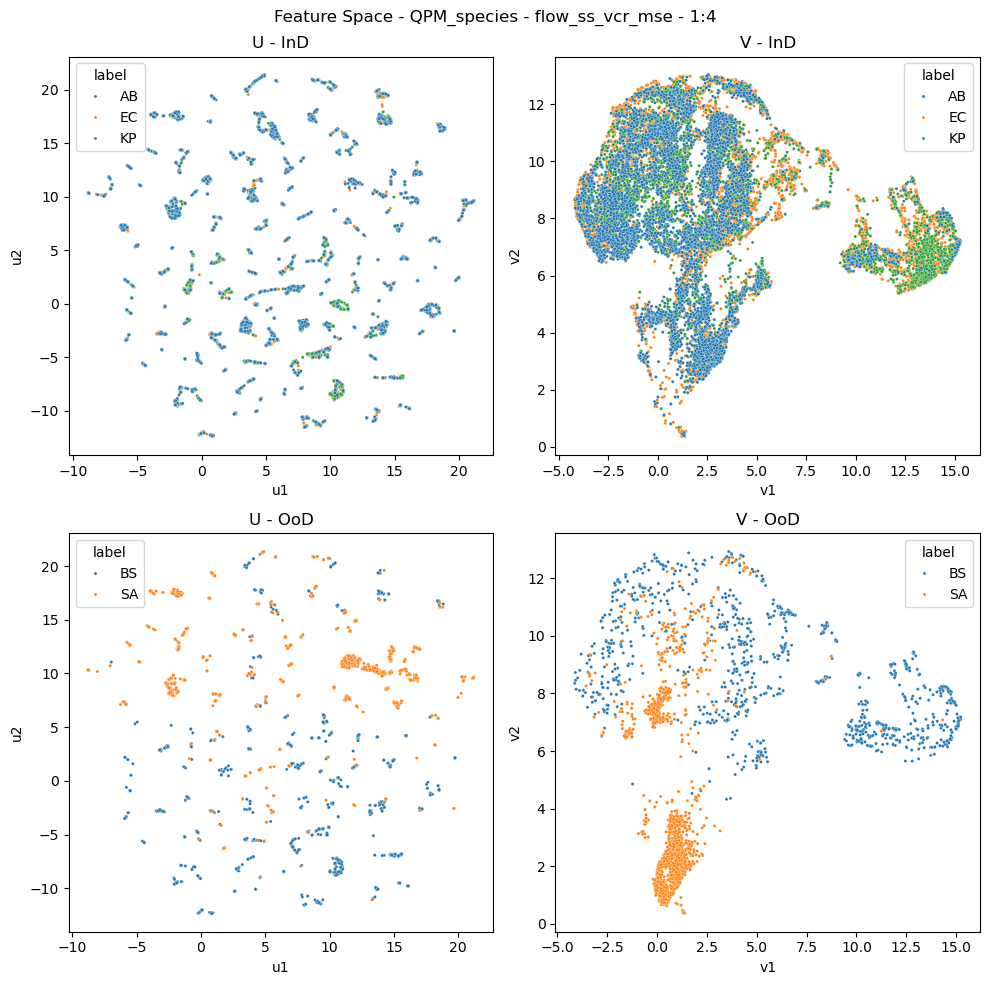

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

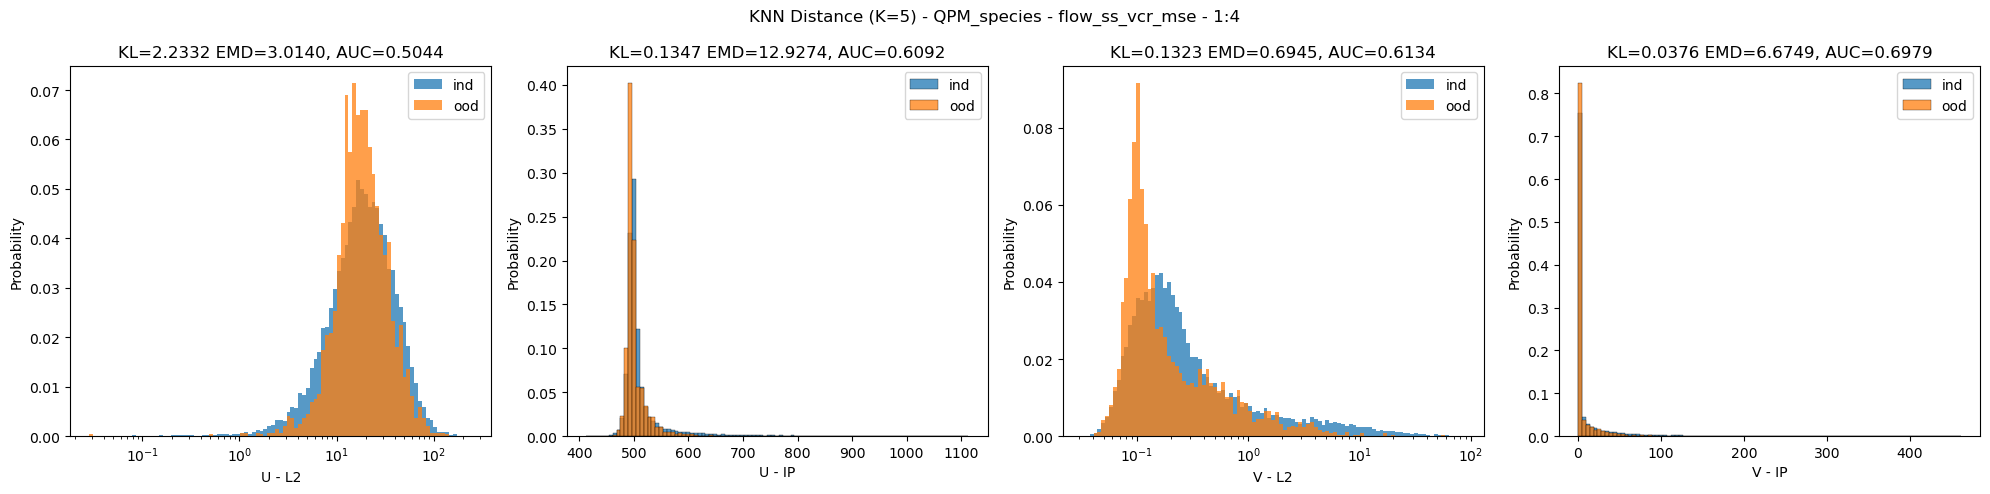

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

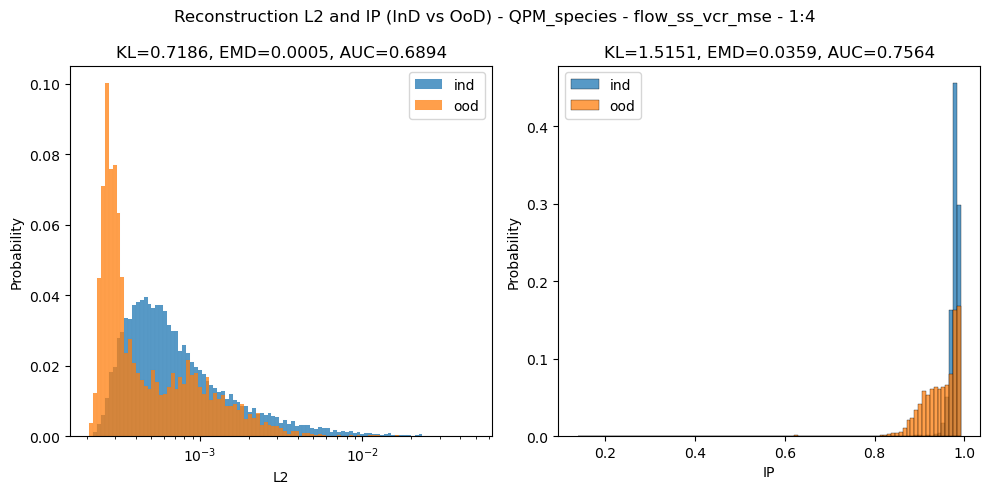

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

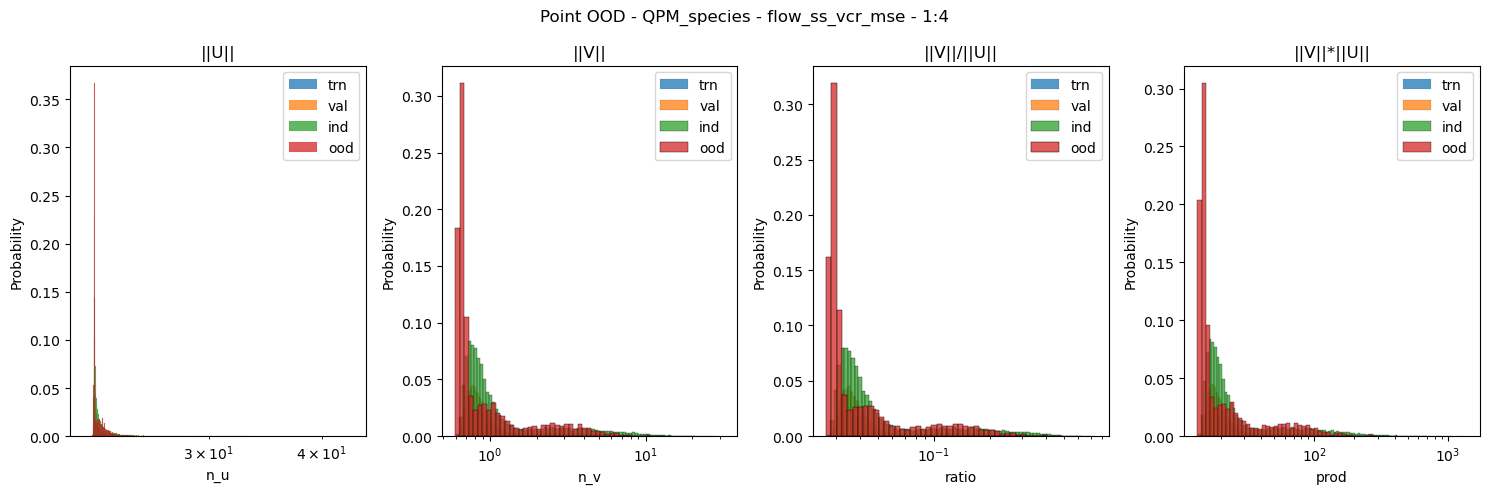

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


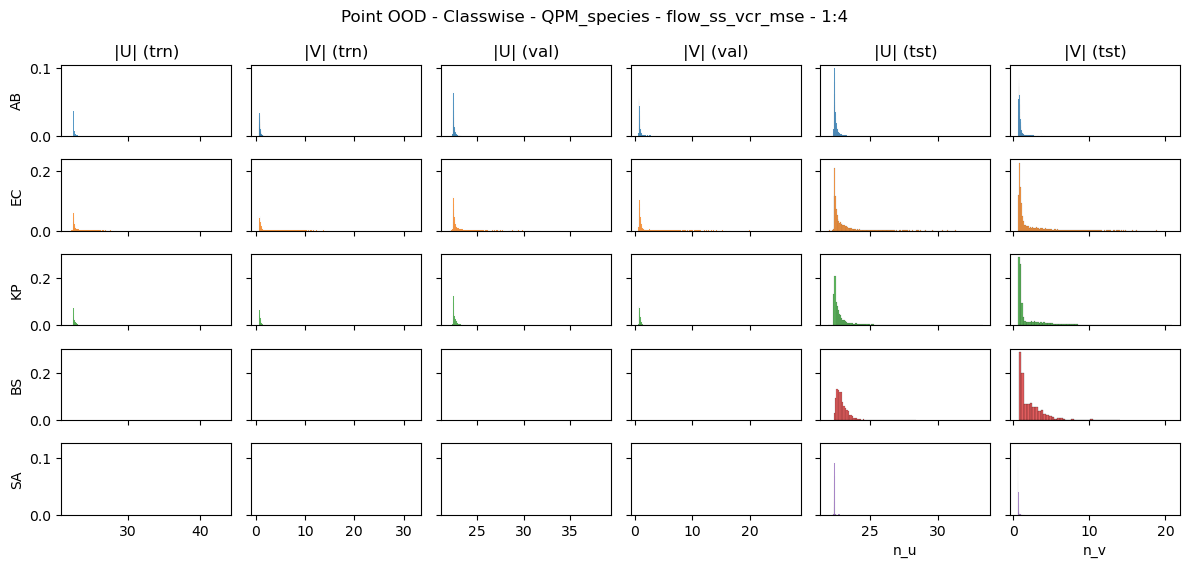

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

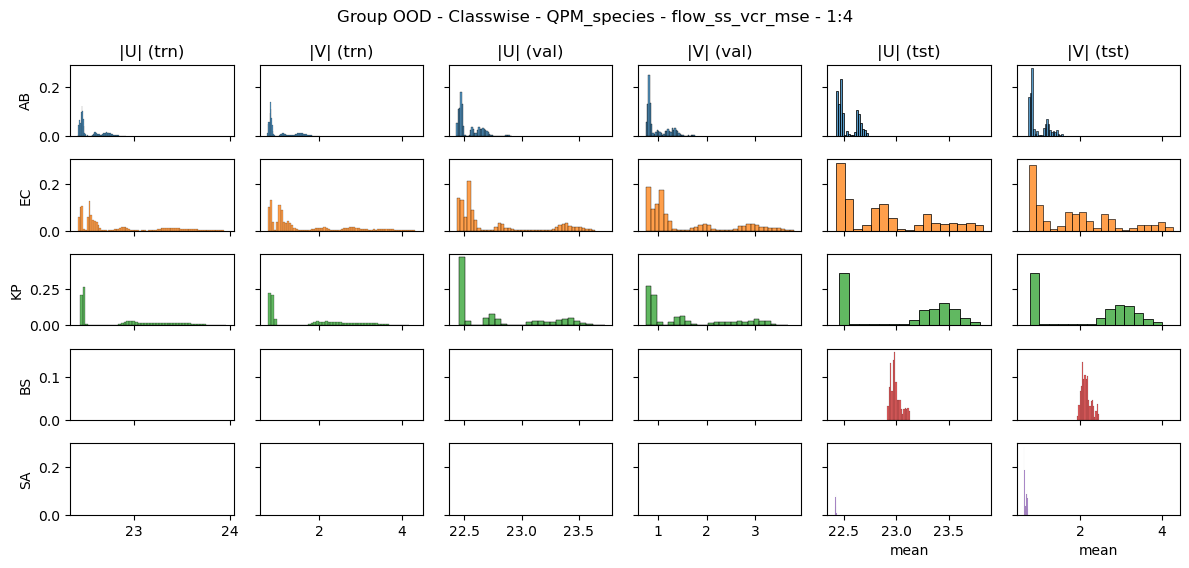

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)